In [1]:
options(mc.cores = parallel::detectCores())
library(rethinking)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.88)


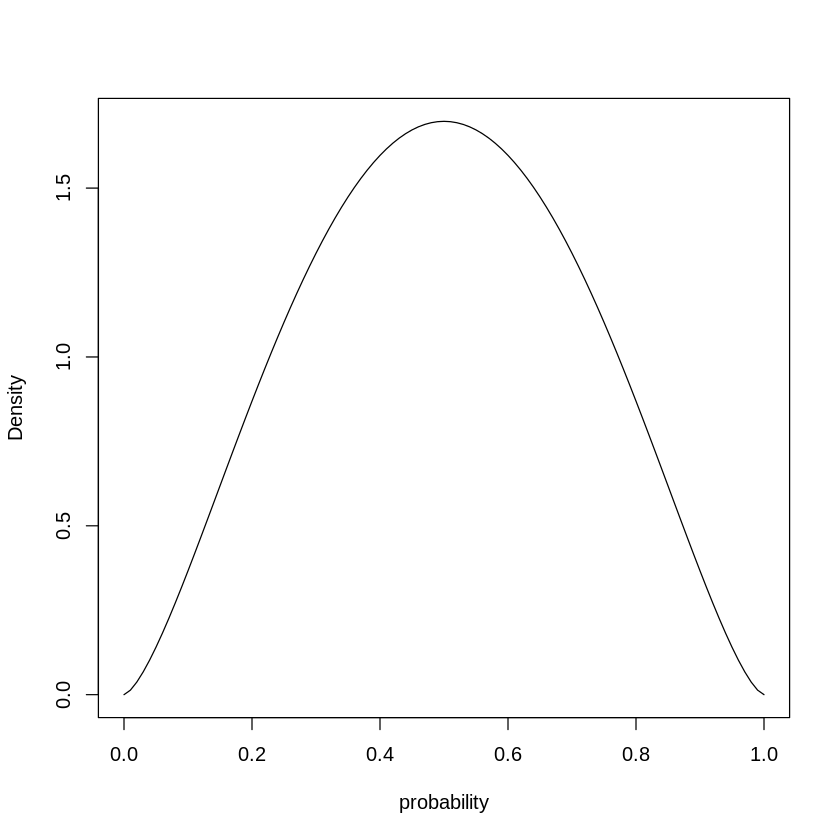

In [2]:
pbar <- 0.5
theta <- 5
curve( dbeta2(x,pbar,theta) , from=0 , to=1 ,
xlab="probability" , ylab="Density" )

In [3]:
library(rethinking)

data(UCBadmit)
d <- UCBadmit

d$gid <- ifelse( d$applicant.gender=="male" , 1L , 2L )
dat <- list( A=d$admit , N=d$applications , gid=d$gid )

m12.1 <- ulam(
            alist(
                A ~ dbetabinom( N , pbar , theta ),
                logit(pbar) <- a[gid],
                a[gid] ~ dnorm( 0 , 1.5 ),
                theta ~ dexp(1)
            ), data=dat , chains=4, cores=4 )

In [4]:
post <- extract.samples( m12.1 )
post$da <- post$a[,1] - post$a[,2]
precis( post , depth=2 )

mean       sd        5.5%       94.5%     histogram    
a[1]  -0.4139323 0.4447592 -1.1331039 0.2843846 ▁▂▅▇▂▁▁      
a[2]  -0.2955730 0.4294538 -0.9880436 0.3771312 ▁▁▃▇▃▁▁      
theta  2.6832788 0.9356338  1.4105603 4.3192595 ▁▂▅▇▇▅▂▂▁▁▁▁▁
da    -0.1183593 0.6234829 -1.1262285 0.9093288 ▁▁▁▅▇▇▂▁▁

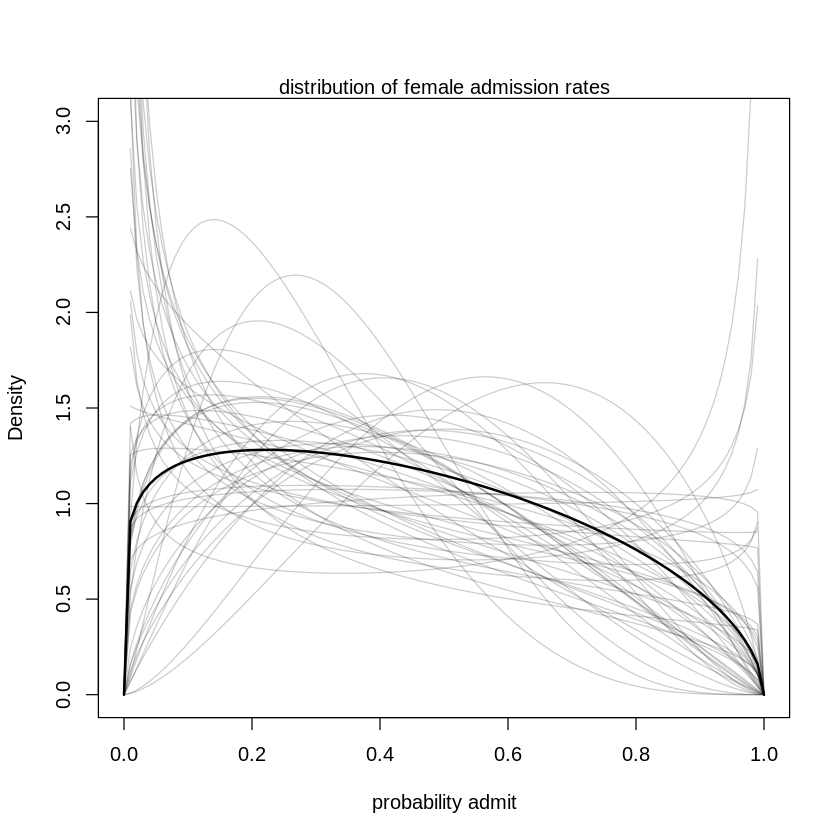

In [5]:
gid <- 2

# draw posterior mean beta distribution
curve( dbeta2(x,mean(logistic(post$a[,gid])),mean(post$theta)) , from=0 , to=1 ,
ylab="Density" , xlab="probability admit", ylim=c(0,3) , lwd=2 )

# draw 50 beta distributions sampled from posterior
for ( i in 1:50 ) {
    p <- logistic( post$a[i,gid] )
    theta <- post$theta[i]
    curve( dbeta2(x,p,theta) , add=TRUE , col=col.alpha("black",0.2) )
}

mtext( "distribution of female admission rates" )

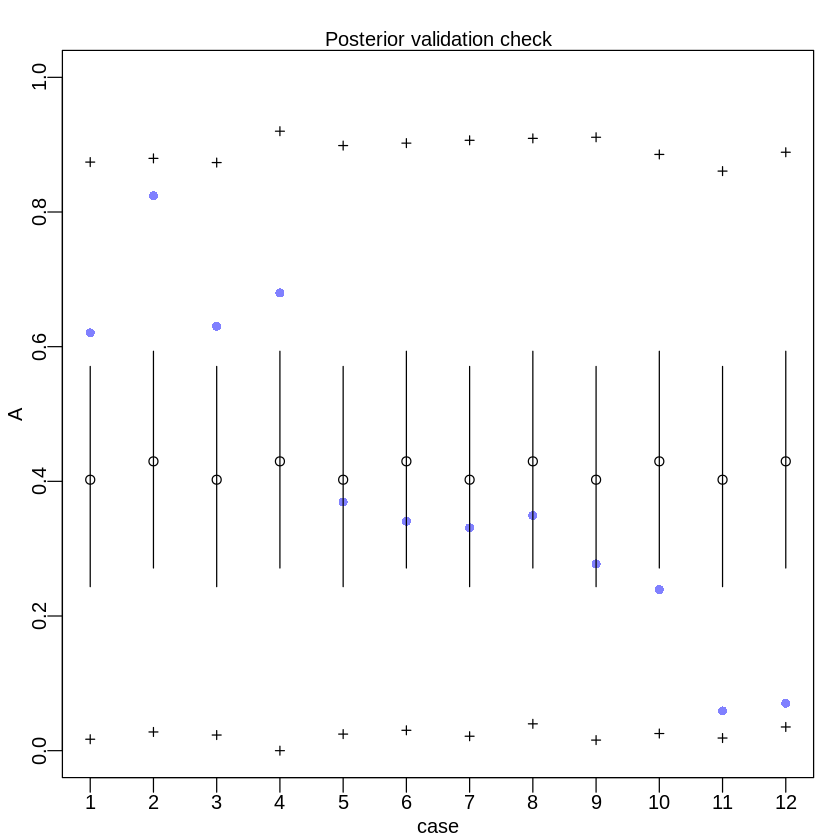

In [6]:
postcheck( m12.1 )

In [7]:
library(rethinking)

data(Kline)
d <- Kline

d$P <- standardize( log(d$population) )
d$contact_id <- ifelse( d$contact=="high" , 2L , 1L )

dat2 <- list(
            T = d$total_tools,
            P = d$population,
            cid = d$contact_id )

m12.3 <- ulam(
            alist(
                T ~ dgampois( lambda , phi ),
                lambda <- exp(a[cid])*P^b[cid] / g,
                a[cid] ~ dnorm(1,1),
                b[cid] ~ dexp(1),
                g ~ dexp(1),
                phi ~ dexp(1)
            ), data=dat2 , chains=4 , cores=4 , log_lik=TRUE )


In [8]:
precis(m12.3, depth=2)

mean      sd        5.5%        94.5%     n_eff     Rhat    
a[1] 0.9701986 0.8632400 -0.41273127 2.3388559  989.1340 1.005024
a[2] 1.0115554 0.9648815 -0.55270933 2.4638284 1148.6274 1.000846
b[1] 0.2432632 0.1005926  0.08355330 0.4111418  699.3247 1.009747
b[2] 0.2687591 0.1342984  0.05884011 0.4942545  841.6114 1.004210
g    1.1030315 0.9136807  0.17842825 2.7023936 1077.3249 1.001536
phi  3.6386452 1.6402206  1.53521983 6.6167476 1074.5350 1.000546

In [9]:
(k <- LOOPk(m12.3))

[1] 0.31600941 0.28484437 0.15542637 0.38102558 0.16219492 0.32896262
 [7] 0.06450228 0.18711228 0.25913314 0.41704790

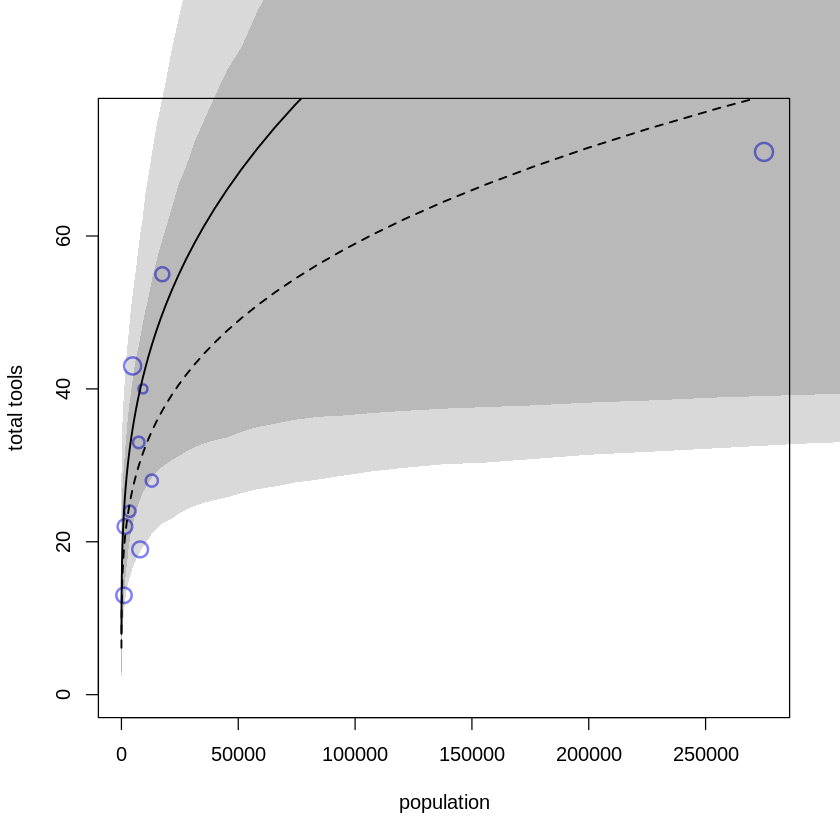

In [10]:
plot( d$population , d$total_tools , xlab="population" , ylab="total tools" ,
col=rangi2 , pch=ifelse( dat$cid==1 , 1 , 16 ) , lwd=2 ,
     ylim=c(0,75) , cex=1+normalize(k) )

ns <- 100
P_seq <- seq( from=-5 , to=3 , length.out=ns )
pop_seq <- exp( P_seq*sd(log(d$population)) + mean(log(d$population)) )


lambda <- link( m12.3, data=data.frame( P=pop_seq , cid=1 ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines( pop_seq , lmu , lty=2 , lwd=1.5 )
shade( lci , pop_seq , xpd=TRUE )


lambda <- link( m12.3, data=data.frame( P=pop_seq , cid=2 ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines( pop_seq , lmu , lty=1 , lwd=1.5 )
shade( lci , pop_seq , xpd=TRUE )

In [11]:
# define parameters
prob_drink <- 0.2 # 20% of days
rate_work <- 1

# average 1 manuscript per day
# sample one year of production
N <- 365

# simulate days monks drink
set.seed(365)
drink <- rbinom( N , 1 , prob_drink )

# simulate manuscripts completed
y <- (1-drink)*rpois( N , rate_work )

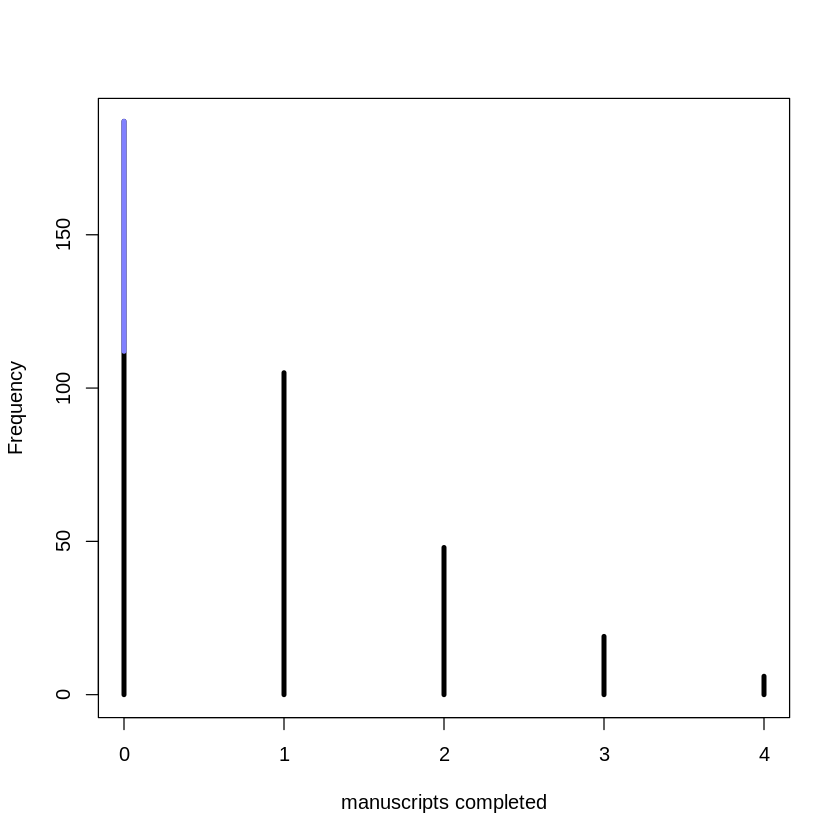

In [12]:
simplehist( y , xlab="manuscripts completed" , lwd=4 )
zeros_drink <- sum(drink)
zeros_work <- sum(y==0 & drink==0)
zeros_total <- sum(y==0)
lines( c(0,0) , c(zeros_work,zeros_total) , lwd=4 , col=rangi2 )

In [13]:
m12.4 <- ulam(
            alist(
                y ~ dzipois( p , lambda ),
                logit(p) <- ap,
                log(lambda) <- al,
                ap ~ dnorm( -1.5 , 1 ),
                al ~ dnorm( 1 , 0.5 )
            ) , data=list(y=as.integer(y)) , chains=4, cores=4 )

precis( m12.4 )

mean        sd         5.5%       94.5%      n_eff    Rhat    
ap -1.27555731 0.35365513 -1.8893135 -0.7905834 656.5848 1.001745
al  0.01332671 0.09141209 -0.1391286  0.1595870 758.6212 1.000953

In [14]:
inv_logit(-1.28) # probability drink
exp(0.01)
# rate finish manuscripts, when not drinking

[1] 0.2175502

[1] 1.01005

In [15]:
dzipois

function (x, p, lambda, log = FALSE) 
{
    ll <- rep(0, length(x))
    p_i <- p[1]
    lambda_i <- lambda[1]
    for (i in 1:length(x)) {
        if (length(p) > 1) 
            p_i <- p[i]
        if (length(lambda) > 1) 
            lambda_i <- lambda[i]
        if (x[i] == 0) {
            ll[i] <- log_sum_exp(c(log(p_i), log(1 - p_i) + dpois(x[i], 
                lambda_i, TRUE)))
        }
        else {
            ll[i] <- log(1 - p_i) + dpois(x[i], lambda_i, TRUE)
        }
    }
    if (log == FALSE) 
        ll <- exp(ll)
    return(ll)
}
<bytecode: 0x5619faf34548>
<environment: namespace:rethinking>

In [16]:
stancode(m12.4)

data{
    int y[365];
}
parameters{
    real ap;
    real al;
}
model{
    real p;
    real lambda;
    al ~ normal( 1 , 0.5 );
    ap ~ normal( -1.5 , 1 );
    lambda = al;
    lambda = exp(lambda);
    p = ap;
    p = inv_logit(p);
    for ( i in 1:365 ) {
        if ( y[i]==0 )
            target += log_mix( p , 0 , poisson_lpmf(0|lambda) );
        if ( y[i] > 0 )
            target += log1m( p ) + poisson_lpmf(y[i] | lambda );
    }
}



In [17]:
m12.4_alt <- ulam(
                alist(
                    y|y>0 ~ custom( log1m(p) + poisson_lpmf(y|lambda) ),
                    y|y==0 ~ custom( log_mix( p , 0 , poisson_lpmf(0|lambda) ) ),
                    logit(p) <- ap,
                    log(lambda) <- al,
                    ap ~ dnorm(-1.5,1),
                    al ~ dnorm(1,0.5)
                ) , data=list(y=as.integer(y)) , chains=4, cores=4 )

In [18]:
stancode(m12.4_alt)

data{
    int y[365];
}
parameters{
    real ap;
    real al;
}
model{
    real p;
    real lambda;
    al ~ normal( 1 , 0.5 );
    ap ~ normal( -1.5 , 1 );
    lambda = al;
    lambda = exp(lambda);
    p = ap;
    p = inv_logit(p);
    for ( i in 1:365 ) 
        if ( y[i] == 0 ) target += log_mix(p, 0, poisson_lpmf(0 | lambda));
    for ( i in 1:365 ) 
        if ( y[i] > 0 ) target += log1m(p) + poisson_lpmf(y[i] | lambda);
}



In [19]:
precis(m12.4_alt)

mean         sd         5.5%       94.5%      n_eff    Rhat    
ap -1.287451721 0.36318778 -1.8953550 -0.8019625 435.5711 1.004083
al  0.008234404 0.09071367 -0.1325419  0.1485369 466.1658 1.002194

In [20]:
dordlogit

function (x, phi, a, log = FALSE) 
{
    a <- c(as.numeric(a), Inf)
    p <- logistic(a[x] - phi)
    na <- c(-Inf, a)
    np <- logistic(na[x] - phi)
    p <- p - np
    if (log == TRUE) 
        p <- log(p)
    p
}
<bytecode: 0x5619faefe450>
<environment: namespace:rethinking>

In [2]:
library(rethinking)
data(Trolley)
d <- Trolley

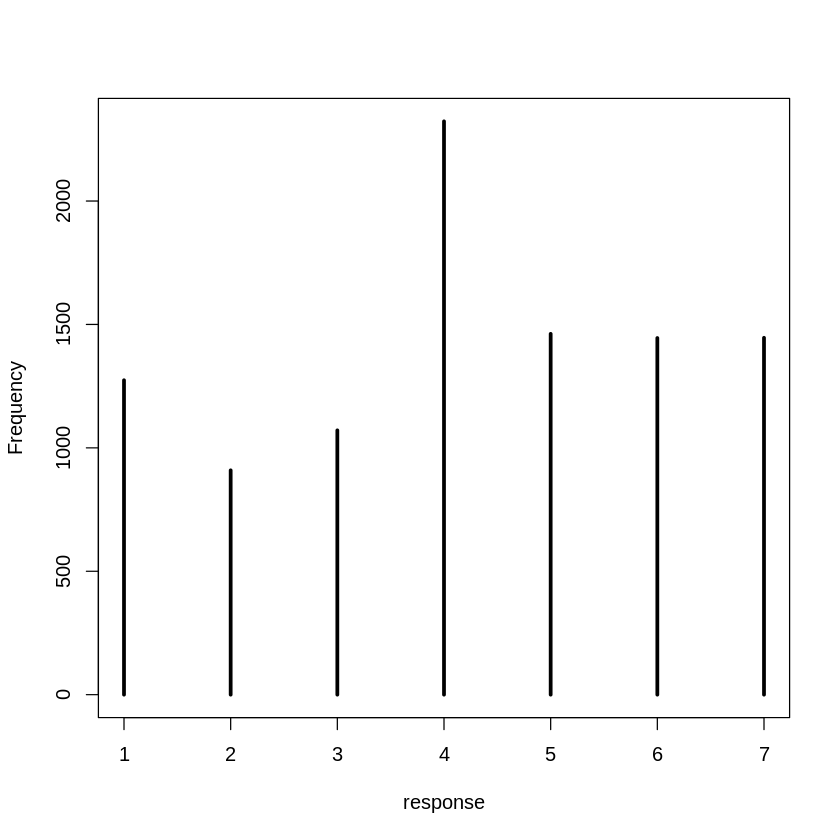

In [3]:
simplehist( d$response , xlim=c(1,7) , xlab="response" )

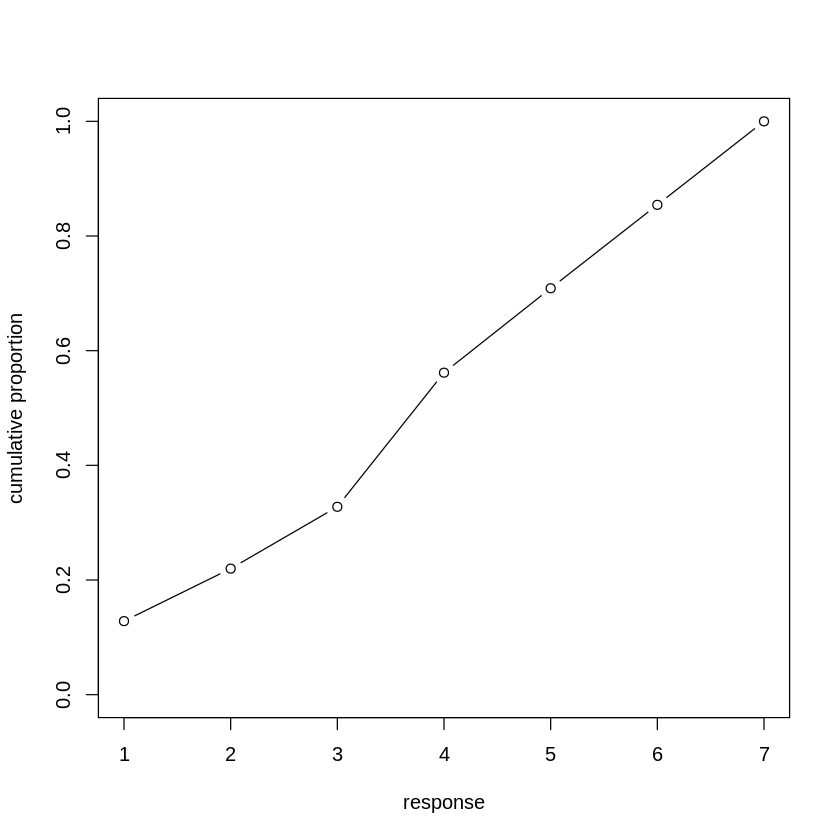

In [4]:
# discrete proportion of each response value
pr_k <- table( d$response ) / nrow(d)

# cumsum converts to cumulative proportions
cum_pr_k <- cumsum( pr_k )

# plot
plot( 1:7 , cum_pr_k , type="b" , xlab="response" ,
ylab="cumulative proportion" , ylim=c(0,1) )

In [5]:
logit(cum_pr_k)

1          2          3          4          5          6          7 
-1.9160912 -1.2666056 -0.7186340  0.2477857  0.8898637  1.7693809        Inf

1          2          3          4          5          6          7 
-1.9160912 -1.2666056 -0.7186340  0.2477857  0.8898637  1.7693809        Inf

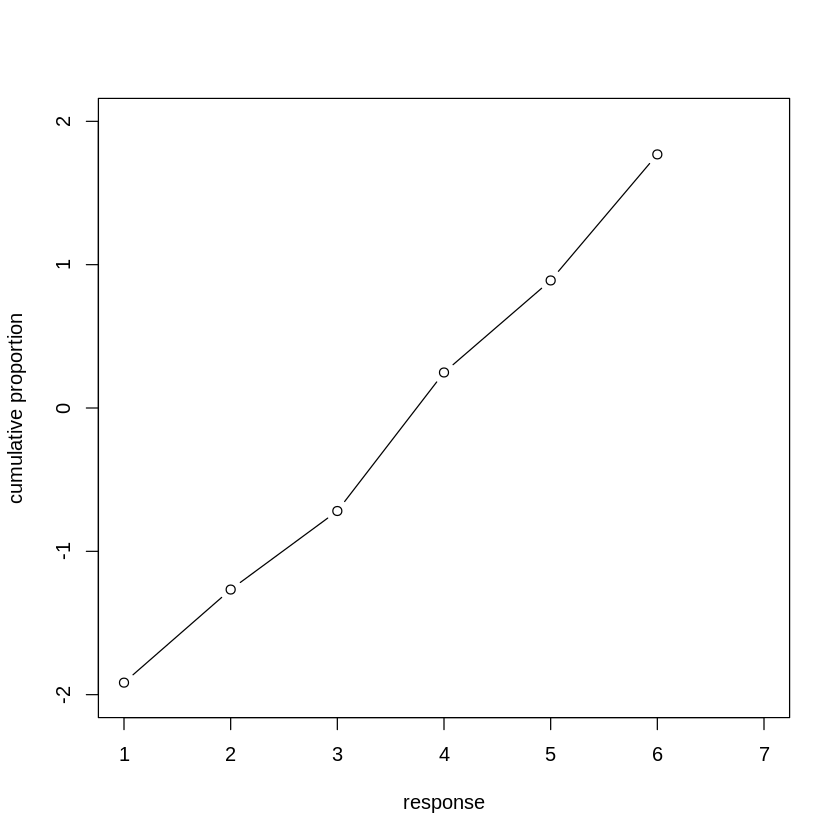

In [6]:
logitB <- function(x) log(x/(1-x)) # convenience function
( lco <- logitB( cum_pr_k ) )

# plot
plot( 1:7 , lco , type="b" , xlab="response" ,
ylab="cumulative proportion" , ylim=c(-2,2) )

In [26]:
m12.5 <- ulam(
            alist(
                R ~ dordlogit( 0 , cutpoints ),
                cutpoints ~ dnorm( 0 , 1.5 )
                ) ,
            data=list( R=d$response ), chains=4 , cores=4 )

In [27]:
precis(m12.5, depth=2)

mean       sd         5.5%       94.5%      n_eff    Rhat     
cutpoints[1] -1.9168275 0.03010401 -1.9645153 -1.8687800 1587.297 1.0007953
cutpoints[2] -1.2669359 0.02410911 -1.3065826 -1.2291778 1817.625 0.9993435
cutpoints[3] -0.7184097 0.02134456 -0.7519127 -0.6840287 1938.397 0.9993649
cutpoints[4]  0.2482188 0.01999280  0.2163171  0.2806896 2234.460 0.9987324
cutpoints[5]  0.8912133 0.02175020  0.8553976  0.9255552 2250.321 0.9999030
cutpoints[6]  1.7702207 0.02794379  1.7263455  1.8149171 2167.942 0.9985297

In [28]:
inv_logit(coef(m12.5))

cutpoints[1] cutpoints[2] cutpoints[3] cutpoints[4] cutpoints[5] cutpoints[6] 
   0.1282158    0.2197822    0.3277433    0.5617380    0.7091405    0.8544851

In [29]:
m12.5q <- quap(
            alist(
                response ~ dordlogit( 0 , c(a1,a2,a3,a4,a5,a6) ),
                c(a1,a2,a3,a4,a5,a6) ~ dnorm( 0 , 1.5 )
                ) , data=d 
                , start=list(a1=-2,a2=-1,a3=0,a4=1,a5=2,a6=2.5) 
            )

In [30]:
precis(m12.5q, depth=2)

mean       sd         5.5%       94.5%     
a1 -1.9151111 0.02998740 -1.9630367 -1.8671854
a2 -1.2659285 0.02421690 -1.3046318 -1.2272252
a3 -0.7182221 0.02136931 -0.7523744 -0.6840698
a4  0.2477890 0.02021625  0.2154795  0.2800984
a5  0.8896250 0.02208010  0.8543368  0.9249133
a6  1.7688071 0.02843564  1.7233615  1.8142528

In [31]:
inv_logit(coef(m12.5q))

a1        a2        a3        a4        a5        a6 
0.1284077 0.2199550 0.3277846 0.5616322 0.7088128 0.8543093

In [32]:
cum_pr_k

1         2         3         4         5         6         7 
0.1282981 0.2198389 0.3276939 0.5616314 0.7088620 0.8543807 1.0000000

In [33]:
( pk <- dordlogit( 1:7 , 0 , coef(m12.5) ) )

[1] 0.12821576 0.09156646 0.10796104 0.23399479 0.14740245 0.14534462 0.14551489

In [34]:
sum( pk*(1:7) )

[1] 4.198895

In [35]:
( pk <- dordlogit( 1:7 , 0 , coef(m12.5)-0.5 ) )

[1] 0.08189848 0.06402531 0.08229263 0.20916872 0.15918960 0.18420577 0.21921948

In [36]:
sum( pk*(1:7) )

[1] 4.729221

In [7]:
dat <- list(
            R = d$response,
            A = d$action,
            I = d$intention,
            C = d$contact )

m12.6 <- ulam(
            alist(
                R ~ dordlogit( phi , cutpoints ),
                phi <- bA*A + bC*C + BI*I ,
                BI <- bI + bIA*A + bIC*C ,
                c(bA,bI,bC,bIA,bIC) ~ dnorm( 0 , 0.5 ),
                cutpoints ~ dnorm( 0 , 1.5 )
                ) ,
            data=dat , chains=4 , cores=4 )
        

In [9]:
precis( m12.6, depth=2 )

mean       sd         5.5%       94.5%      n_eff     Rhat     
bIC          -1.2337142 0.09706486 -1.3952292 -1.0806660 1051.1308 0.9996779
bIA          -0.4315658 0.07963831 -0.5599356 -0.3046464  880.6871 0.9995808
bC           -0.3451264 0.06897937 -0.4515516 -0.2335918 1034.5470 0.9999062
bI           -0.2925177 0.05798854 -0.3865846 -0.1994525  901.1499 0.9988817
bA           -0.4749941 0.05353452 -0.5578191 -0.3877646  941.3013 0.9998485
cutpoints[1] -2.6347958 0.05113055 -2.7158513 -2.5530475 1045.0845 0.9996621
cutpoints[2] -1.9393641 0.04751372 -2.0144252 -1.8647188 1021.0084 0.9989719
cutpoints[3] -1.3446320 0.04569972 -1.4181684 -1.2723437  974.3591 0.9988822
cutpoints[4] -0.3106757 0.04409552 -0.3801733 -0.2426525  959.6286 0.9993300
cutpoints[5]  0.3603661 0.04407583  0.2886376  0.4319038 1017.5347 0.9991656
cutpoints[6]  1.2673761 0.04738221  1.1890994  1.3440065 1134.4361 0.9993411

In [39]:
dordlogit

function (x, phi, a, log = FALSE) 
{
    a <- c(as.numeric(a), Inf)
    p <- logistic(a[x] - phi)
    na <- c(-Inf, a)
    np <- logistic(na[x] - phi)
    p <- p - np
    if (log == TRUE) 
        p <- log(p)
    p
}
<bytecode: 0x5619faefe450>
<environment: namespace:rethinking>

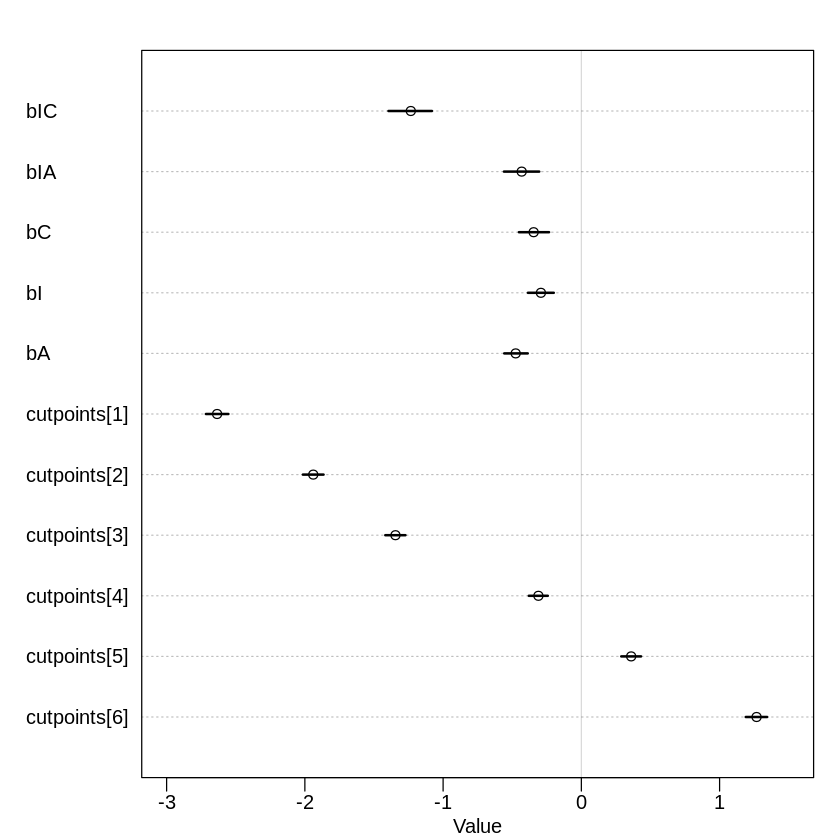

In [10]:
plot( precis(m12.6, depth=2) , xlim=c(-3,1.5) )

In [8]:
m12.6q <- quap(
            alist(    
                R ~ dordlogit( phi , c(a1,a2,a3,a4,a5,a6) ),
                phi <- bA*A + bC*C + BI*I ,
                BI <- bI + bIA*A + bIC*C ,
                c(bA,bI,bC,bIA,bIC) ~ dnorm( 0 , 0.5 ),
#                 cutpoints ~ dnorm( 0 , 1.5 )
                c(a1,a2,a3,a4,a5,a6) ~ dnorm( 0 , 1.5 )
                ) ,
                data=dat
                , start=list(a1=-2,a2=-1,a3=0,a4=1,a5=2,a6=2.5) 
)

precis(m12.6q, depth=2)

mean       sd         5.5%       94.5%     
a1  -2.6313577 0.05154380 -2.7137346 -2.5489807
a2  -1.9364711 0.04756134 -2.0124833 -1.8604589
a3  -1.3423005 0.04531380 -1.4147207 -1.2698803
a4  -0.3083880 0.04337651 -0.3777120 -0.2390639
a5   0.3620051 0.04359255  0.2923358  0.4316744
a6   1.2673982 0.04640192  1.1932389  1.3415574
bA  -0.4721588 0.05378842 -0.5581231 -0.3861945
bI  -0.2913234 0.05694755 -0.3823366 -0.2003102
bC  -0.3425008 0.06815629 -0.4514277 -0.2335739
bIA -0.4335709 0.07892301 -0.5597052 -0.3074367
bIC -1.2349561 0.09649161 -1.3891683 -1.0807438

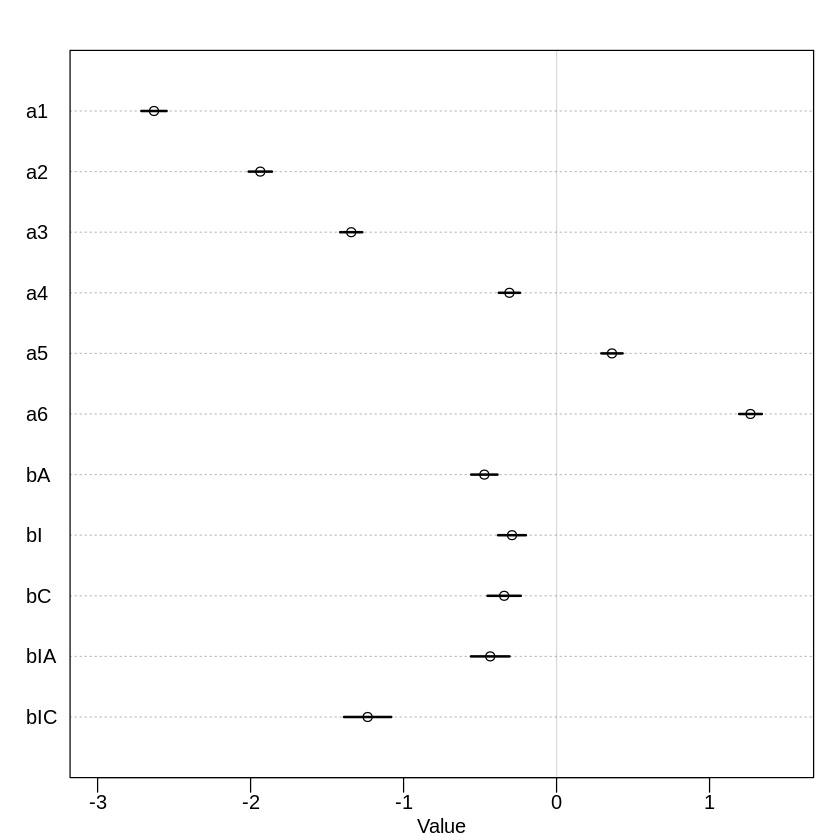

In [11]:
plot( precis(m12.6q, depth=2) , xlim=c(-3,1.5) )

In [17]:
kA <- 0
# value for action

kC <- 0
# value for contact

kI <- 0:1
# values of intention to calculate over

pdat <- data.frame(A=kA,C=kC,I=kI)

# post <- link( m12.6q , data=pdat )
# phi <- post$phi

# cutpoints <- coef(m12.6q)[1:6]
# print(cutpoints)

post <- extract.samples( m12.6q , data=pdat )


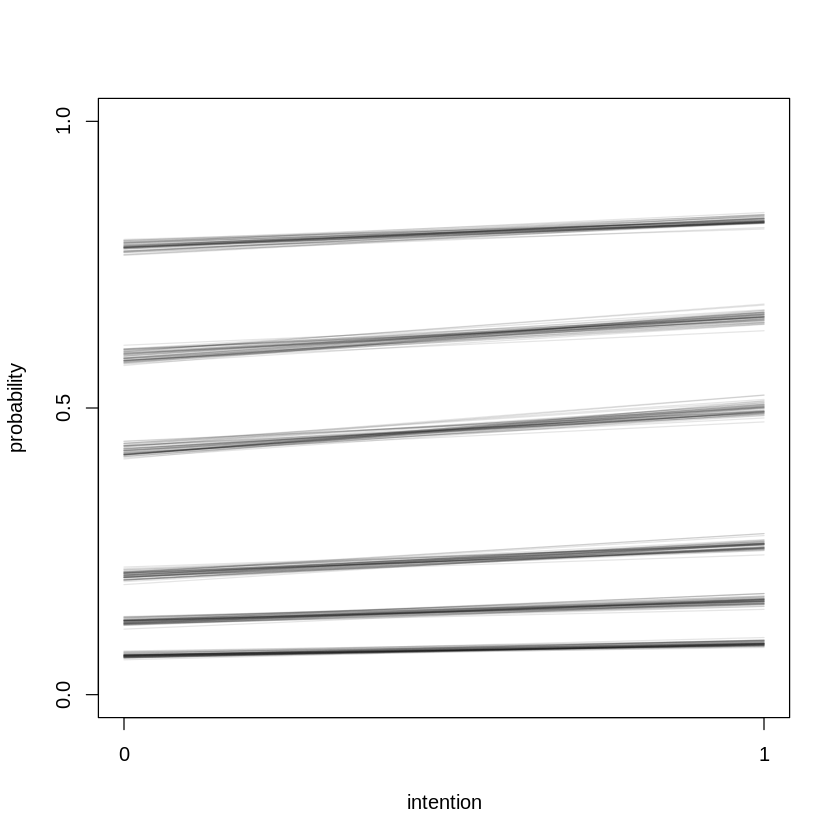

In [18]:
A <- pdat['A']
C <- pdat['C']
I <- pdat['I']

phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA*A[i,] + post$bC*C[i,] + post$bI*I[i,] + post$bIA*A[i,] + post$bIC*C[i,]

plot( NULL , type="n" , xlab="intention" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )
for ( s in 1:50 ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kI , pk[,i] , col=col.alpha("black",0.1) )
}

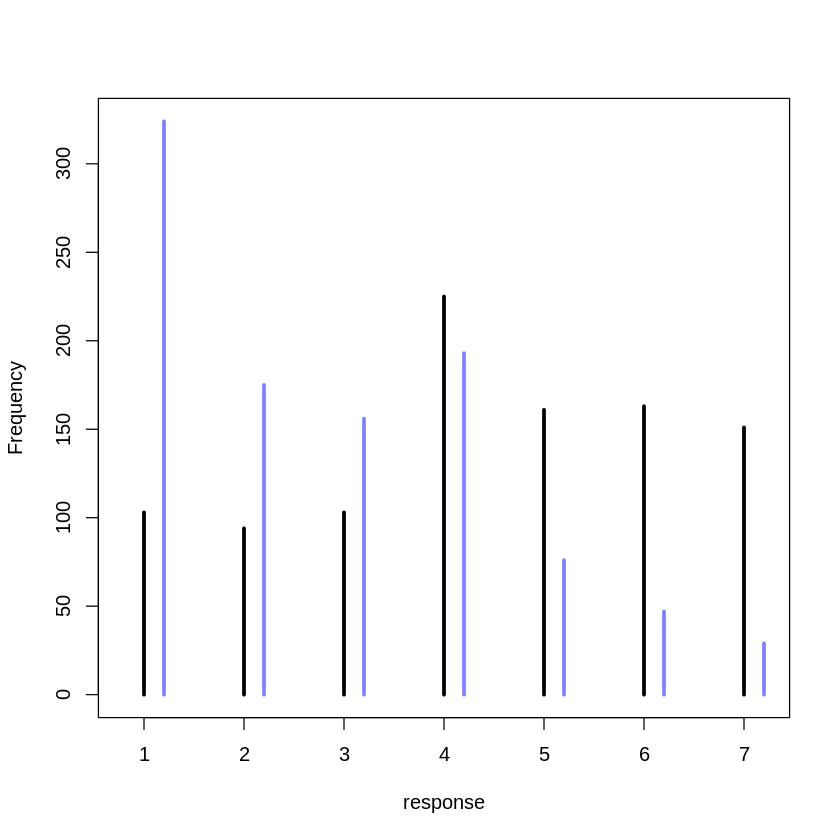

In [140]:
kA <- 0
# value for action
kC <- 1
# value for contact
kI <- 0:1
# values of intention to calculate over
pdat <- data.frame(A=kA,C=kC,I=kI)
s <- sim( m12.6 , data=pdat )
simplehist( s , xlab="response" )

From the revised version of 26th September (after I raised an issue in Github with the author about the missing post definition).  I'm still not sure whether this is the correct way of doing it, because the cutpoints taking from post (using extract.samples) are not sampled simultaneously with the phi (created using the link function).

6 vector or matrix parameters hidden. Use depth=2 to show them.


mean       sd         5.5%       94.5%      n_eff     Rhat    
bIC -1.2369896 0.09766788 -1.3994446 -1.0819576 1113.7232 1.002233
bIA -0.4333154 0.08084850 -0.5632861 -0.3025573  952.6377 1.001841
bC  -0.3419723 0.06929892 -0.4494893 -0.2308673 1063.6757 1.004061
bI  -0.2920472 0.05897454 -0.3835772 -0.1972105  839.8858 1.002976
bA  -0.4726250 0.05490887 -0.5583924 -0.3862438  922.3349 1.005815

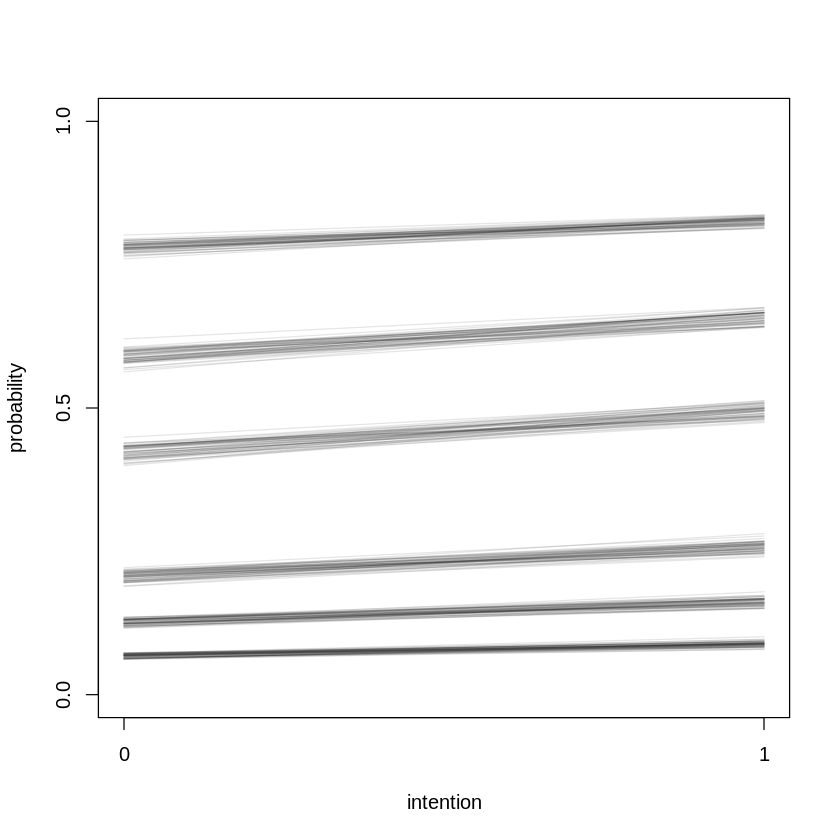

In [3]:
dat <- list(
R = d$response,
A = d$action,
I = d$intention,
C = d$contact )
m12.6 <- ulam(
alist(
R ~ dordlogit( phi , cutpoints ),
phi <- bA*A + bC*C + BI*I ,
BI <- bI + bIA*A + bIC*C ,
c(bA,bI,bC,bIA,bIC) ~ dnorm( 0 , 0.5 ),
cutpoints ~ dnorm( 0 , 1.5 )
) , data=dat , chains=4 , cores=4 )
precis( m12.6 )

plot( NULL , type="n" , xlab="intention" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )

kA <- 0
# value for action
kC <- 0
# value for contact
kI <- 0:1
# values of intention to calculate over
pdat <- data.frame(A=kA,C=kC,I=kI)
phi <- link( m12.6 , data=pdat )$phi

post <- extract.samples( m12.6 )
for ( s in 1:50 ) {
pk <- pordlogit( 1:6 , phi[s,] , post$cutpoints[s,] )
for ( i in 1:6 ) lines( kI , pk[,i] , col=col.alpha("black",0.1) )
}

In [141]:
library(rethinking)
data(Trolley)
d <- Trolley
levels(d$edu)

[1] "Bachelor's Degree"    "Elementary School"    "Graduate Degree"     
[4] "High School Graduate" "Master's Degree"      "Middle School"       
[7] "Some College"         "Some High School"

In [143]:
edu_levels <- c( 6 , 1 , 8 , 4 , 7 , 2 , 5 , 3 )
d$edu_new <- edu_levels[ d$edu ]

In [157]:
library(gtools)
set.seed(1805)
delta <- rdirichlet( 10 , alpha=rep(2,7) )
str(delta)

 num [1:10, 1:7] 0.1053 0.2504 0.1917 0.1241 0.0877 ...


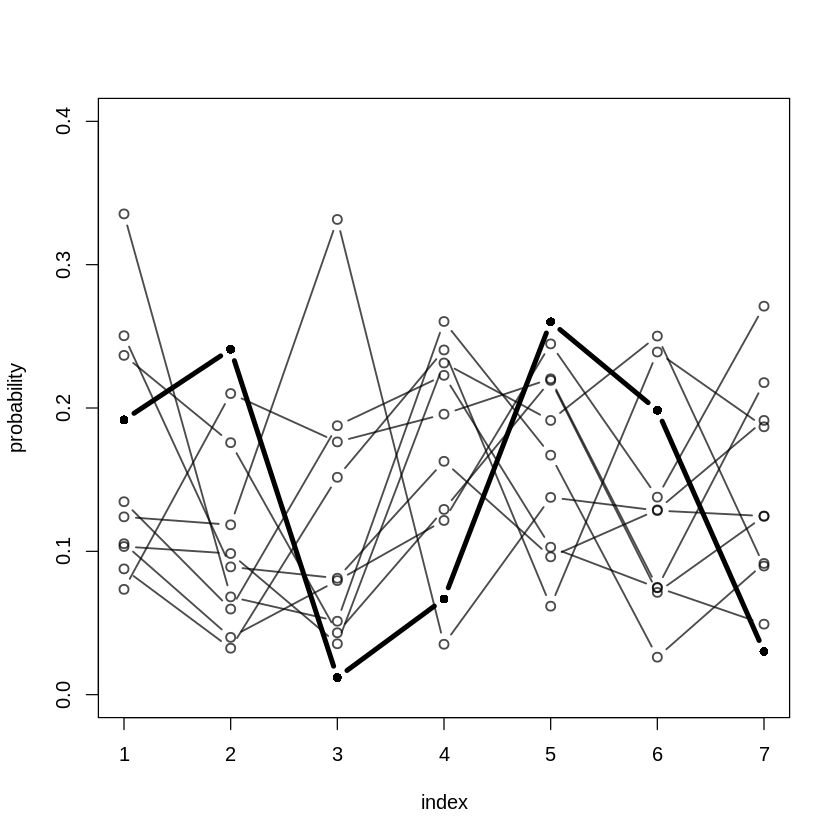

In [160]:
h <- 3
plot( NULL , xlim=c(1,7) , ylim=c(0,0.4) , xlab="index" , ylab="probability" )
for ( i in 1:nrow(delta) ) lines( 1:7 , delta[i,] , type="b" ,
pch=ifelse(i==h,16,1) , lwd=ifelse(i==h,4,1.5) ,
col=ifelse(i==h,"black",col.alpha("black",0.7)) )

In [164]:
dat <- list(
            R = d$response ,
            action = d$action,
            intention = d$intention,
            contact = d$contact,
            E = as.integer( d$edu_new ), # edu_new as an index
            alpha = rep(2,7) )  # delta prior


m12.7 <- ulam(  #Note, this requires library(gtools) to be installed otherwise there is an error parsing to Stan!!!
            alist(
                R ~ ordered_logistic( phi , kappa ),
                phi <- bE*sum( delta_j[1:E] ) + bA*action + bI*intention + bC*contact,
                kappa ~ normal( 0 , 1.5 ),
                c(bA,bI,bC,bE) ~ normal( 0 , 1 ),
                vector[8]: delta_j <<- append_row( 0 , delta ),
                simplex[7]: delta ~ dirichlet( alpha )
            ),
            data=dat , chains=3 , cores=3 )

Cautionary note:
Variable alpha contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.
recompiling to avoid crashing R session


In [182]:
precis( m12.7 , depth=2 , omit="kappa" )

mean        sd         5.5%         94.5%       n_eff     Rhat     
bE       -0.31648206 0.16160562 -0.587693607 -0.07211423  586.8044 1.0079286
bC       -0.95706568 0.04964981 -1.038111438 -0.87868476 1420.3307 0.9995426
bI       -0.71712069 0.03644799 -0.775949099 -0.65791651 1701.4281 0.9987459
bA       -0.70529653 0.04048668 -0.768736552 -0.64052810 1547.9249 0.9988209
delta[1]  0.22989896 0.13868786  0.046783144  0.47831213  836.3384 1.0074306
delta[2]  0.14306056 0.09093959  0.027942297  0.30520362 2000.9730 0.9991458
delta[3]  0.19095910 0.11151252  0.040605819  0.38834882 1620.6213 0.9998850
delta[4]  0.16880717 0.09393925  0.038284977  0.33601039 1424.4410 0.9984677
delta[5]  0.04233448 0.05119473  0.006160997  0.11277910  518.1351 1.0096974
delta[6]  0.09686294 0.06638293  0.019164533  0.22350833 1364.9635 1.0011213
delta[7]  0.12807679 0.08003641  0.028375608  0.27763609 1776.4028 1.0021008

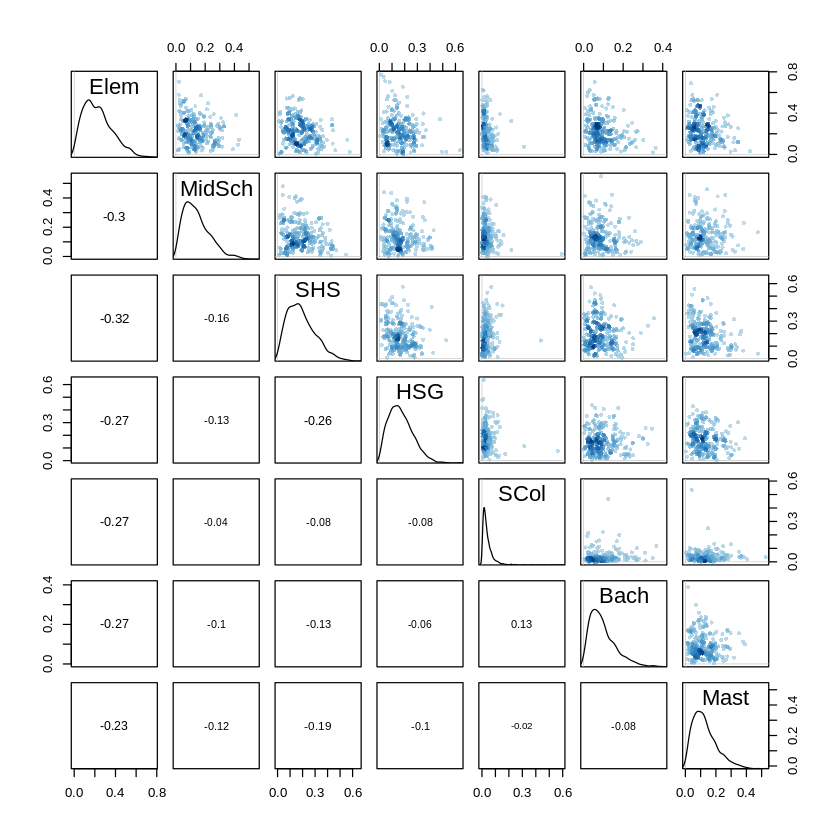

In [184]:
delta_labels <- c("Elem","MidSch","SHS","HSG","SCol","Bach","Mast","Grad")
pairs( m12.7 , pars="delta" , labels=delta_labels )

In [188]:
dat$edu_norm <- normalize( d$edu_new )

m12.8 <- ulam(
            alist(
                R ~ dordlogit( phi , cutpoints ),
                phi <- bE*edu_norm + bA*action + bI*intention + bC*contact,
                c(bA,bI,bC,bE) ~ normal( 0 , 1 ),
                cutpoints ~ normal( 0 , 1.5 )
            ), data=dat , chains=3 , cores=3 )

Cautionary note:
Variable alpha contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


In [189]:
precis( m12.8, depth=2 )

mean        sd         5.5%        94.5%       n_eff     Rhat     
bE           -0.09628343 0.09098504 -0.24477198  0.04726081 1290.8683 0.9990285
bC           -0.95621225 0.04974692 -1.03648036 -0.87745190 1713.7181 1.0008524
bI           -0.71747347 0.03549813 -0.77092345 -0.66012382 1604.7030 0.9997232
bA           -0.70369334 0.04076995 -0.76967001 -0.63868351 1630.7652 1.0023389
cutpoints[1] -2.89749454 0.07593744 -3.01706700 -2.77861941  917.1241 1.0003809
cutpoints[2] -2.21436885 0.07189384 -2.33092551 -2.10198580  983.8729 0.9994990
cutpoints[3] -1.63238200 0.07047462 -1.74898012 -1.52593876 1029.1069 0.9995436
cutpoints[4] -0.61095982 0.06906909 -0.72433631 -0.50351151 1065.7894 0.9994538
cutpoints[5]  0.05671301 0.06995188 -0.05789481  0.16583682 1052.4087 0.9995512
cutpoints[6]  0.96340996 0.07304686  0.84296207  1.07486245 1157.9336 0.9998980

PRACTICE

11M1

In [54]:
ratings <- list(12, 36, 7, 41)
total <- sum(12, 36, 7, 41)

num <- 0

for (i in 1:length(ratings)) {
    num <- num + ratings[[i]]
    den <- total - num
    CumOdds <- num / den
#     print(CumOdds)
    print(log(CumOdds))
}

[1] -1.94591
[1] 0
[1] 0.2937611
[1] Inf


In [57]:
r_cnt <- c(12, 36, 7, 41)
p_cum <- cumsum(r_cnt) /  sum(r_cnt)
print(p_cum)
log_cum_odds <- log(p_cum/(1-p_cum)) 
print(log_cum_odds) 

[1] 0.1250000 0.5000000 0.5729167 1.0000000
[1] -1.9459101  0.0000000  0.2937611        Inf


11M2

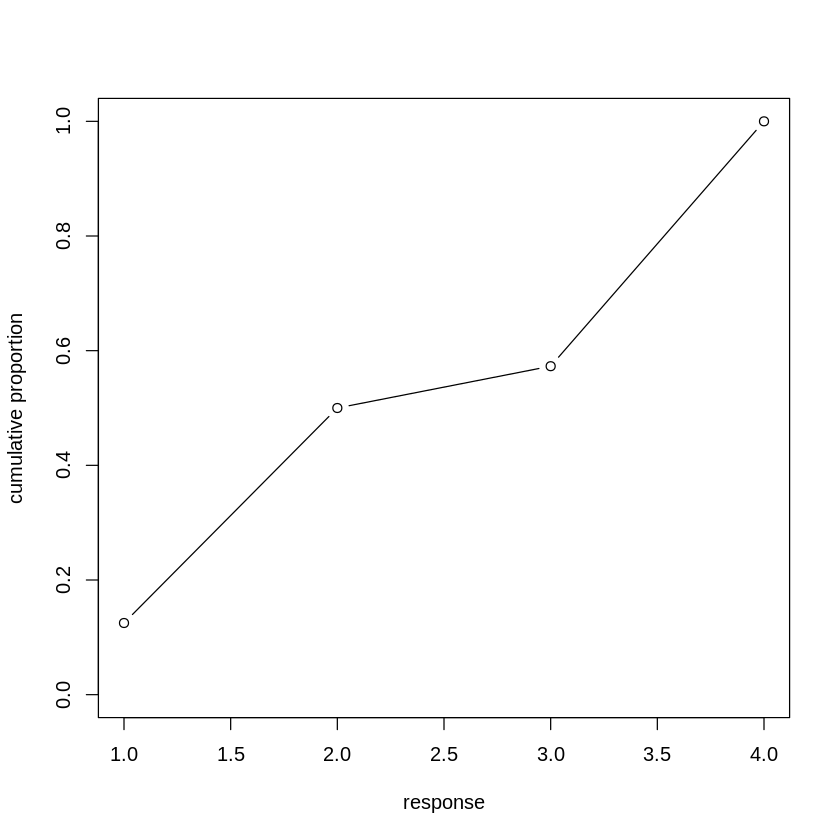

In [60]:
# plot
plot( 1:4 , p_cum , type="b" , xlab="response" ,
ylab="cumulative proportion" , ylim=c(0,1) )

11M3

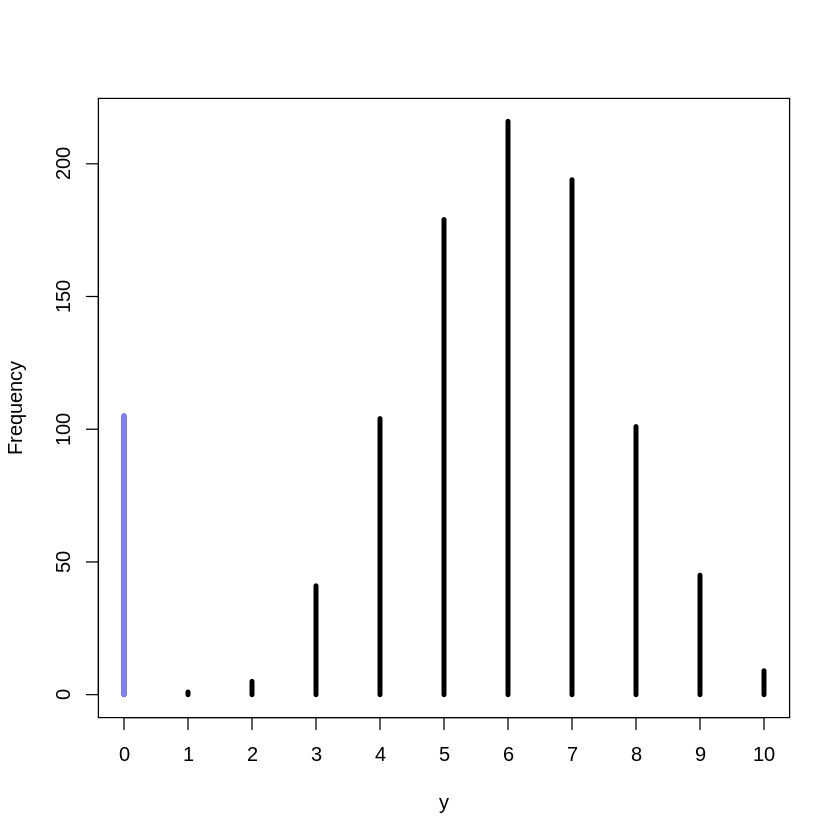

In [94]:
# define parameters
prob_sample_binom <- 0.9 # 80% of the time we sample from binomial distribution
num_trials <- 10
prob_success <- 0.6
# average 1 manuscript per day
# sample year of production
N <- 1e3
# simulate days monks drink
set.seed(365)
sample_binom <- rbinom( N , 1 , prob_sample_binom )    #Bernoulli dist to decide whether to sample from binomial distribution below
# simulate binomial dist
y <- (sample_binom)*rbinom( N , num_trials, prob_success )

simplehist( y , xlab="y" , lwd=4 )
zeros_binom_not_sampled <- sum(1-sample_binom)
zeros_y_and_binom_sampled <- sum(y==0 & sample_binom==1)
zeros_total <- sum(y==0)
lines( c(0,0) , c(zeros_y_and_binom_sampled,zeros_total) , lwd=4 , col=rangi2 )

In [104]:
m11M3 <- quap(      #Doesn't currently work with ulam()
            alist(
                y ~ dzibinom( p_zero, 10, p ),
                logit(p) <- ap,
                logit(p_zero) <- apz,
                ap ~ dnorm( 0 , 1 ),
                apz ~ dnorm( 0 , 1 )
            ) , data=list(y=as.integer(y)) )

precis( m11M3 )

mean       sd         5.5%      94.5%     
ap   0.4200046 0.02161793  0.385455  0.4545542
apz -2.1212536 0.10179481 -2.283941 -1.9585658

In [97]:
inv_logit(coef(m11M3))

ap       apz 
0.6034718 0.1070375

In [105]:
m11M3alt <- ulam(
                alist(
                    y|y>0 ~ custom( log1m(p_zero) + binomial_lpmf(y|10, p) ),
                    y|y==0 ~ custom( log_mix( p_zero , 0 , binomial_lpmf(0|10, p) ) ),
#                     N = 10,
                    logit(p) <- ap,
                    logit(p_zero) <- apz,
                    ap ~ dnorm( 0 , 1 ),
                    apz ~ dnorm( 0 , 1 )
                ) , data=list(y=as.integer(y)) , chains=4, cores=4 )

precis(m11M3alt)

recompiling to avoid crashing R session


mean       sd         5.5%       94.5%      n_eff    Rhat    
ap   0.4195775 0.02146519  0.3865518  0.4535509 1462.811 1.000069
apz -2.1246464 0.09839508 -2.2828368 -1.9722636 1306.770 1.000260

In [106]:
inv_logit(coef(m11M3alt))

ap       apz 
0.6033821 0.1067243

11H1

In [2]:
library(rethinking)
data(Hurricanes)

In [5]:
d <- Hurricanes
head(d)

name     year deaths category min_pressure damage_norm female femininity
1 Easy     1950  2     3        960           1590       1      6.77778   
2 King     1950  4     3        955           5350       0      1.38889   
3 Able     1952  3     1        985            150       0      3.83333   
4 Barbara  1953  1     1        987             58       1      9.83333   
5 Florence 1953  0     1        985             15       1      8.33333   
6 Carol    1954 60     3        960          19321       1      8.11111

In [202]:
dat1 <- list(deaths=d$deaths) #, femininity=d$feminimity)

m11h1int <- ulam(
                alist(
                    deaths ~ dpois(lamda) ,
                    log(lamda) <- a,
                    a ~ dnorm(2, 1)                
                ), data=dat1, chains=4, cores=4
                , log_lik=TRUE
            )

In [151]:
precis(m11h1int)

mean     sd         5.5%     94.5%    n_eff    Rhat    
a 3.026402 0.02209631 2.990622 3.060038 739.3746 1.002584

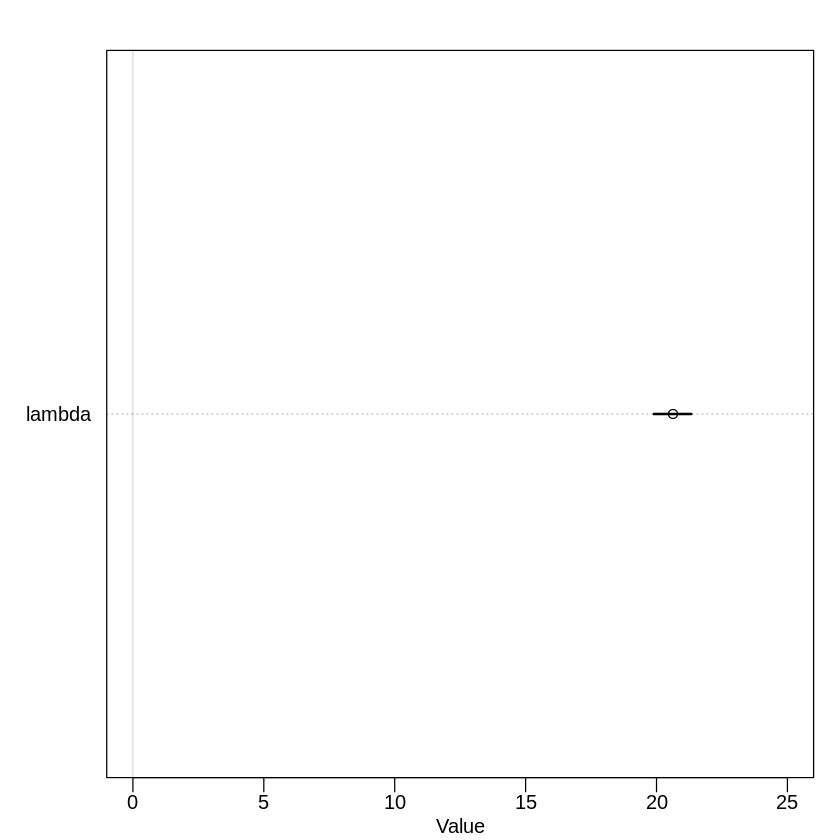

In [152]:
post <- extract.samples(m11h1int)
lambda <- exp( post$a )
plot( precis( as.data.frame(lambda) ) , xlim=c(0,25) )

In [174]:
# dd <- d[ complete.cases(d), ]
dat2 <- list(deaths=dd$deaths, f_std=standardize(d$femininity))

m11h1 <- ulam(
                alist(
                    deaths ~ dpois(lamda) ,
                    log(lamda) <- a + bF * f_std,
                    a ~ dnorm(2, 1) ,               
                    bF ~ dnorm( 0, 1 )    # max deaths is 256
                ), data=dat2, chains=4, cores=4
                , log_lik=TRUE
            )

mean      sd         5.5%      94.5%     n_eff    Rhat    
a  2.9996153 0.02447444 2.9607084 3.0371700 1282.232 1.000484
bF 0.2388269 0.02563377 0.1982684 0.2805398 1139.545 1.002656

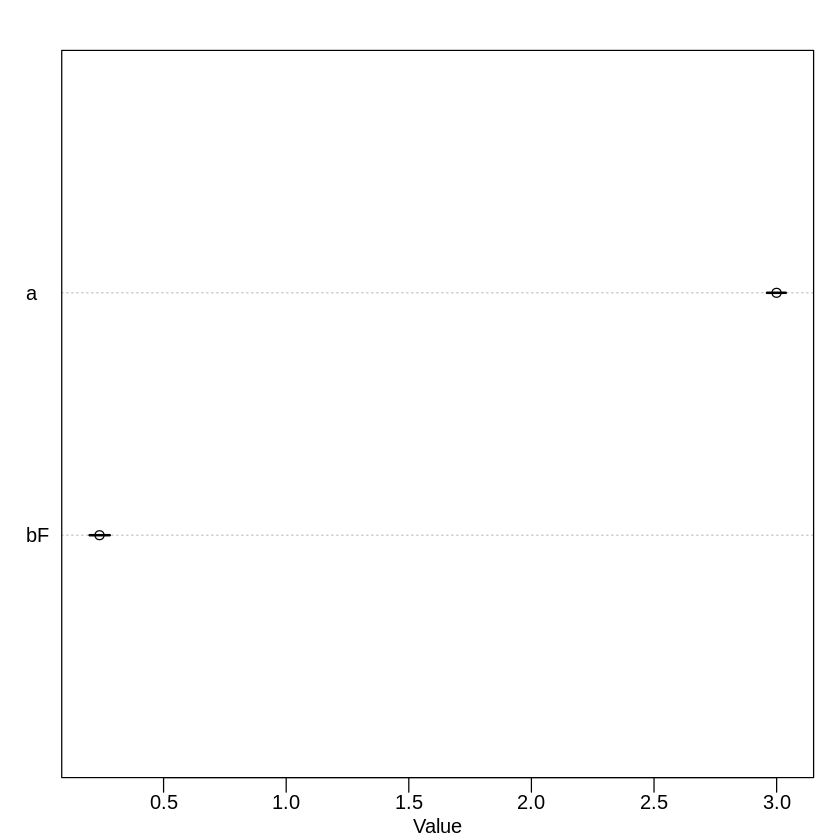

In [168]:
precis(m11h1)
plot(precis(m11h1))

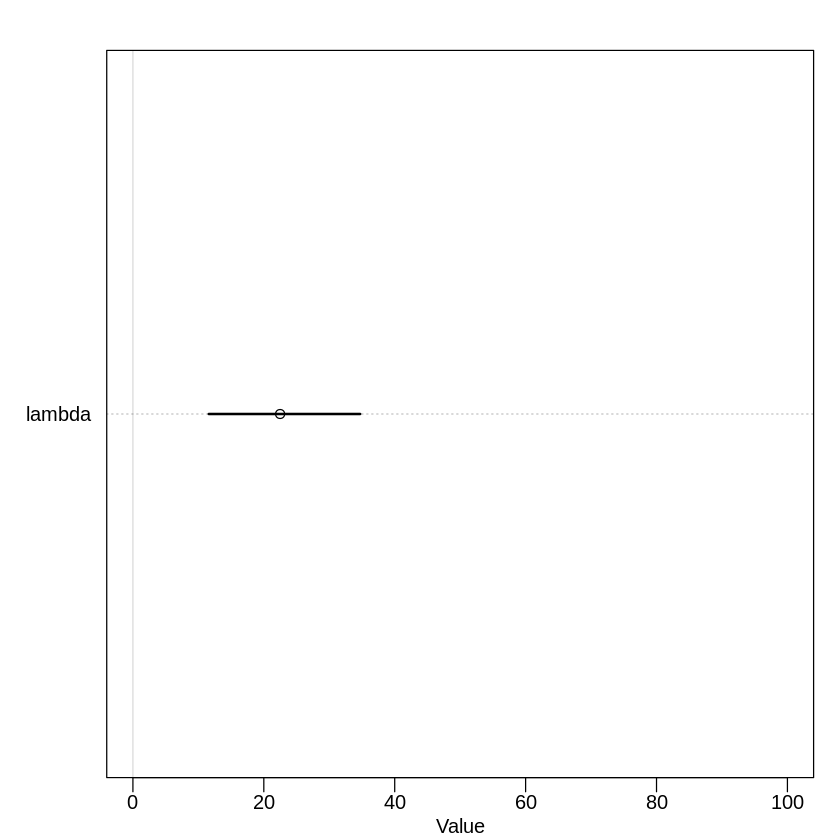

In [170]:
post <- extract.samples(m11h1)
lambda <- exp( post$a + post$bF * range(-2:2))
plot( precis( as.data.frame(lambda) ) , xlim=c(0,100) )

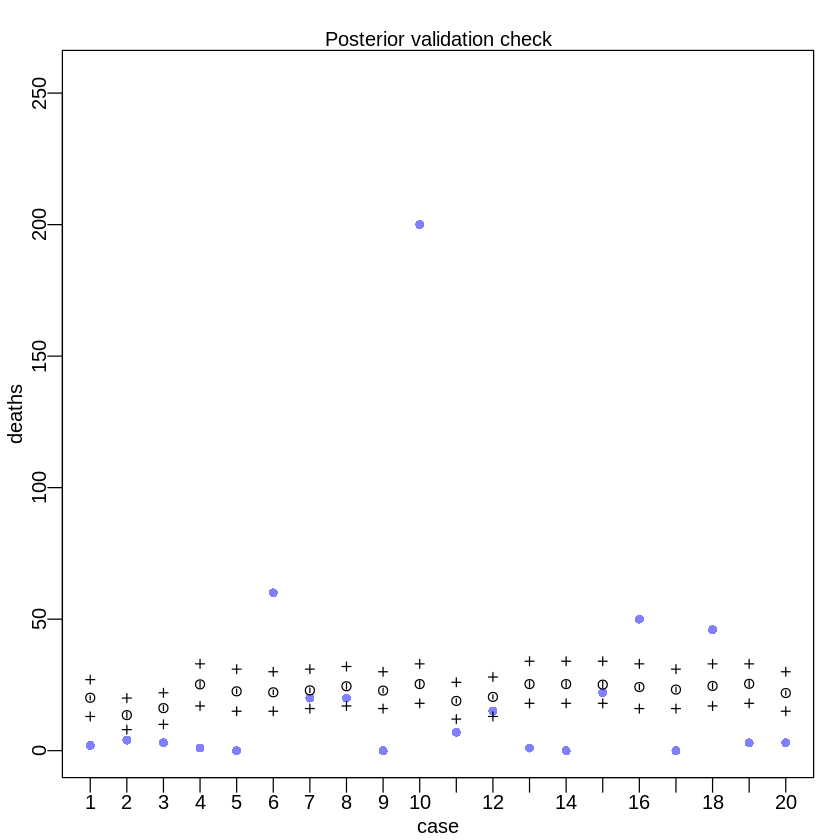

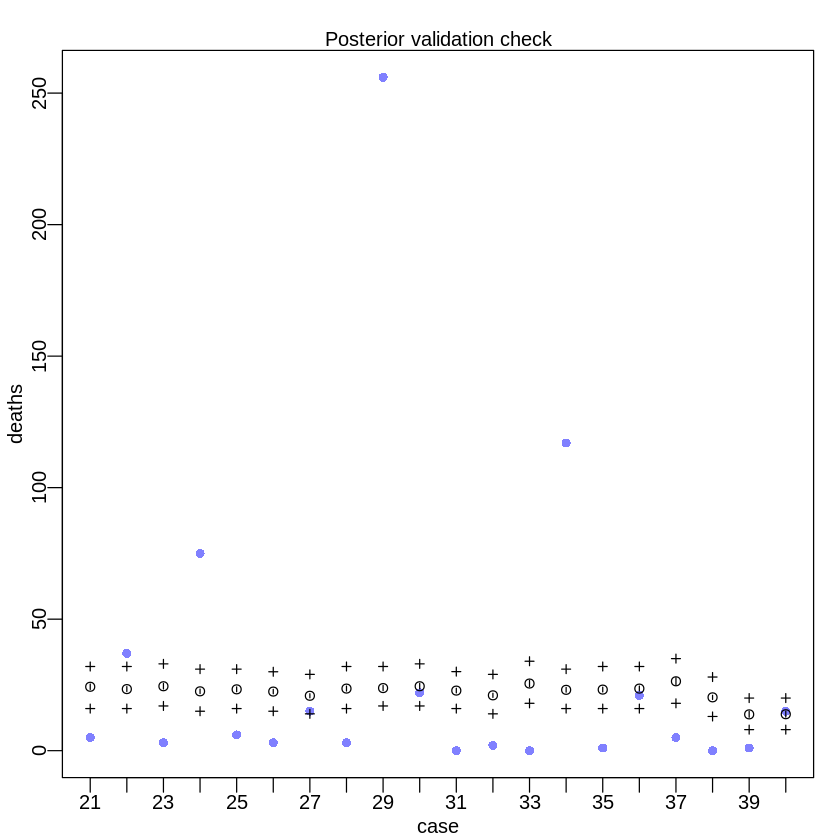

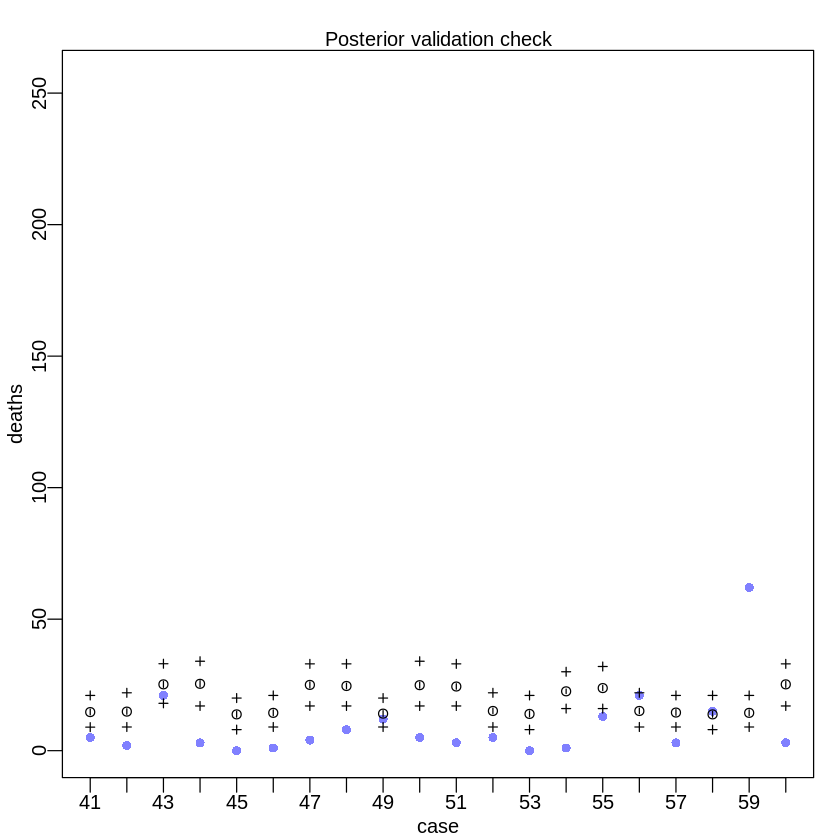

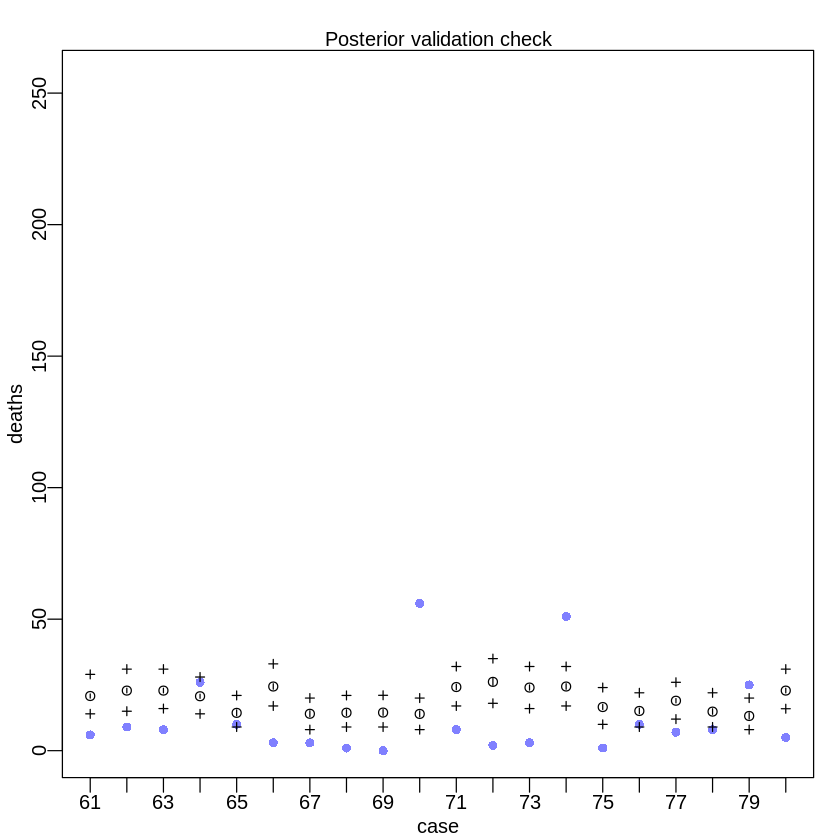

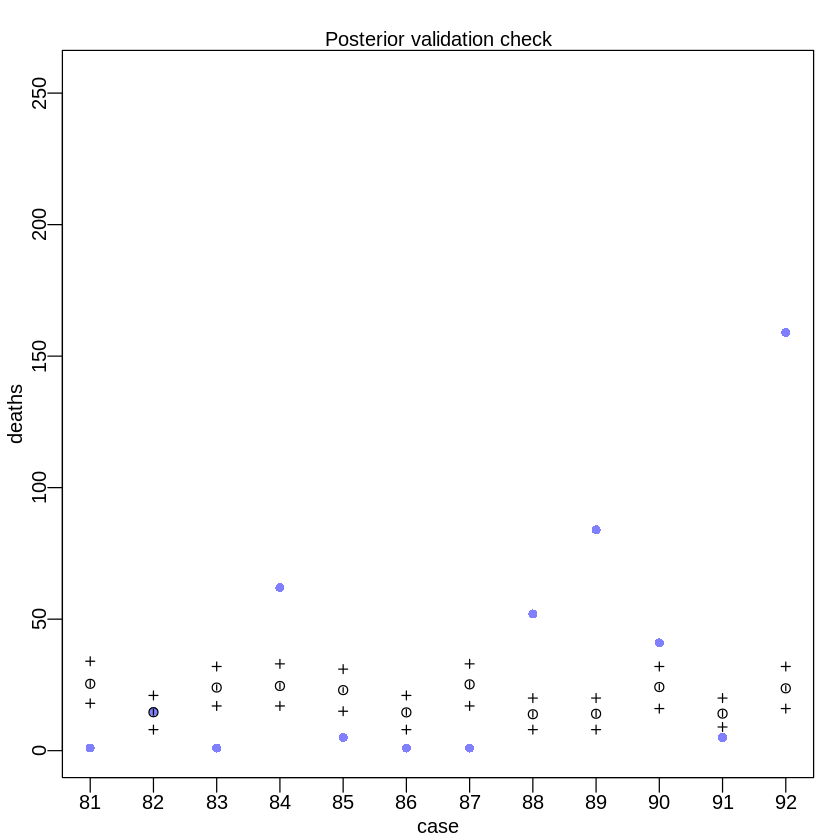

In [178]:
postcheck(m11h1)

In [215]:
k <- LOOPk(m11h1)
d$k <- k

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”

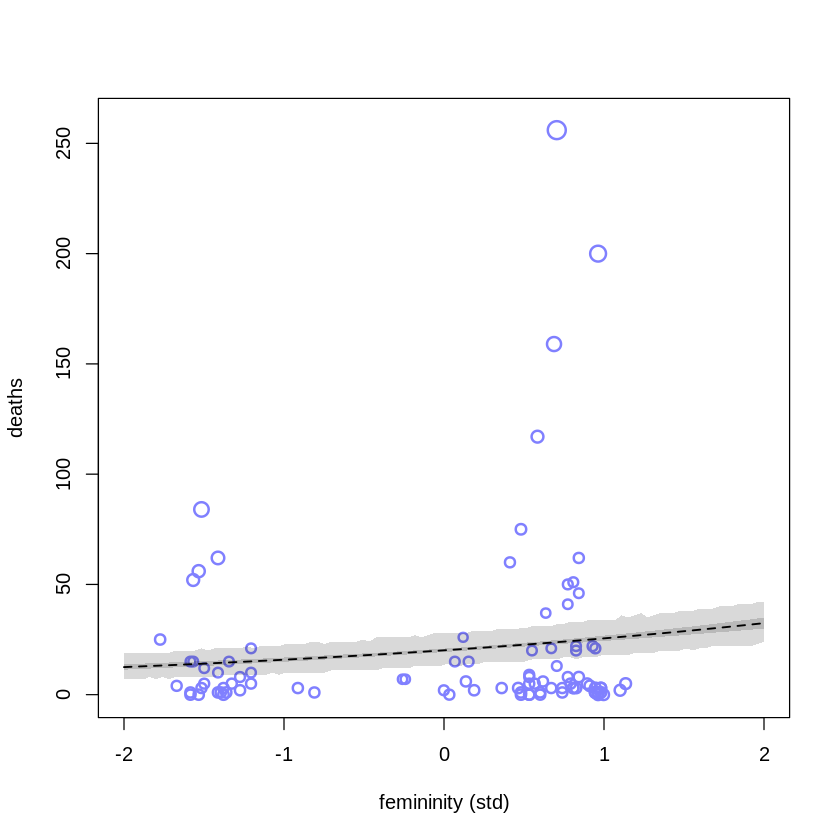

In [201]:
# set up the horizontal axis values to compute predictions at
ns <- 100
f_seq <- seq( from=-2 , to=2 , length.out=ns )

plot( dat2$f_std , dat2$deaths , xlab="femininity (std)" , ylab="deaths" ,
col=rangi2 , pch=1 , lwd=2 , xlim=range(f_seq),
ylim=c(0,260) , cex=1+normalize(k) )

lambda <- link( m11h1 , data=data.frame( f_std=f_seq ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines(f_seq , lmu , lty=2 , lwd=1.5 )
shade(lci , f_seq , xpd=TRUE )

pred_deaths <- sim( m11h1 , data=data.frame( f_std=f_seq ) )
# mean_pred_deaths <- apply( pred_deaths , 2 , mean )
ci_pred_deaths <- apply( pred_deaths , 2 , PI )
# lines(f_seq , mean_pred_deaths , lty=2 , lwd=1.5 )
shade(ci_pred_deaths , f_seq , xpd=TRUE )

Unsurprisingly, 2 clusters appear in the data.  The ones on the left (around femininity(std) values < 0) most likely have male sounding names, and those above 0 having female sounding names.  The upward sloping relationship between deaths and femininity seem to be largely influenced by 4 data points, those of deaths > 100, all of which had female sounding names.  This is a very small number of data points (4/92 of the sample) to come to the conclusion that female names cause more deaths.  There also appears to be more data points with femininity_std > 0, so more opportunities for deaths to occur (60 out of 92, so almost two-thirds of the data).  The slop is rather small, compared to the variation in the data.  Using sim() to make simulated death counts, we see that merely using the femininity of the name of the hurricane does a poor job of explaining the deaths.  The least explained deaths are those above the (outer) shaded grey area, showing that large death counts are poorly explained, with the larger the worst.  The pareto-k statistic is used to create the size (diameter) of the data points, and it is clear that the larger counts have the worst (largest) pareto-k statistics.

In [195]:
sum(dat2$f_std>0)

[1] 60

In [216]:
head(d[order(d$death, decreasing=TRUE),])

name    year deaths category min_pressure damage_norm female femininity
29 Camille 1969 256    5        909          23040       1      9.05556   
10 Diane   1955 200    1        987          14730       1      9.88889   
92 Sandy   2012 159    2        942          75000       1      9.00000   
34 Agnes   1972 117    1        980          20430       1      8.66667   
89 Ike     2008  84    2        950          20370       0      1.88889   
24 Betsy   1965  75    3        948          20000       1      8.33333   
   k        
29 2.0792744
10 1.5699943
92 1.1412637
34 0.6060128
89 1.2371174
24 0.2791893

So the top four outlier hurricanes (in terms of deaths) all have female names and are Camille, Diane, Sandy and Agnes.  In terms of Pareto-k statistics:

In [218]:
head(d[order(d$k, decreasing=TRUE),])

name    year deaths category min_pressure damage_norm female femininity
29 Camille 1969 256    5        909          23040       1      9.05556   
10 Diane   1955 200    1        987          14730       1      9.88889   
89 Ike     2008  84    2        950          20370       0      1.88889   
92 Sandy   2012 159    2        942          75000       1      9.00000   
59 Andrew  1992  62    5        922          66730       0      2.22222   
70 Floyd   1999  56    2        956           8130       0      1.83333   
   k        
29 2.0792744
10 1.5699943
89 1.2371174
92 1.1412637
59 0.7781408
70 0.6775257

So 3 of the top 4 k stats come from hurricanes with female names.  Note that k-stats are generally acceptable < 0.7, so only the top 5 are above this threshold, with 3 of them female.

In [220]:
head(d[order(d$damage_norm, decreasing=TRUE),])

name   year deaths category min_pressure damage_norm female femininity
92 Sandy  2012 159    2        942          75000       1      9.00000   
59 Andrew 1992  62    5        922          66730       0      2.22222   
16 Donna  1960  50    4        930          53270       1      9.27778   
85 Wilma  2005   5    3        950          25960       1      8.61111   
8  Hazel  1954  20    4        938          24260       1      9.44444   
91 Isaac  2012   5    1        966          24000       0      1.94444   
   k         
92 1.14126365
59 0.77814080
16 0.11584282
85 0.14258668
8  0.09968744
91 0.13857555

The fact that the most deaths came from old hurricanes (with female names) from the 1950s-60s, despite having quite modest 'damage_norm' variables suggests a lot of these deaths could have been preventable today with modern hurricane preparation...?

In [224]:
compare(m11h1int, m11h1)

WAIC     pWAIC     dWAIC    weight       SE        dSE    
m11h1    4404.070 129.16972  0.00000 1.000000e+00  994.6486      NA
m11h1int 4444.865  76.19525 40.79439 1.385515e-09 1073.8052 143.871

The dSE is greater than dWAIC, so the models are indistinguishable from a predictive point of view, suggesting that the femininity of the name of the hurricane is not a useful predictor of deaths.

11H2

In [244]:
# dd <- d[ complete.cases(d), ]
# dat2 <- list(deaths=dd$deaths, f_std=standardize(d$femininity))

m11h2 <- ulam(
                alist(
                    deaths ~ dgampois(lamda, phi) ,
                    phi ~ dexp(1) ,
                    log(lamda) <- a + bF * f_std,
                    a ~ dnorm(2, 1) ,               
                    bF ~ dnorm( 0, 1 )    # max deaths is 256
                ), data=dat2, chains=4, cores=4
                , log_lik=TRUE
            )

recompiling to avoid crashing R session


In [245]:
precis(m11h2)

mean      sd         5.5%        94.5%     n_eff    Rhat     
phi 0.4528295 0.06171264  0.35930382 0.5565285 1884.528 1.0006083
a   3.0027103 0.15330316  2.75560838 3.2489429 2109.244 0.9999228
bF  0.2067392 0.15738359 -0.03893834 0.4421616 1639.305 0.9986844

In [241]:
compare(m11h1int, m11h1, m11h2)

WAIC      pWAIC      dWAIC    weight SE         dSE      
m11h2     709.3987   3.451796    0.000 1        31.70038        NA
m11h1    4404.0703 129.169718 3694.672 0       994.64857  978.8088
m11h1int 4444.8647  76.195255 3735.466 0      1073.80523 1058.8837

The gamma-poisson model m11h2 does a much better job of prediction, and even has fewer effective parameters.  The coefficient bF has a 89% compatible interval covering 0 and negative parameters, so it's a lot less certain whether there is such a positive association between femininity of name and number of deaths.  The diminished association between deaths and hurricanes is probably caused by the increased uncertainty in the values of lambda that fit the data, hence the increased uncertainty in a and bF.

From https://github.com/cavaunpeu/statistical-rethinking/blob/master/chapter-11/homework.R:

"why did the association between `beta_femininity` and `deaths` diminish in strength?

I assume this is because a much larger range of values of `(alpha, beta_femininity)` can produce, through the Gamma distribution, the same expected values `lambda` via the variance in the Gamma process itself."

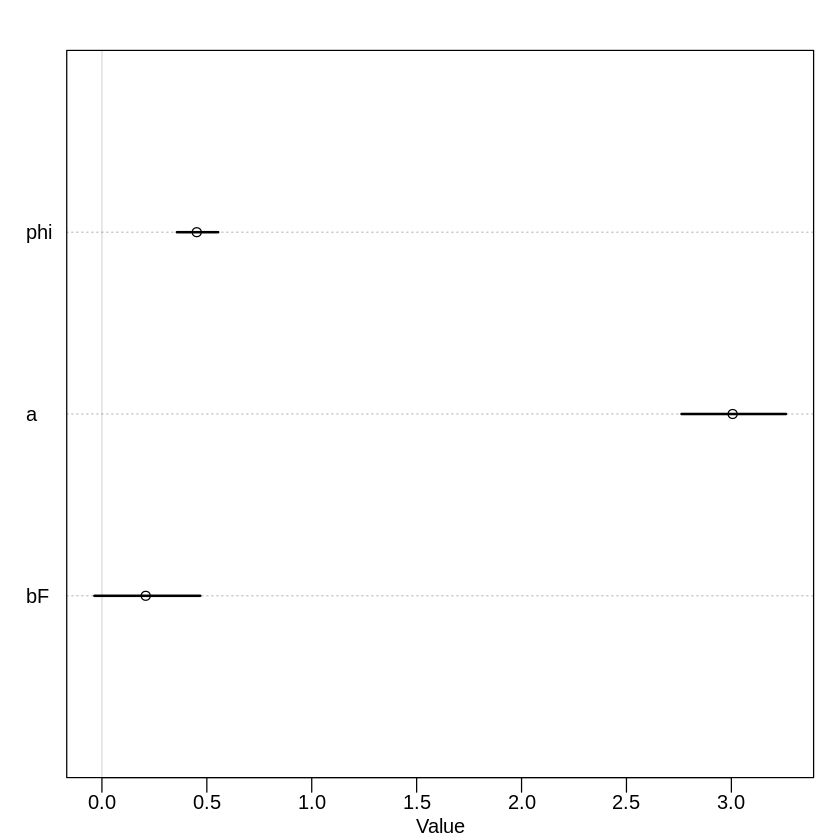

In [231]:
plot(precis(m11h2))

In [232]:
post <- extract.samples(m11h2)
# lambda <- exp( post$a + post$bF * range(-2:2))
# plot( precis( as.data.frame(lambda) ) , xlim=c(0,100) )
post

$phi
   [1] 0.4941532 0.5153721 0.5054879 0.3297492 0.4012420 0.4410837 0.3835505
   [8] 0.4828791 0.4777493 0.4205241 0.4838139 0.4035727 0.3623082 0.3588064
  [15] 0.4264958 0.5008358 0.4636027 0.4639675 0.4800867 0.3353136 0.4131332
  [22] 0.4083781 0.4135426 0.5267904 0.3728602 0.4751622 0.4832976 0.4216231
  [29] 0.4371374 0.4190246 0.4299209 0.3929126 0.5473305 0.4033381 0.4192001
  [36] 0.5218780 0.5025560 0.4884658 0.4067383 0.4177933 0.3678318 0.4445880
  [43] 0.4801282 0.4487572 0.4597857 0.4422056 0.3872331 0.4479615 0.4840480
  [50] 0.4582266 0.4004992 0.5398714 0.3485095 0.3385715 0.4624264 0.4451892
  [57] 0.5190368 0.4483821 0.3262450 0.5213035 0.4674886 0.2984256 0.5005526
  [64] 0.5143973 0.3784084 0.3786960 0.4295932 0.4636022 0.4287356 0.4565943
  [71] 0.3512088 0.5429682 0.3430926 0.4116554 0.4050468 0.4667491 0.4424441
  [78] 0.3876043 0.3775404 0.4457666 0.4727594 0.3396938 0.4294681 0.4504511
  [85] 0.3855597 0.4709145 0.4510506 0.5107504 0.4002580 0.4734119 0.6848900
  [92] 0.3977441 0.4591148 0.4470537 0.6024751 0.5193616 0.4323179 0.4618901
  [99] 0.4584900 0.5537439 0.3587689 0.4592347 0.4503280 0.5613045 0.5566847
 [106] 0.4857411 0.3975090 0.4654883 0.5659871 0.4306713 0.4820816 0.4250127
 [113] 0.3708183 0.5206295 0.4953575 0.6372578 0.5023570 0.3919908 0.4233441
 [120] 0.5449662 0.4831164 0.4373504 0.4690258 0.4195294 0.5289769 0.5888222
 [127] 0.4779645 0.4384643 0.4212174 0.3529183 0.4999782 0.4847578 0.5611256
 [134] 0.4657097 0.4717536 0.4333082 0.3459317 0.6198842 0.4219333 0.4510759
 [141] 0.4034495 0.4197135 0.5235410 0.4864630 0.4230528 0.4657663 0.5954615
 [148] 0.5712167 0.4181176 0.4630655 0.4795303 0.5999375 0.3601389 0.6078028
 [155] 0.4404784 0.5767560 0.3962297 0.4157386 0.4474442 0.4399206 0.4351093
 [162] 0.4422813 0.4892699 0.5113126 0.4236899 0.4480078 0.4244694 0.4475529
 [169] 0.5008920 0.3550691 0.5095533 0.4968894 0.3311439 0.4873957 0.6110047
 [176] 0.4118828 0.5118348 0.4632992 0.3787052 0.4965571 0.3593905 0.3806956
 [183] 0.4804091 0.3959802 0.3992778 0.4694595 0.4391085 0.4964604 0.4116568
 [190] 0.5536348 0.4435800 0.3810850 0.4424703 0.4718360 0.4776025 0.4754656
 [197] 0.5713192 0.5092245 0.5122408 0.4897187 0.4871353 0.4240865 0.3793261
 [204] 0.5175238 0.4060201 0.4447513 0.4660317 0.3977762 0.3307752 0.4116895
 [211] 0.4618610 0.4796157 0.4202294 0.4062188 0.3687144 0.4834903 0.4037269
 [218] 0.4153742 0.4592971 0.4269463 0.3989282 0.3887305 0.5194635 0.4643259
 [225] 0.4447603 0.3747344 0.4557831 0.4765781 0.4241191 0.4869455 0.4662988
 [232] 0.4409668 0.4019472 0.5859036 0.4935946 0.4694175 0.3977449 0.4337816
 [239] 0.5430427 0.4493096 0.5230853 0.4098204 0.4649487 0.4379165 0.3637712
 [246] 0.3696343 0.5649288 0.4905494 0.5341682 0.4341513 0.4917556 0.5024216
 [253] 0.5392256 0.6221765 0.4910879 0.4602963 0.3652392 0.5426497 0.5244167
 [260] 0.3645827 0.4863955 0.4963792 0.4332771 0.5303301 0.3655892 0.3991558
 [267] 0.3835643 0.5568428 0.4859985 0.4019373 0.4166249 0.4722894 0.3172604
 [274] 0.6448663 0.5493994 0.5455441 0.5787656 0.4662131 0.5041141 0.3718880
 [281] 0.3572411 0.4588611 0.5292353 0.3919820 0.4749751 0.3799987 0.5471252
 [288] 0.3817544 0.4190931 0.3818827 0.5638500 0.4396590 0.4220046 0.5367573
 [295] 0.4366204 0.4345051 0.3310510 0.5237785 0.4404974 0.5507054 0.3957557
 [302] 0.3938267 0.3941145 0.4631602 0.4832034 0.3743266 0.4707459 0.5211037
 [309] 0.5121278 0.5209710 0.3385923 0.6288331 0.4994738 0.4351729 0.4165079
 [316] 0.5743133 0.4247645 0.3874054 0.4558486 0.4652004 0.5067872 0.3427312
 [323] 0.5311676 0.4868976 0.4427049 0.4123780 0.4330905 0.5082048 0.5097434
 [330] 0.4010479 0.3890263 0.4449951 0.4741940 0.4411432 0.4493582 0.5381552
 [337] 0.4616858 0.4179162 0.4555975 0.5015362 0.4484670 0.6112390 0.4992865
 [344] 0.4672646 0.4659958 0.4865123 0.4464095 0.3652887 0.4031719 0.5062680
 [351] 0.3586221 0.4002023 0.4217200 0.5035456 0.4007821 0.4888798 0.3844815
 [358] 0.4242708 0.3440597 0.4698964 0.3935542 0.5099911 0.5524689 0

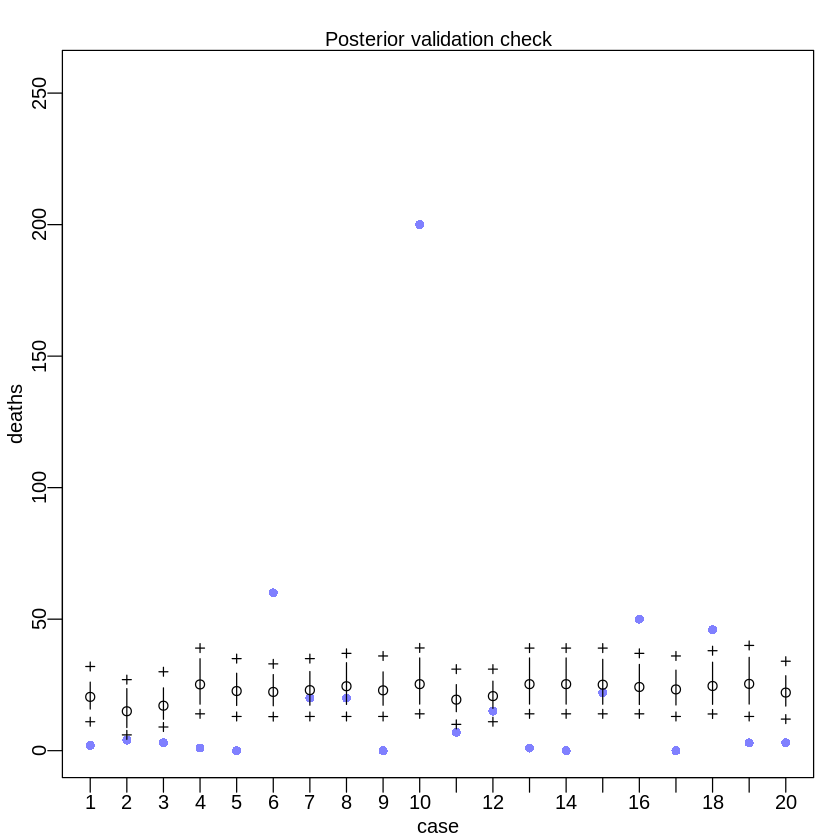

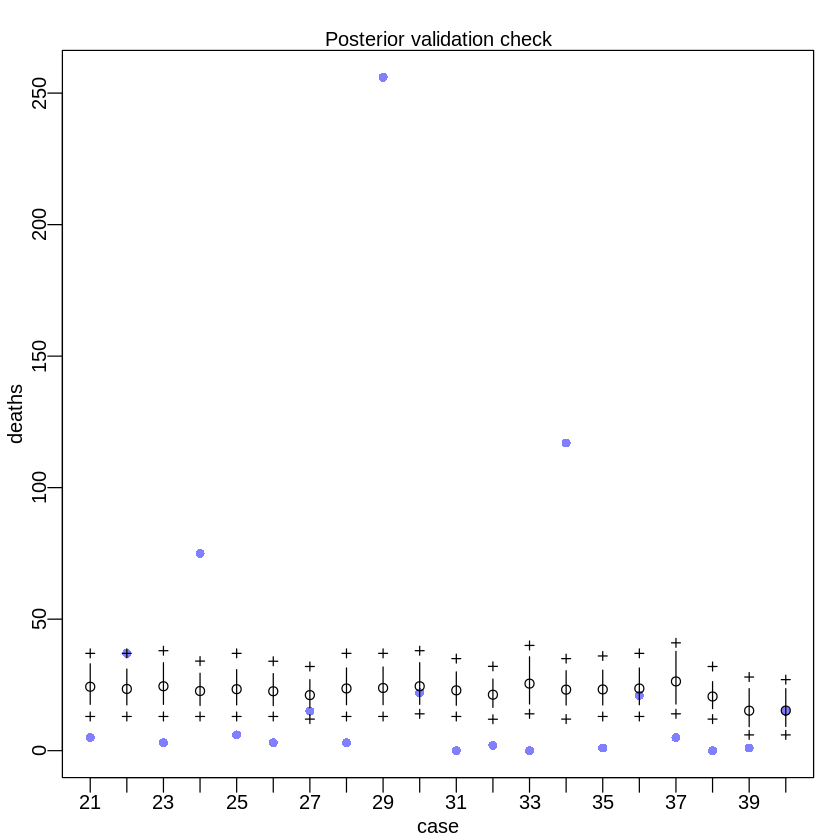

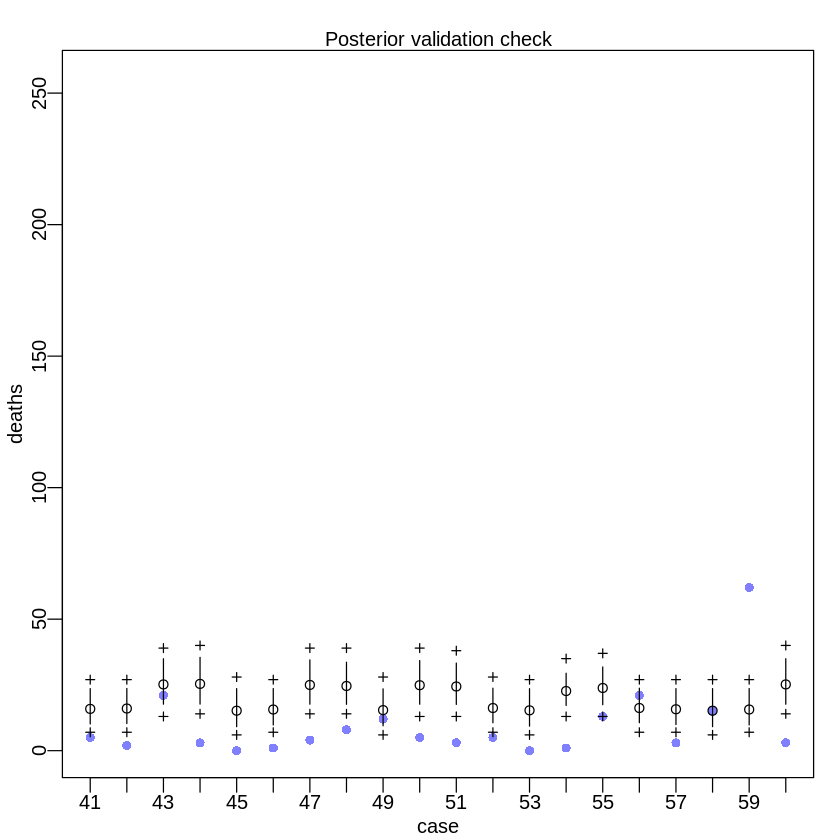

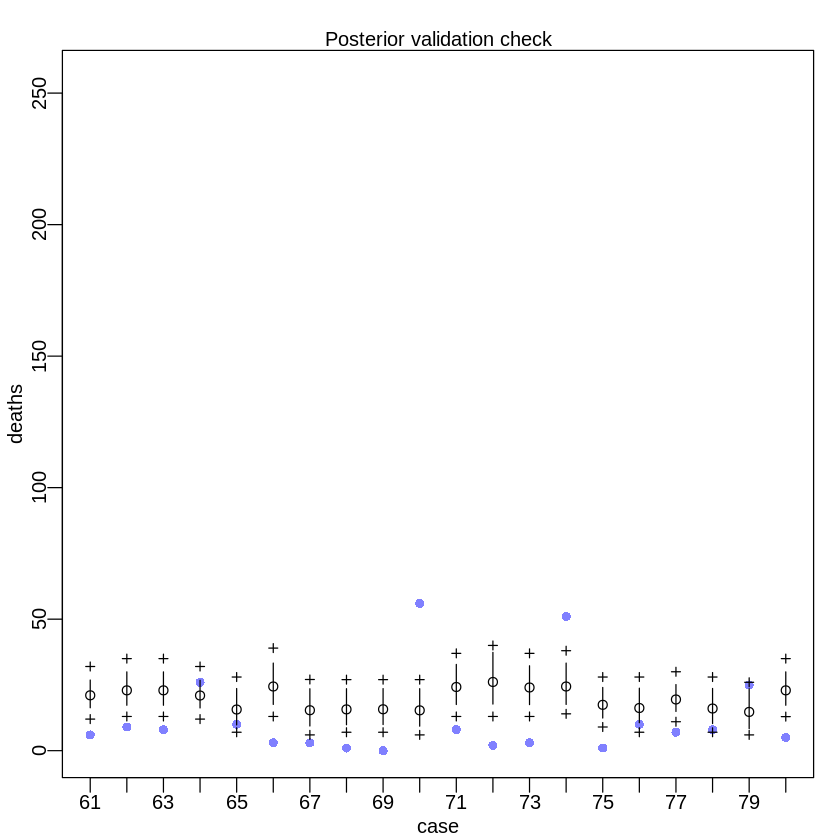

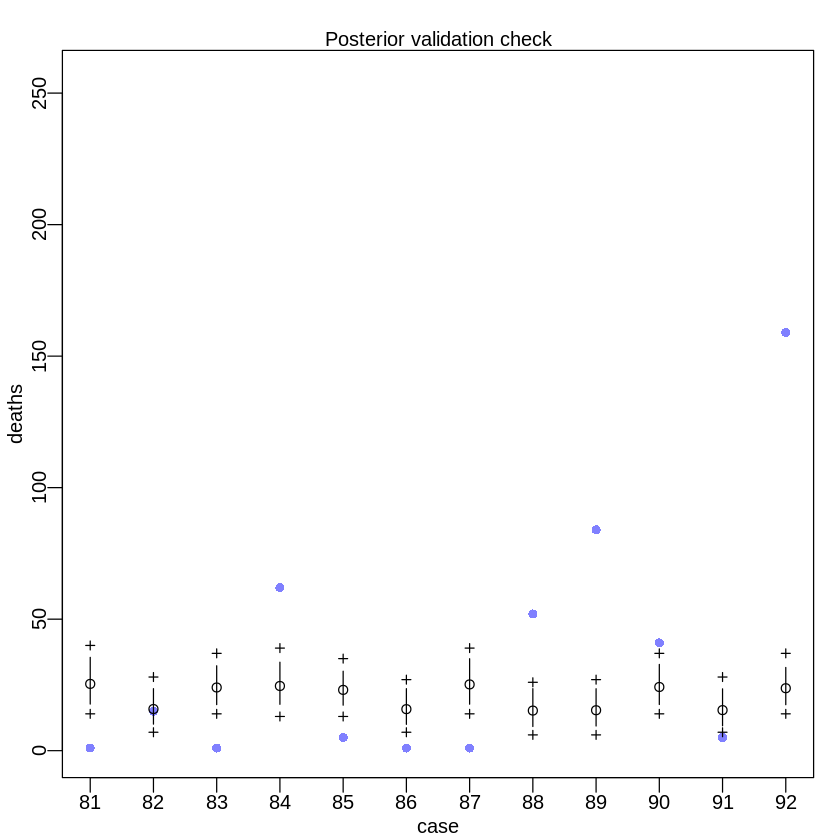

In [234]:
postcheck(m11h2)

In [236]:
k2 <- LOOPk(m11h2)
d$k2 <- k2
k2

[1] -0.0822204676 -0.1487246113 -0.1141617969 -0.0010135165  0.0452923110
 [6] -0.0633539352 -0.0142481187 -0.0887935394  0.0291200151  0.3797323822
[11] -0.0393607623  0.0090936388  0.0082638345  0.0554508094 -0.0560451883
[16]  0.0263738898  0.0462460535  0.0293930269 -0.0363363159 -0.0239538784
[21] -0.1315420264 -0.0773523371 -0.0173561601 -0.0641983457 -0.1347219038
[26] -0.0834767153 -0.0067029608 -0.0955029340  0.3801774399 -0.0371946012
[31]  0.0291200151 -0.0861554990  0.0379160770  0.0469290125 -0.0515908235
[36] -0.0117772133 -0.0600526185  0.0471620148  0.0389160152  0.0356245136
[41] -0.0771137260 -0.0243799231 -0.0802619738 -0.0363363159 -0.0417597946
[46]  0.0091655477 -0.0784512123 -0.0772559410  0.0589848570 -0.1118127952
[51] -0.0292087930 -0.0600251999 -0.0444508828 -0.0293355705 -0.0313648689
[56] -0.0221787580 -0.1612491228  0.0290711801  0.3474701931 -0.0394068316
[61] -0.0855936291 -0.0605552134 -0.0672848456 -0.0636721657  0.0341319504
[66] -0.0292087930 -0.1351773000  0.0052248680 -0.0490736326  0.2601572870
[71] -0.0597842676  0.0272009313 -0.0744754123  0.0072724671 -0.1187281085
[76]  0.0561239001 -0.0372978857  0.0381755034  0.0909445727 -0.1049750534
[81]  0.0012070214 -0.0320116536  0.0005908991  0.0564705413 -0.1133406792
[86] -0.0025716267 -0.0010135165  0.2508584587  0.3658287828 -0.0130742994
[91] -0.0997736890  0.1619007686

In [242]:
max(k2)

[1] 0.3801774

All pareto-k statistics for m11h2 are acceptable.

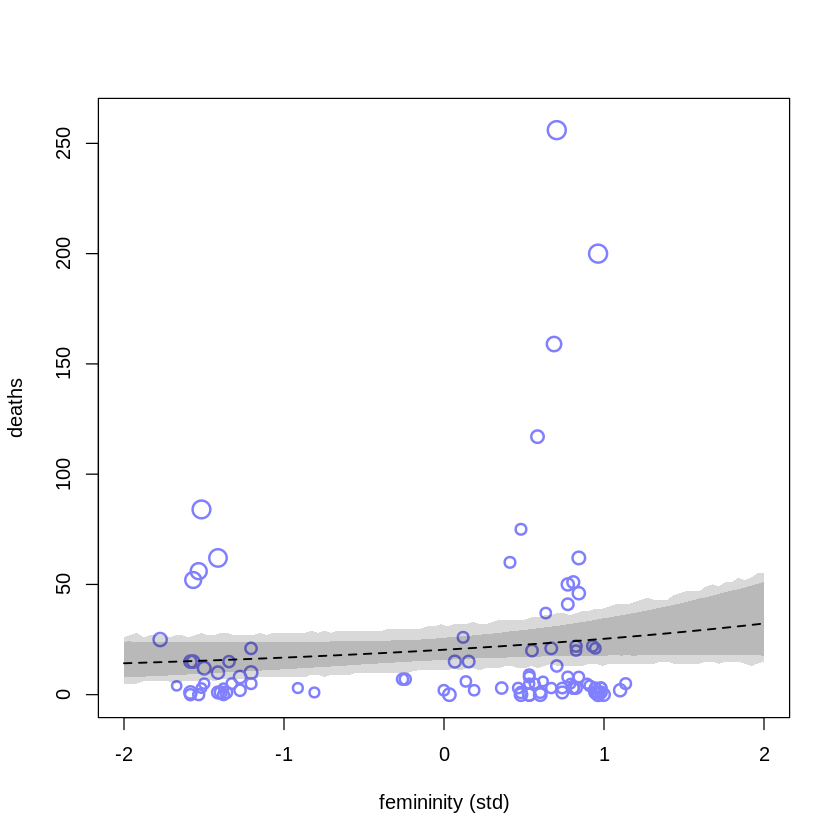

In [246]:
# set up the horizontal axis values to compute predictions at
ns <- 100
f_seq <- seq( from=-2 , to=2 , length.out=ns )

plot( dat2$f_std , dat2$deaths , xlab="femininity (std)" , ylab="deaths" ,
col=rangi2 , pch=1 , lwd=2 , xlim=range(f_seq),
ylim=c(0,260) , cex=1+normalize(k2) )

lambda <- link( m11h2 , data=data.frame( f_std=f_seq ) )
lmu <- apply( lambda , 2 , mean )
lci <- apply( lambda , 2 , PI )
lines(f_seq , lmu , lty=2 , lwd=1.5 )
shade(lci , f_seq , xpd=TRUE )

pred_deaths <- sim( m11h2 , data=data.frame( f_std=f_seq ) )
# mean_pred_deaths <- apply( pred_deaths , 2 , mean )
ci_pred_deaths <- apply( pred_deaths , 2 , PI )
# lines(f_seq , mean_pred_deaths , lty=2 , lwd=1.5 )
shade(ci_pred_deaths , f_seq , xpd=TRUE )

Now the shaded region of 89% of lambda is much larger than in m11h1.  The simulated deaths are also a wider shaded region with higher values.

11H3

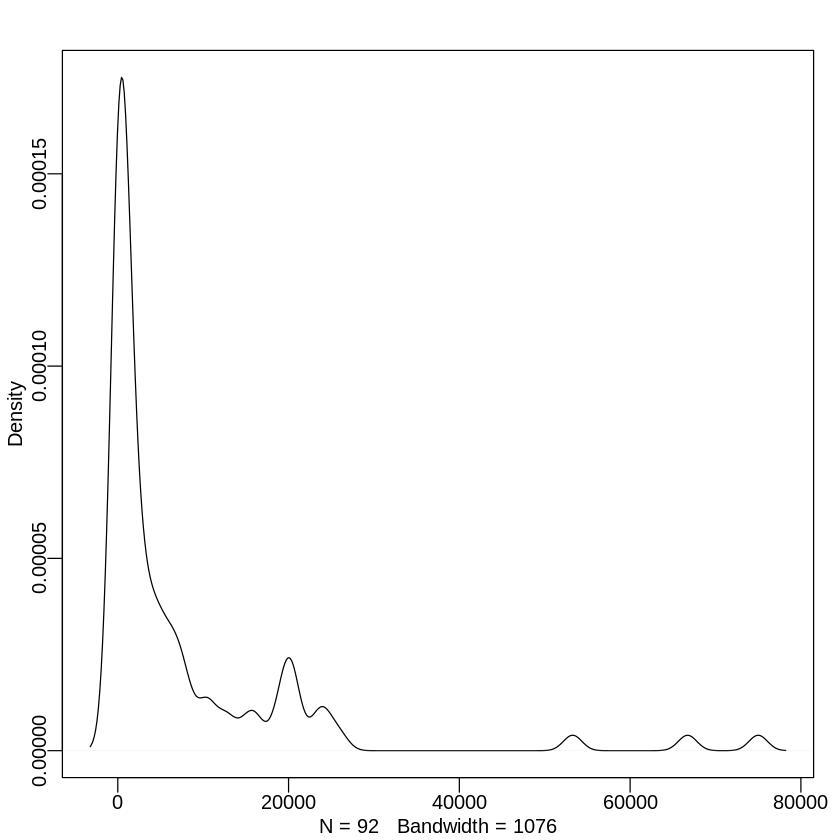

In [255]:
dens(d$damage_norm)

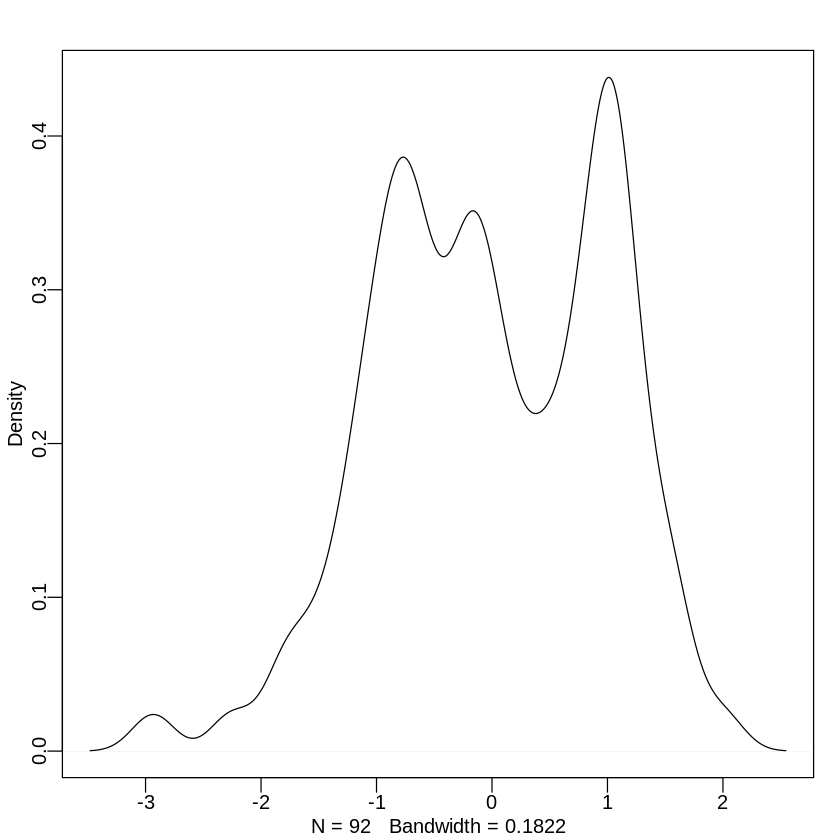

In [258]:
dens(standardize(d$min_pressure))

In [69]:
dat3 <- list(deaths=d$deaths, f_std=standardize(d$femininity), D_norm=normalize(d$damage_norm))

In [277]:
m11h3mainEffDAM <- ulam(
                alist(
                    deaths ~ dpois(lamda) ,
                    log(lamda) <- a + bF * f_std + bD * D_norm ,
                    a ~ dnorm( 2, 1) ,               
                    bF ~ dnorm( 0, 1 ),    # max deaths is 256
                    bD ~ dnorm( 0, 2 )    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                ), data=dat3
                , chains=4, cores=4, log_lik=TRUE
            )

In [279]:
precis(m11h3mainEffDAM)

mean      sd         5.5%     94.5%     n_eff    Rhat     
a  2.5404922 0.02968239 2.493615 2.5885287 1138.492 1.0002404
bF 0.2534264 0.02537495 0.214059 0.2932639 1518.410 0.9999738
bD 2.7182898 0.06418122 2.616048 2.8227716 1082.664 0.9998387

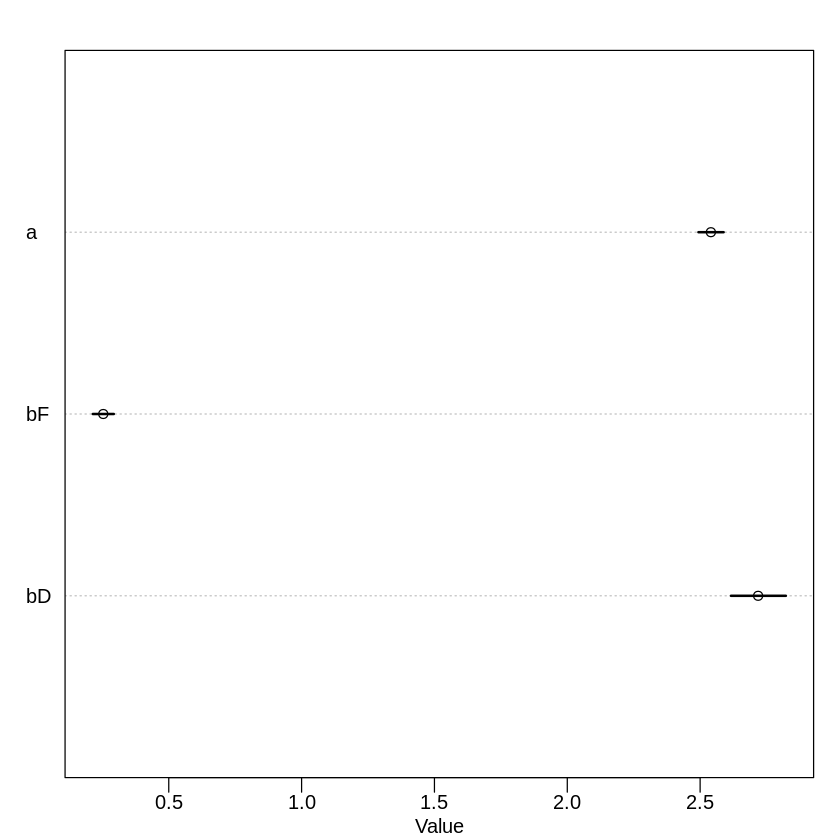

In [281]:
plot(precis(m11h3mainEffDAM))

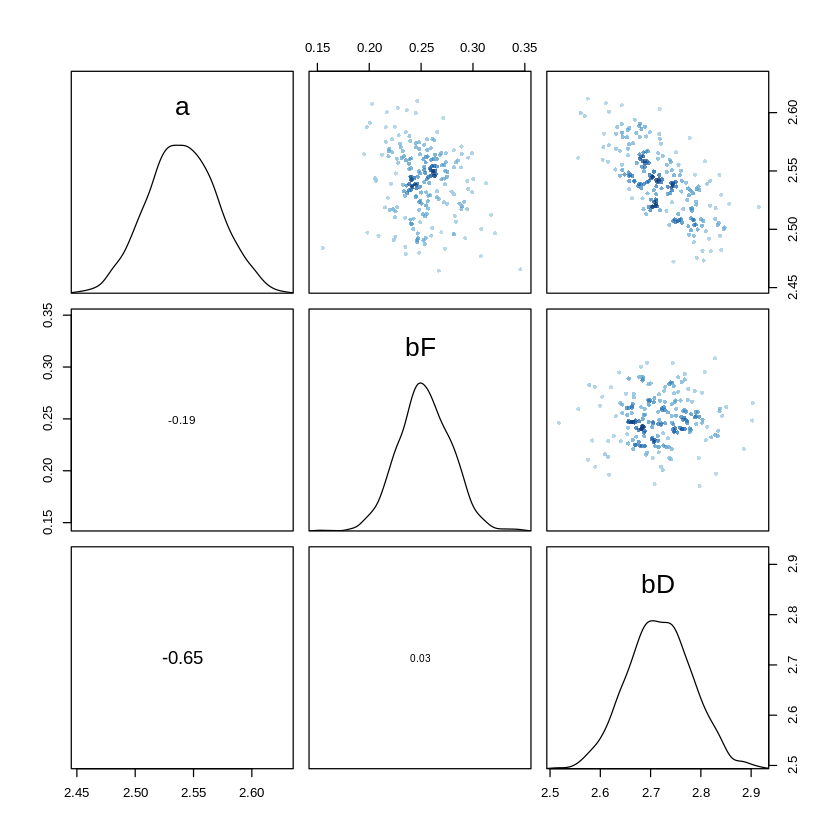

In [283]:
pairs(m11h3mainEffDAM)

In [295]:
m11h3intDAM <- ulam(
                alist(
                    deaths ~ dpois(lamda) ,
                    log(lamda) <- a + bF * f_std + bD * D_norm + bFD * ( f_std * D_norm ),
                    a ~ dnorm( 2, 1) ,               
                    bF ~ dnorm( 0, 1 ),    # max deaths is 256
                    bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                    bFD ~ dnorm( 0, 0.2 )
                ), data=dat3
                , chains=4, cores=4, log_lik=TRUE
            )

recompiling to avoid crashing R session


In [296]:
precis(m11h3intDAM)

mean      sd         5.5%       94.5%     n_eff    Rhat     
a   2.5542418 0.03000441 2.50722083 2.6022242 1132.063 0.9994436
bF  0.2071732 0.03144312 0.15668733 0.2581993 1387.104 1.0025212
bD  2.6689172 0.06830985 2.56374812 2.7786640 1149.656 1.0004214
bFD 0.1716342 0.07143065 0.06072583 0.2835692 1165.240 1.0002277

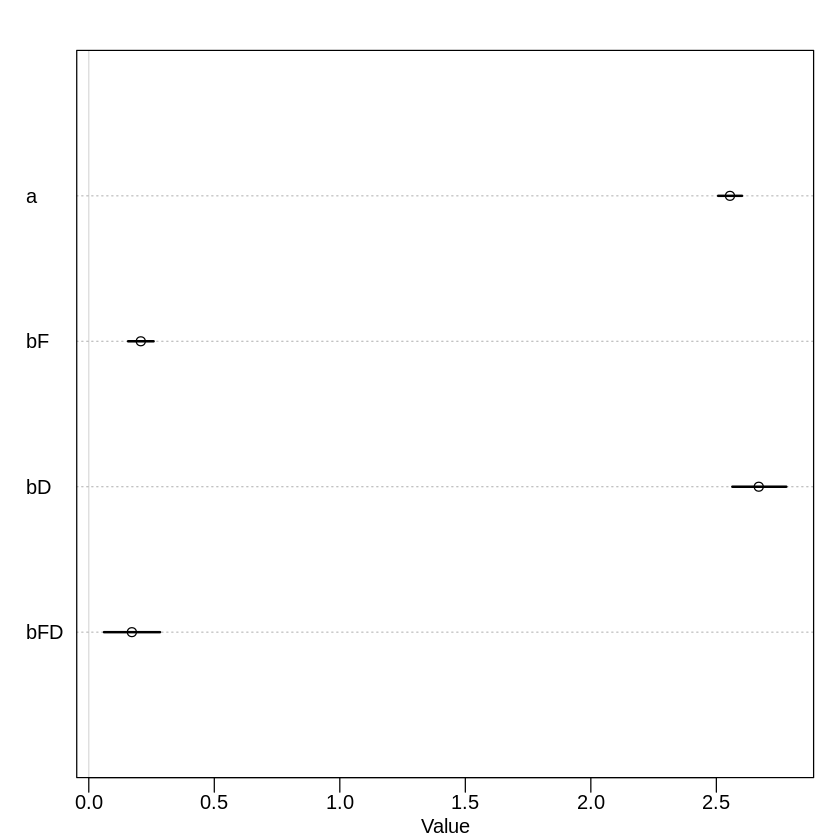

In [297]:
plot(precis(m11h3intDAM))

In [274]:
m11h3gamMainEffDAM <- ulam(
                alist(
                    deaths ~ dgampois(lamda, phi) ,
                    phi ~ dexp(1) ,
                    log(lamda) <- a + bF * f_std + bD * D_norm ,
                    a ~ dnorm( 2, 1) ,               
                    bF ~ dnorm( 0, 1 ),    # max deaths is 256
                    bD ~ dnorm( 0, 2 )    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                ), data=dat3
                , chains=4, cores=4, log_lik=TRUE
            )

In [275]:
precis(m11h3gamMainEffDAM)

mean      sd        5.5%        94.5%     n_eff    Rhat     
phi 0.6616265 0.1017574  0.50795205 0.8344974 1490.524 1.0012050
a   2.1127964 0.1820663  1.82314103 2.4040897 1099.302 1.0013702
bF  0.1215173 0.1319202 -0.08795871 0.3228636 1426.724 0.9995484
bD  5.2904494 1.0518279  3.62708424 6.9725928 1063.331 1.0002911

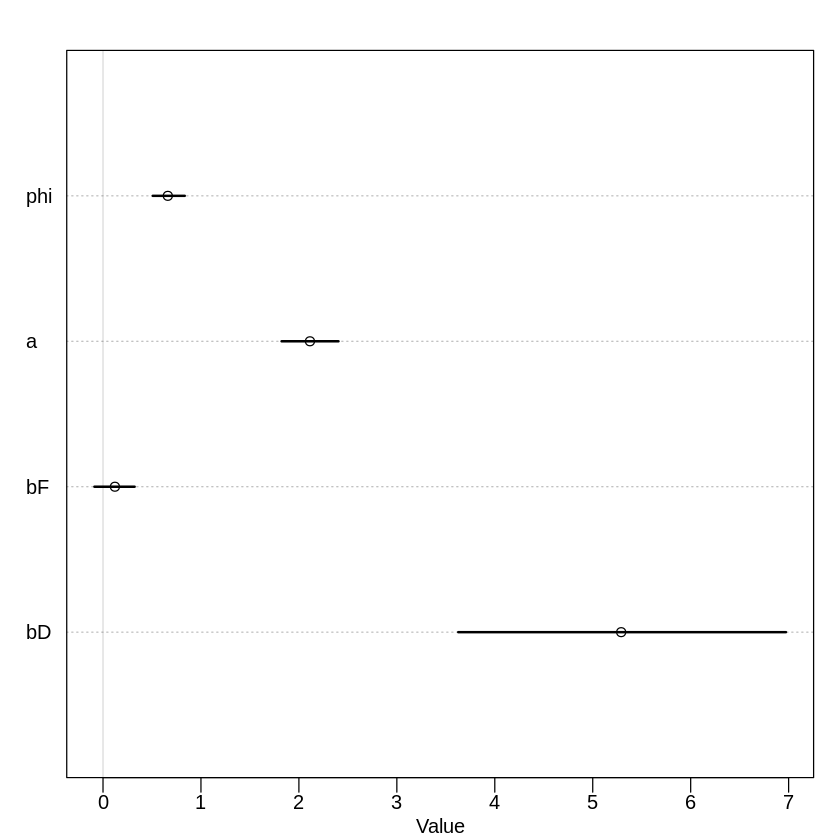

In [276]:
plot(precis(m11h3gamMainEffDAM))

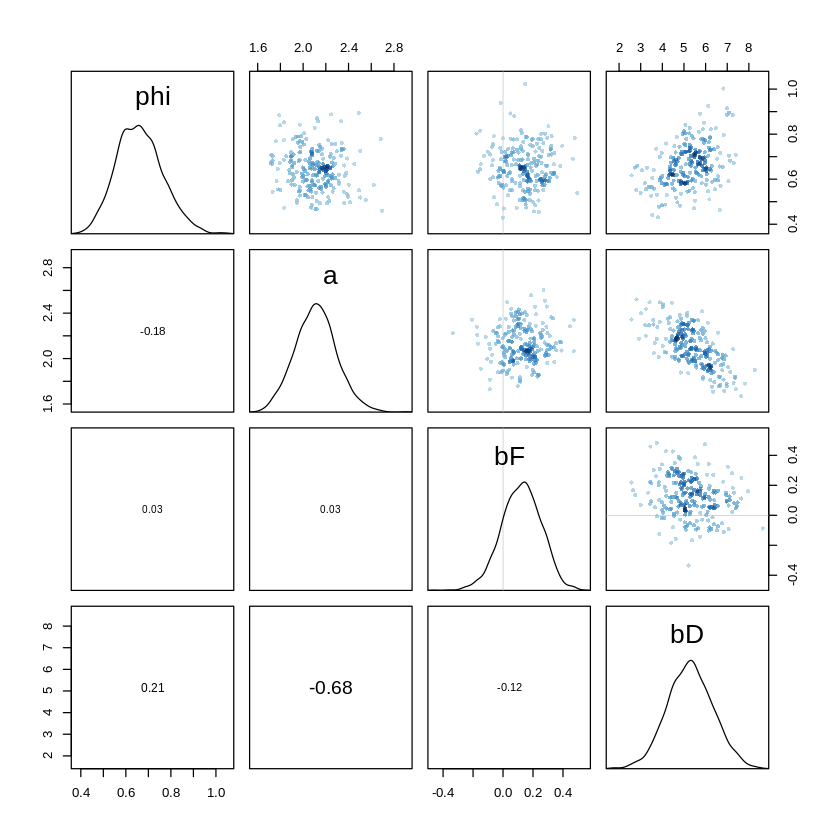

In [280]:
pairs(m11h3gamMainEffDAM)

In [70]:
m11h3gamIntDAM <- ulam(
                alist(
                    deaths ~ dgampois(lamda, phi) ,
                    log(lamda) <- a + bF * f_std + bD * D_norm + bFD * ( f_std * D_norm ),
                    a ~ dnorm( 2, 1) ,               
                    bF ~ dnorm( 0, 1 ),    # max deaths is 256
                    bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                    bFD ~ dnorm( 0, 0.2 ),
                    phi ~ dexp(1)
                ), data=dat3
                , chains=4, cores=4, log_lik=TRUE
            )

In [289]:
precis(m11h3gamIntDAM)

mean       sd        5.5%        94.5%     n_eff    Rhat     
a   2.10981955 0.1784786  1.82828130 2.3994420 1205.197 0.9986842
bF  0.11667156 0.1343220 -0.09220275 0.3285489 1948.235 0.9984750
bD  5.28336424 1.0052705  3.67888426 6.9282150 1072.054 0.9990545
bFD 0.04928838 0.1968338 -0.26389854 0.3628044 1873.153 1.0004223
phi 0.65914950 0.1027522  0.51010736 0.8295894 1470.071 1.0001288

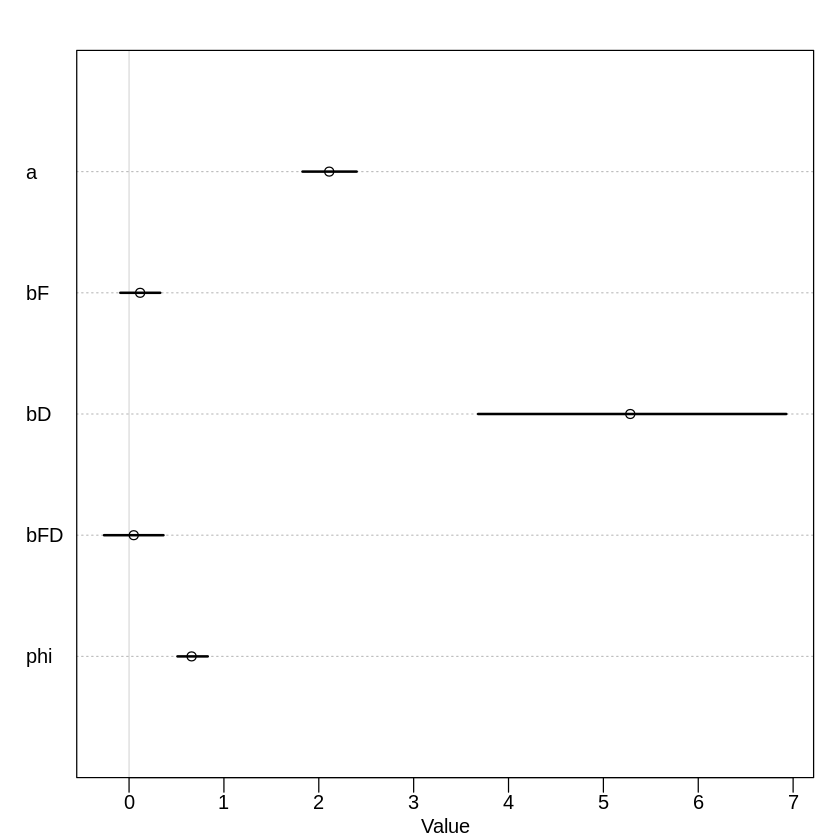

In [290]:
plot(precis(m11h3gamIntDAM))

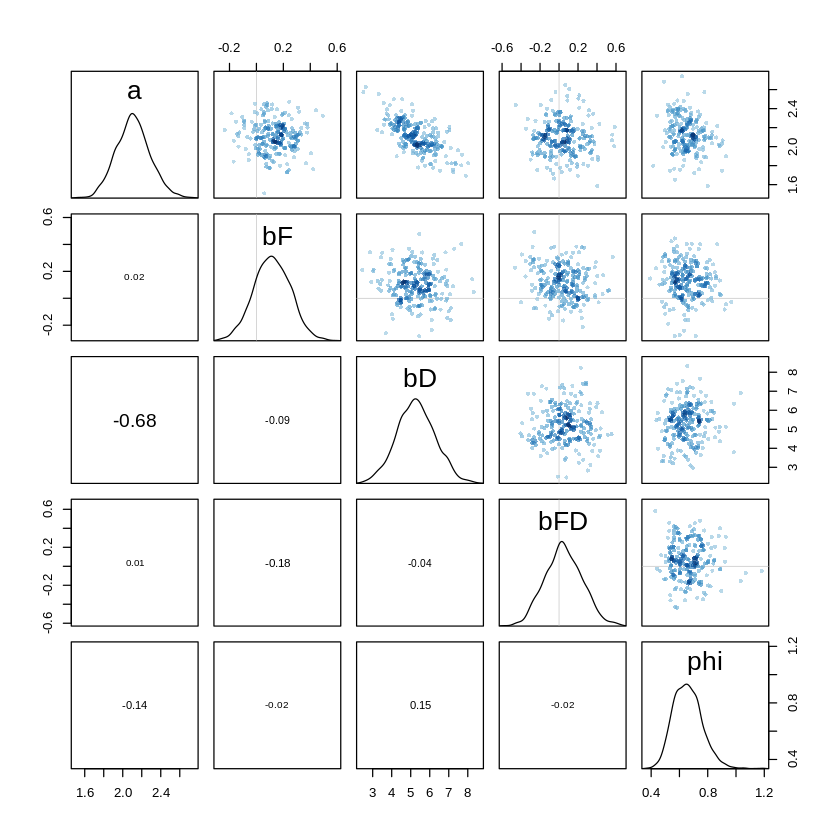

In [291]:
pairs(m11h3gamIntDAM)

In [76]:
dat4 <- list(deaths=d$deaths, f_std=standardize(d$femininity), minPres_std=standardize(d$min_pressure))

In [300]:


m11h3mainEffPRES <- ulam(
                        alist(
                            deaths ~ dpois(lamda) ,
                            log(lamda) <- a + bF * f_std + bP * minPres_std,
                            a ~ dnorm( 2, 1) ,               
                            bF ~ dnorm( 0, 1 ),    # max deaths is 256
                            bP ~ dnorm( 0, 1 )
                        ), data=dat4
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [301]:
precis(m11h3mainEffPRES)

mean       sd         5.5%       94.5%      n_eff    Rhat    
a   2.7362944 0.02835896  2.6909260  2.7821358 1124.945 1.000154
bF  0.2075684 0.02519001  0.1679403  0.2479861 1513.980 1.000499
bP -0.7144237 0.02074378 -0.7472171 -0.6816452 1214.614 1.000405

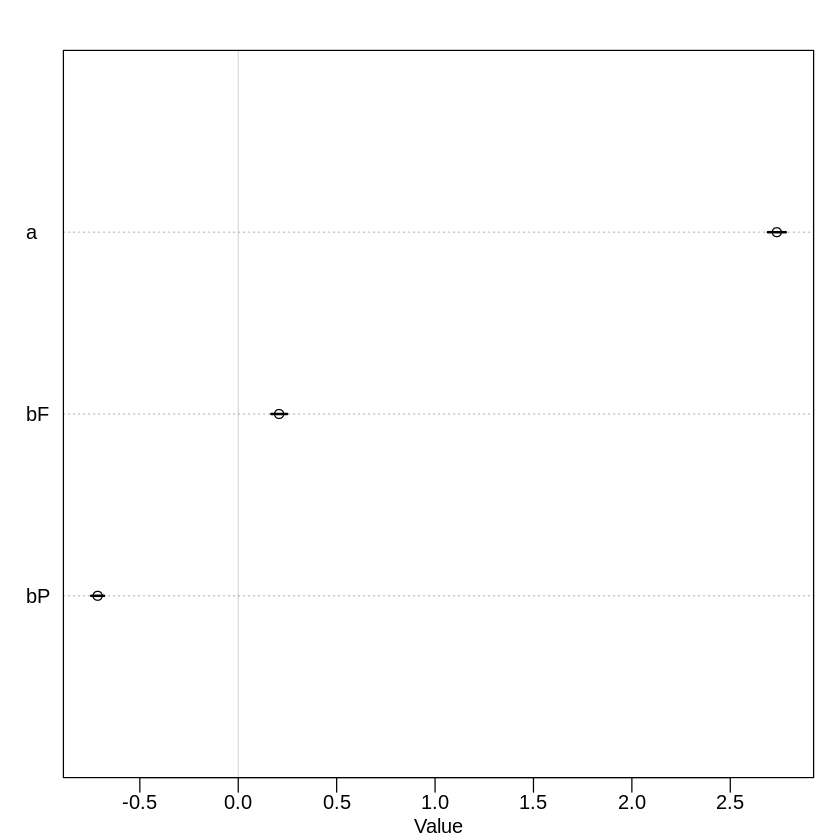

In [302]:
plot(precis(m11h3mainEffPRES))

Deaths increase as minimum pressure decreases (as expected, given the description in the data - see ?Hurricanes).

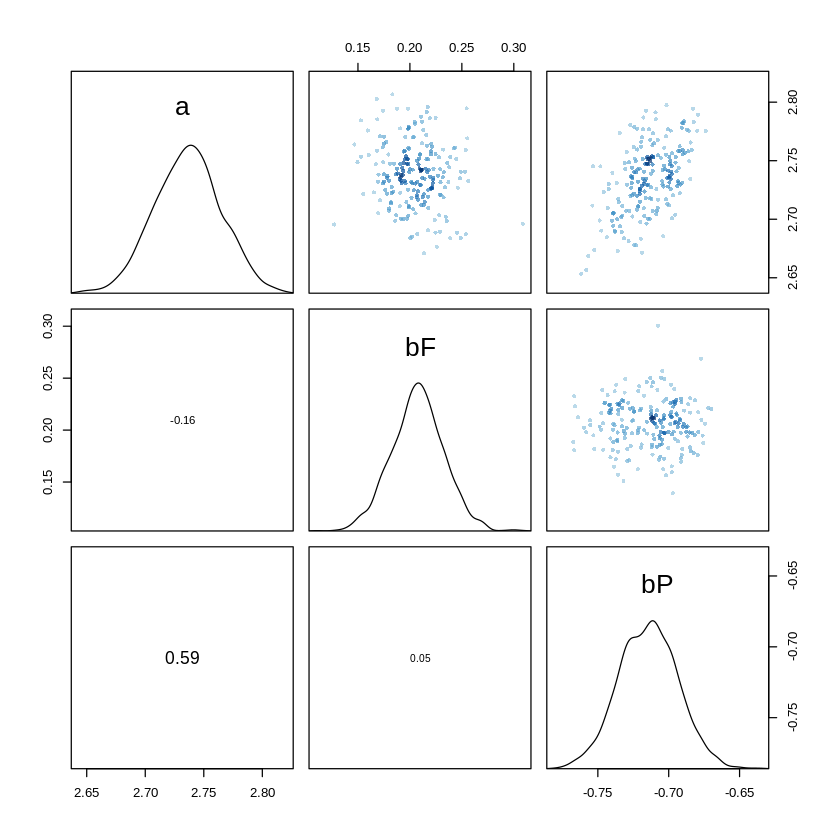

In [307]:
pairs(m11h3mainEffPRES)

In [303]:
m11h3intPRES <- ulam(
                        alist(
                            deaths ~ dpois(lamda) ,
                            log(lamda) <- a + bF * f_std + bP * minPres_std + bFP * (f_std * minPres_std),
                            a ~ dnorm( 2, 1) ,               
                            bF ~ dnorm( 0, 1 ),    # max deaths is 256
                            bP ~ dnorm( 0, 1 ),
                            bFP ~ dnorm( 0, 0.2)
                        ), data=dat4
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [304]:
precis(m11h3intPRES)

mean        sd         5.5%        94.5%      n_eff    Rhat    
a    2.72150689 0.02926213  2.67615363  2.7697226 816.4575 1.001931
bF   0.26071210 0.03174440  0.20885708  0.3113145 690.2241 1.003468
bP  -0.73568264 0.02390131 -0.77491814 -0.6985227 904.7349 1.001913
bFP  0.06962123 0.02518012  0.02981208  0.1096186 851.2482 1.001358

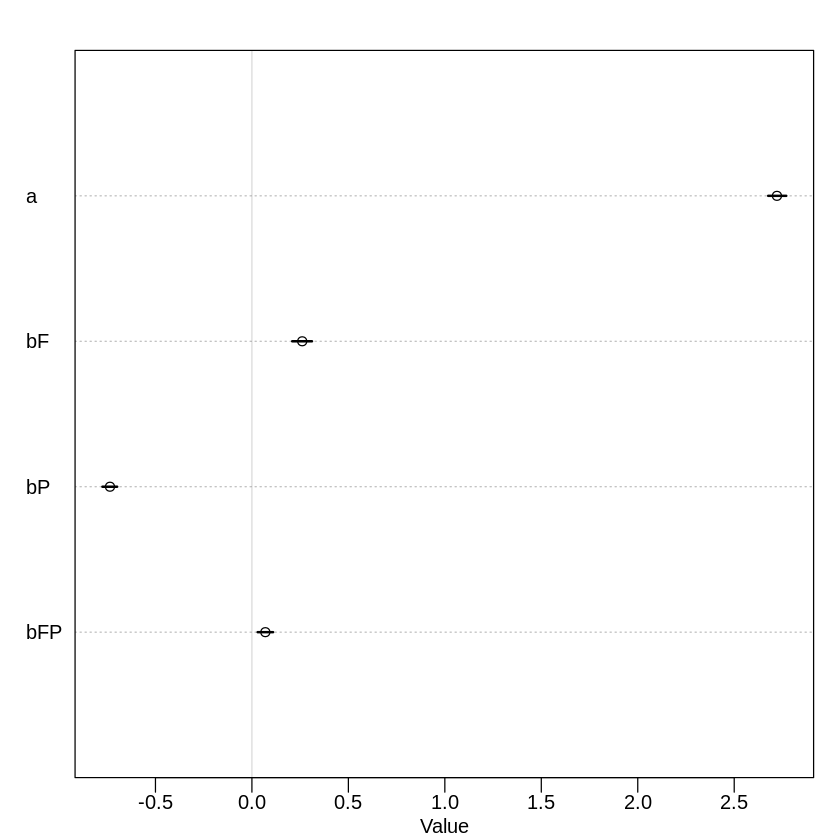

In [305]:
plot(precis(m11h3intPRES))

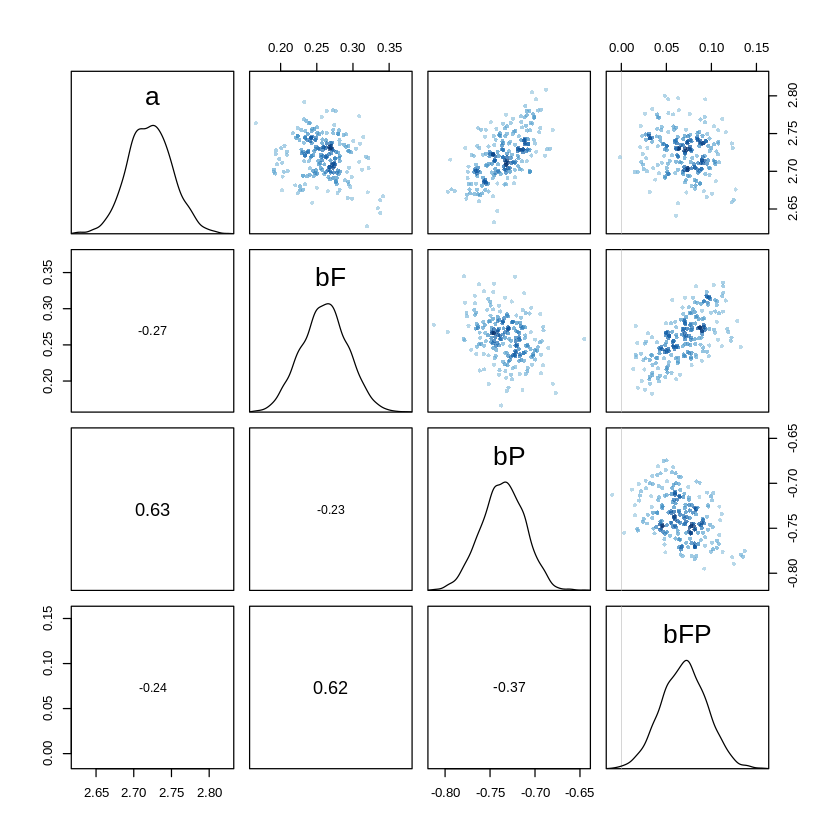

In [306]:
pairs(m11h3intPRES)

In [308]:
m11h3gamMainEffPRES <- ulam(
                        alist(
                            deaths ~ dgampois(lamda, phi) ,
                            log(lamda) <- a + bF * f_std + bP * minPres_std,
                            a ~ dnorm( 2, 1) ,               
                            bF ~ dnorm( 0, 1 ),    # max deaths is 256
                            bP ~ dnorm( 0, 1 ),
                            phi ~ dexp(1)
                        ), data=dat4
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [309]:
precis(m11h3gamMainEffPRES)

mean       sd         5.5%        94.5%      n_eff    Rhat     
a    2.8037849 0.14384475  2.58079826  3.0321529 1966.771 0.9993967
bF   0.2865873 0.14248827  0.05659455  0.5099877 2229.266 1.0014665
bP  -0.5869332 0.14283720 -0.81821173 -0.3616692 2123.749 0.9996321
phi  0.5337487 0.07612448  0.41807879  0.6649205 2160.776 0.9997978

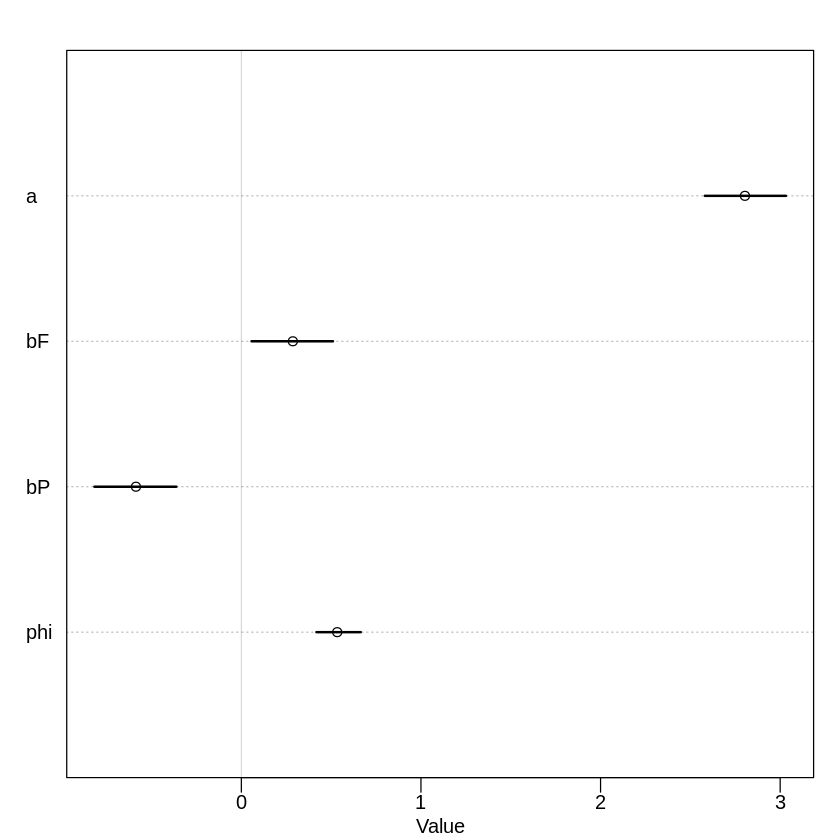

In [310]:
plot(precis(m11h3gamMainEffPRES))

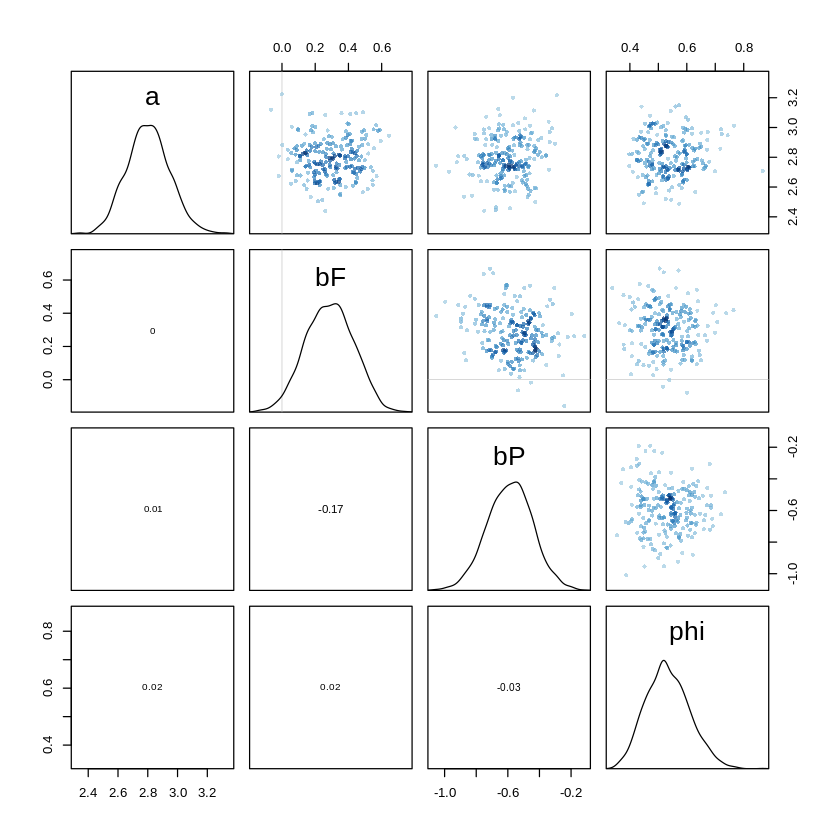

In [311]:
pairs(m11h3gamMainEffPRES)

In [81]:
m11h3gamIntPRES <- ulam(
                        alist(
                            deaths ~ dgampois(lamda, phi) ,
                            log(lamda) <- a + bF * f_std + bP * minPres_std + bFP * (f_std * minPres_std),
                            a ~ dnorm( 2, 1) ,               
                            bF ~ dnorm( 0, 1 ),    # max deaths is 256
                            bP ~ dnorm( 0, 1 ),
                            bFP ~ dnorm( 0, 0.2 ),
                            phi ~ dexp(1)
                        ), data=dat4
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [313]:
precis(m11h3gamIntPRES)

mean       sd         5.5%          94.5%      n_eff    Rhat     
a    2.7787946 0.14925271  2.5439027509  3.0232606 2704.621 0.9988460
bF   0.2984975 0.14476000  0.0669371756  0.5261111 2037.042 1.0021054
bP  -0.6394516 0.14222185 -0.8667822505 -0.4172540 2126.644 0.9984546
bFP  0.1948411 0.12197074  0.0001407404  0.3897815 2441.913 0.9990235
phi  0.5519393 0.08236828  0.4239066468  0.6890200 2158.269 0.9994333

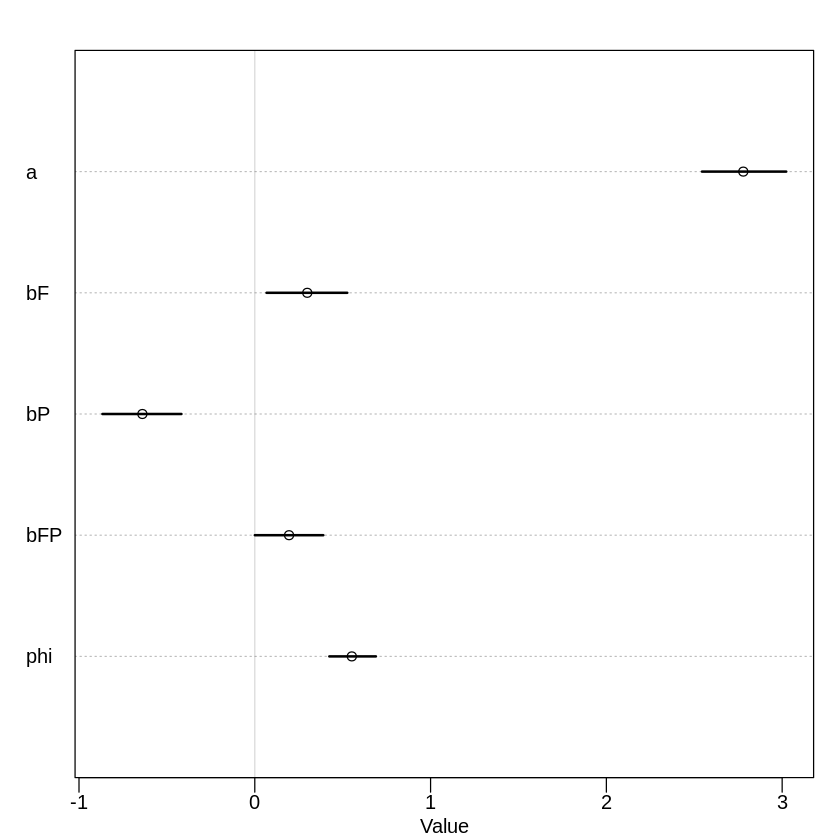

In [314]:
plot(precis(m11h3gamIntPRES))

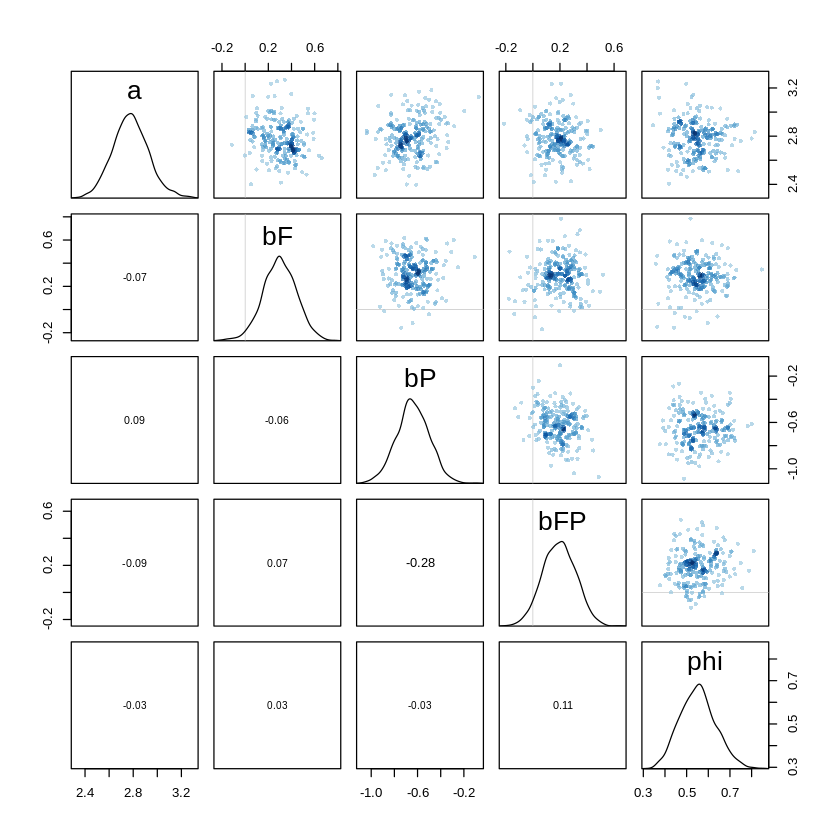

In [315]:
pairs(m11h3gamIntPRES)

In [73]:
dat5 <- list(deaths=d$deaths, f_std=standardize(d$femininity), D_norm=normalize(d$damage_norm), minPres_std=standardize(d$min_pressure))

In [317]:


m11h3mainEffBoth <- ulam(
                        alist(
                            deaths ~ dpois(lamda) ,
                            log(lamda) <- a + bF * f_std + bD * D_norm + bP * minPres_std,
                            a ~ dnorm( 2, 1) ,               
                            bF ~ dnorm( 0, 1 ),    # max deaths is 256
                            bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                            bP ~ dnorm( 0, 1 )
#                            , bFD ~ dnorm( 0, 0.2 ),
#                             bFP ~ dnorm( 0, 0.2 ),
#                             bFDP ~ dnorm( 0, 0.2 ),
#                             phi ~ dexp(1)
                        ), data=dat5
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [318]:
precis(m11h3mainEffBoth)

mean       sd         5.5%       94.5%      n_eff    Rhat     
a   2.5137148 0.03169592  2.4615899  2.5628953 1558.763 0.9994516
bF  0.2650503 0.02476844  0.2251792  0.3040871 1504.089 1.0016270
bD  1.8973925 0.08500576  1.7584599  2.0361797 1206.599 1.0010564
bP -0.4274836 0.02758040 -0.4721948 -0.3835810 1200.095 1.0036178

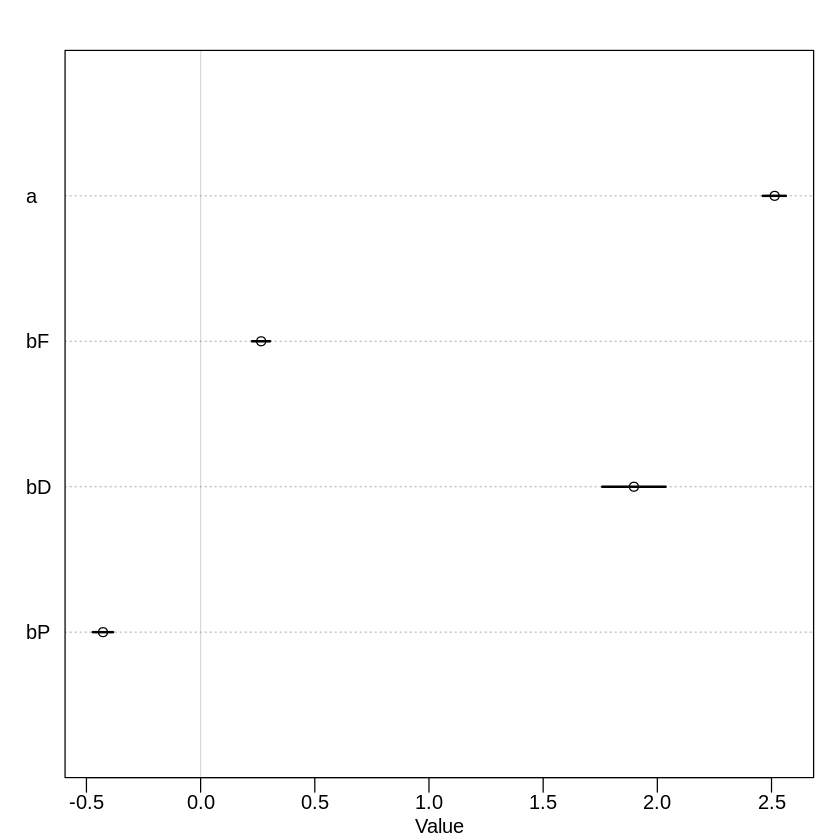

In [319]:
plot(precis(m11h3mainEffBoth))

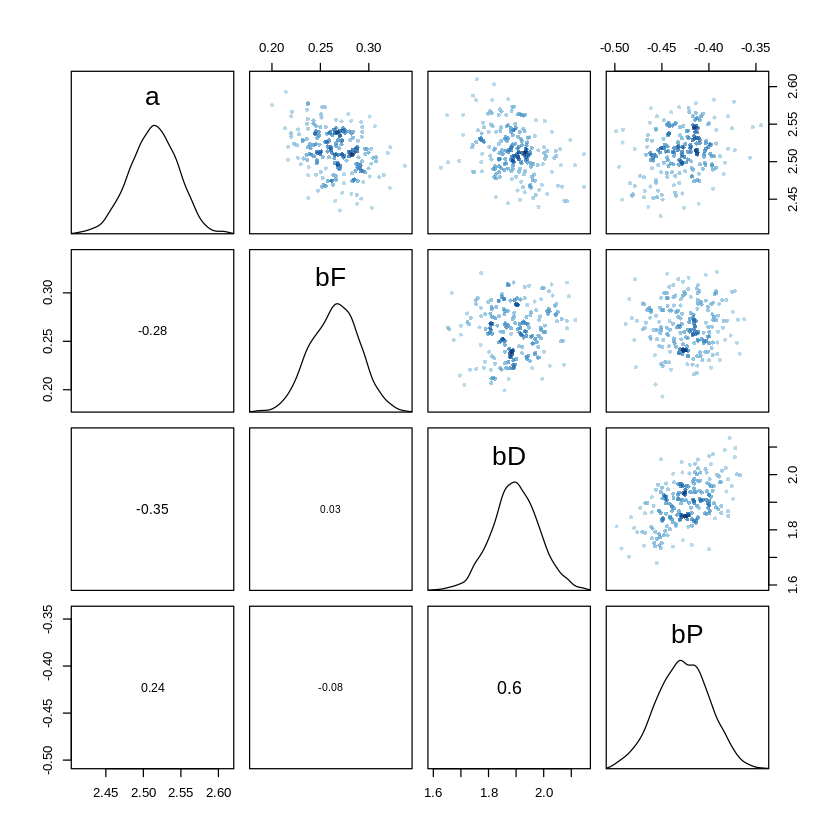

In [320]:
pairs(m11h3mainEffBoth)

In [323]:
m11h3intBoth <- ulam(
                        alist(
                            deaths ~ dpois(lamda) ,
                            log(lamda) <- a + bF * f_std + bD * D_norm + bP * minPres_std + bFD * (f_std * D_norm) + bFP * (f_std * minPres_std) + bFDP * (f_std * D_norm * minPres_std),
                            a ~ dnorm( 2, 1) ,               
                            bF ~ dnorm( 0, 1 ),    # max deaths is 256
                            bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                            bP ~ dnorm( 0, 1 )
                           , bFD ~ dnorm( 0, 0.2 ),
                            bFP ~ dnorm( 0, 0.2 ),
                            bFDP ~ dnorm( 0, 0.2 )
#                           , phi ~ dexp(1)
                        ), data=dat5
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [324]:
precis(m11h3intBoth)

mean        sd         5.5%        94.5%      n_eff    Rhat     
a     2.54039481 0.03118258  2.49095926  2.5894956 1438.986 1.0020358
bF    0.15720835 0.03423918  0.10295741  0.2116454 1824.731 0.9986617
bD    1.57328825 0.10034384  1.41611710  1.7370541 1105.936 0.9998126
bP   -0.50551238 0.03054667 -0.55350382 -0.4580407 1222.867 1.0011627
bFD   0.86812418 0.16083251  0.61910789  1.1338252 1051.944 0.9984614
bFP   0.09104068 0.03692152  0.03288776  0.1494689 1599.852 1.0010751
bFDP  0.14759127 0.08628397  0.01396497  0.2866645 1283.898 1.0002129

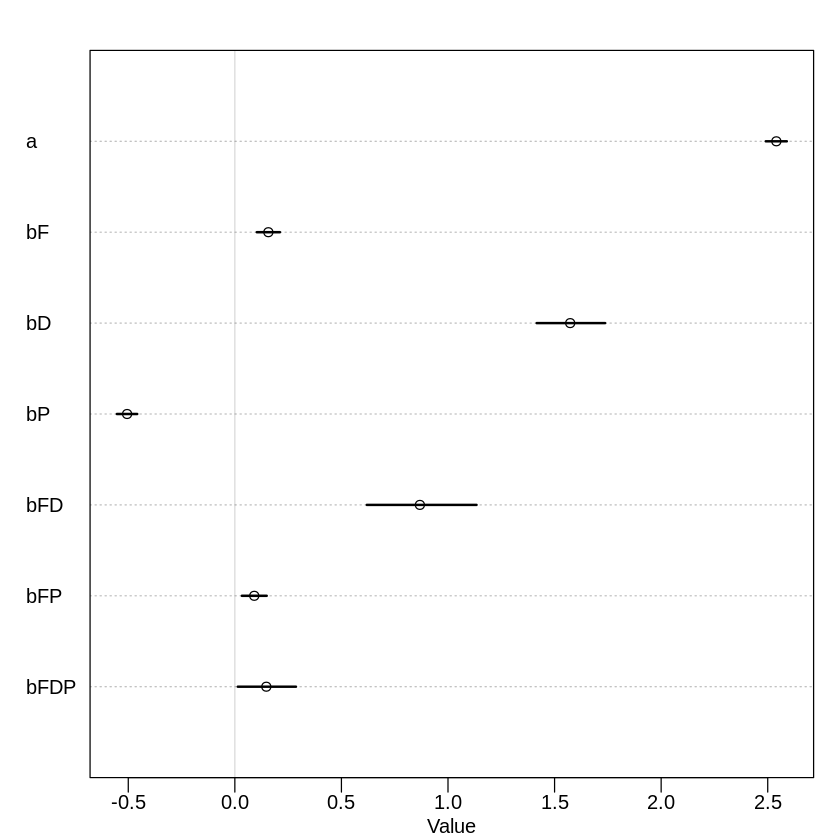

In [325]:
plot(precis(m11h3intBoth))

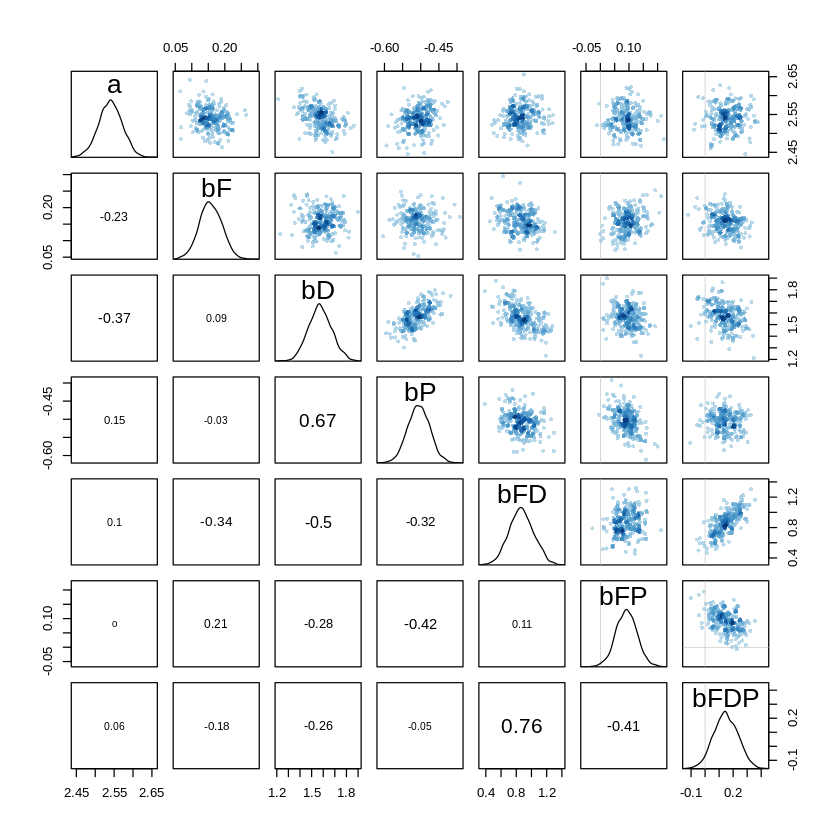

In [326]:
pairs(m11h3intBoth)

In [327]:
m11h3gamMainEffBoth <- ulam(
                        alist(
                            deaths ~ dgampois(lamda, phi) ,
                            log(lamda) <- a + bF * f_std + bD * D_norm + bP * minPres_std, # + bFD * (f_std * D_norm) + bFP * (f_std * minPres_std) + bFDP * (f_std * D_norm * minPres_std),
                            a ~ dnorm( 2, 1) ,               
                            bF ~ dnorm( 0, 1 ),    # max deaths is 256
                            bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                            bP ~ dnorm( 0, 1 )
#                            , bFD ~ dnorm( 0, 0.2 ),
#                             bFP ~ dnorm( 0, 0.2 ),
#                             bFDP ~ dnorm( 0, 0.2 )
                          , phi ~ dexp(1)
                        ), data=dat5
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [328]:
precis(m11h3gamMainEffBoth)

mean       sd        5.5%        94.5%      n_eff    Rhat     
a    2.1483314 0.1821377  1.86299626  2.4486004 1322.120 1.0016582
bF   0.1496045 0.1304636 -0.06298125  0.3558126 1934.367 1.0004933
bD   4.5042547 1.0584905  2.88650996  6.2549433 1195.375 1.0034927
bP  -0.3678895 0.1354911 -0.58986782 -0.1579955 1676.670 1.0003301
phi  0.6920116 0.1016910  0.54584407  0.8594332 1624.442 0.9995813

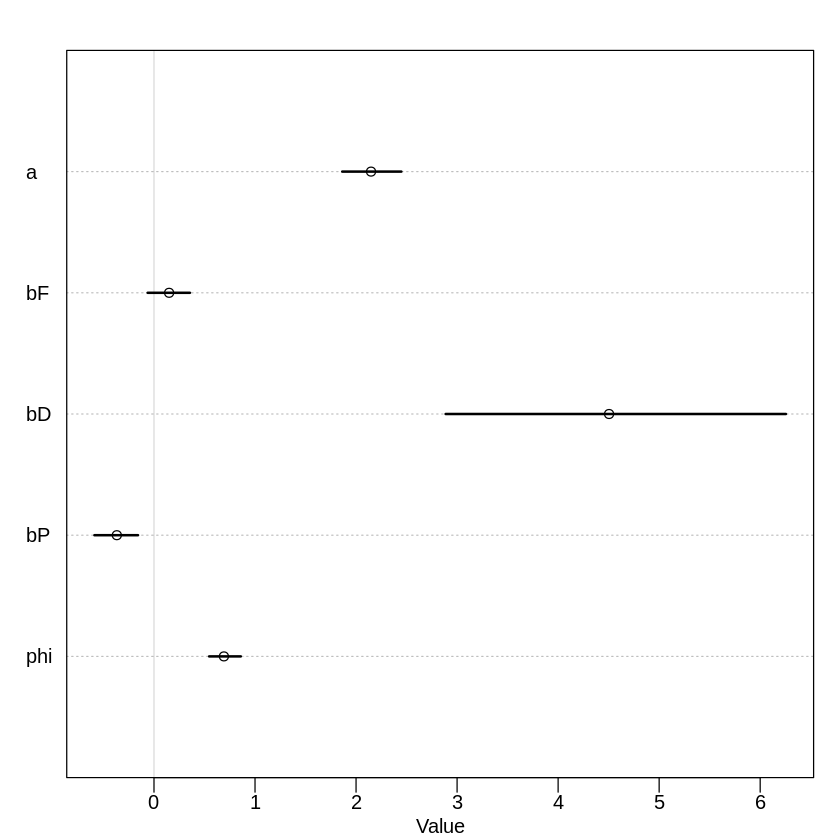

In [329]:
plot(precis(m11h3gamMainEffBoth))

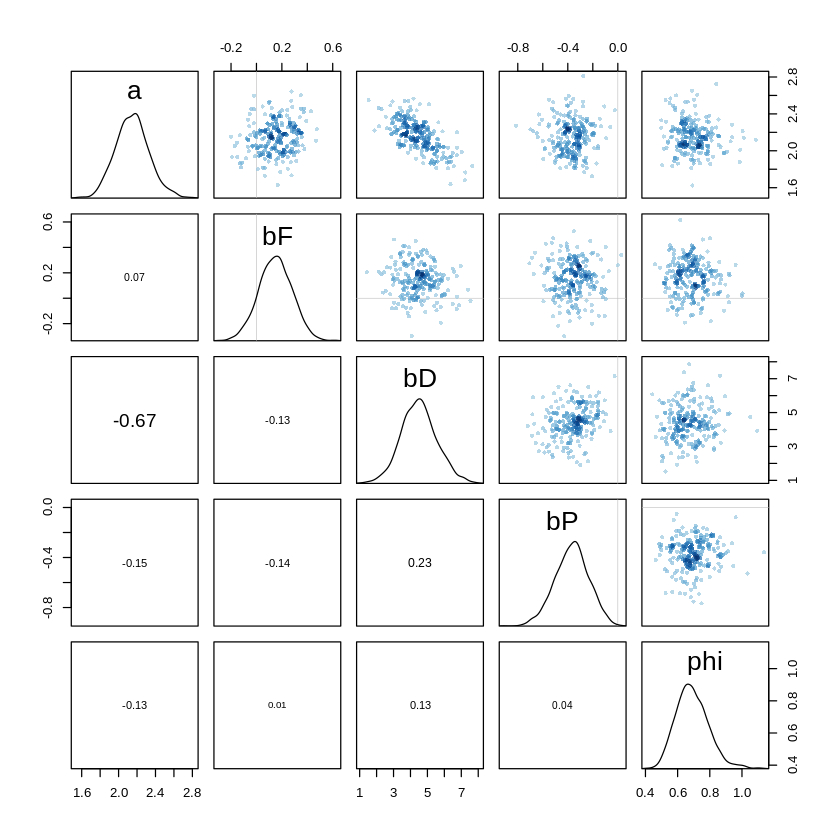

In [330]:
pairs(m11h3gamMainEffBoth)

In [74]:
m11h3gamIntBoth <- ulam(
                        alist(
                            deaths ~ dgampois(lamda, phi) ,
                            log(lamda) <- a + bF * f_std + bD * D_norm + bP * minPres_std + bFD * (f_std * D_norm) + bFP * (f_std * minPres_std) + bFDP * (f_std * D_norm * minPres_std),
                            a ~ dnorm( 2, 1) ,               
                            bF ~ dnorm( 0, 1 ),    # max deaths is 256
                            bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                            bP ~ dnorm( 0, 1 )
                           , bFD ~ dnorm( 0, 0.2 ),
                            bFP ~ dnorm( 0, 0.2 ),
                            bFDP ~ dnorm( 0, 0.2 )
                          , phi ~ dexp(1)
                        ), data=dat5
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [332]:
precis(m11h3gamIntBoth)

mean         sd        5.5%        94.5%      n_eff    Rhat     
a     2.170145462 0.1782707  1.88788591  2.4553270 1592.555 1.0011872
bF    0.143762276 0.1366084 -0.08546885  0.3609766 1884.538 1.0024433
bD    4.270221994 1.0560563  2.61829064  5.9839323 1649.355 1.0003914
bP   -0.407092555 0.1456539 -0.63678597 -0.1758899 1860.419 1.0021639
bFD   0.072866978 0.2056821 -0.26202449  0.4092675 2128.417 0.9993712
bFP   0.111410045 0.1236654 -0.08580888  0.3098700 1633.489 1.0001737
bFDP  0.006385805 0.1932053 -0.30735626  0.3128344 2109.105 1.0007045
phi   0.684731745 0.1045652  0.52991900  0.8613473 1772.849 1.0008885

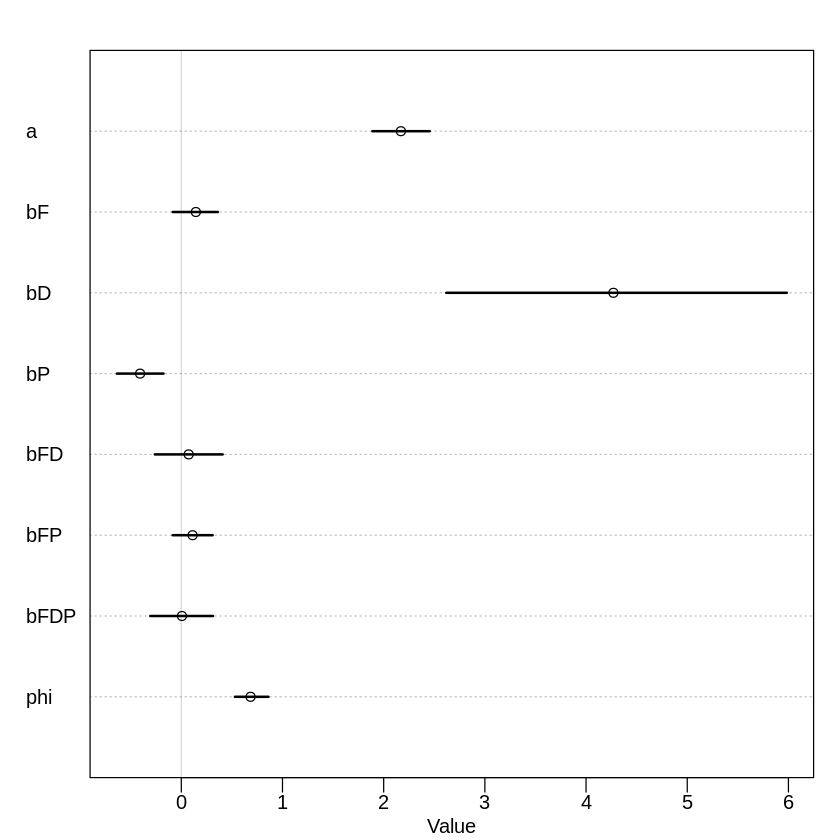

In [333]:
plot(precis(m11h3gamIntBoth))

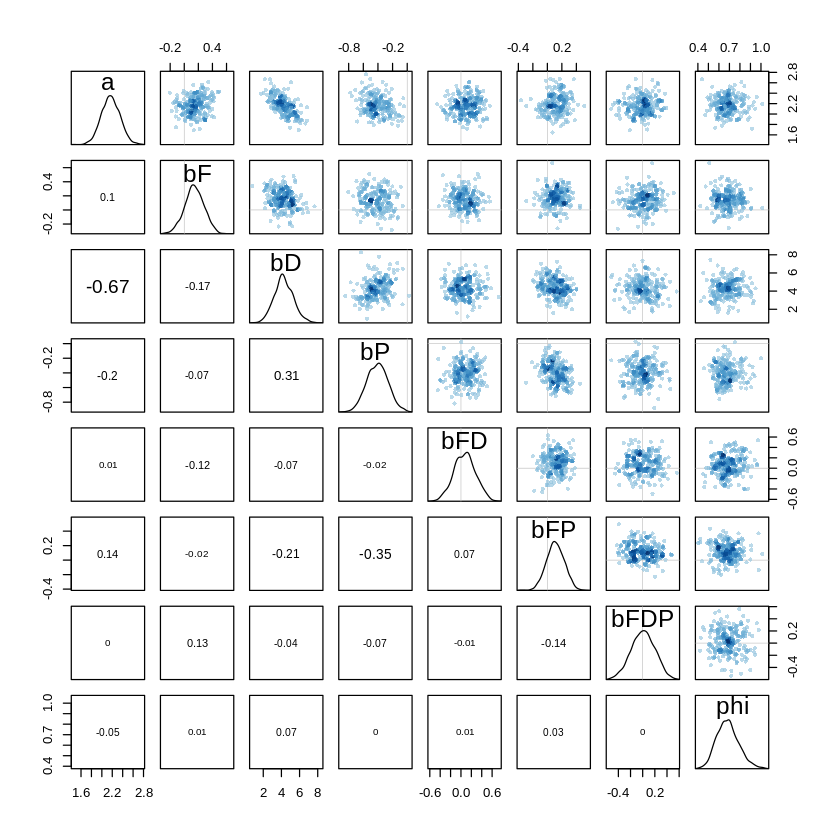

In [334]:
pairs(m11h3gamIntBoth)

In [335]:
compare(m11h3gamIntBoth, m11h3intBoth, m11h3gamMainEffBoth, m11h3mainEffBoth, m11h3gamIntDAM, m11h3intDAM, m11h3gamMainEffDAM, m11h3mainEffDAM, m11h3gamIntPRES, m11h3intPRES, m11h3gamMainEffPRES, m11h3mainEffPRES)

WAIC      pWAIC      dWAIC        weight       SE        
m11h3gamIntDAM       672.1626   4.747508    0.0000000 2.718124e-01   32.30326
m11h3gamMainEffDAM   672.2733   4.750310    0.1107472 2.571703e-01   32.28599
m11h3gamIntBoth      672.4067   8.673726    0.2441288 2.405789e-01   36.99080
m11h3gamMainEffBoth  672.4929   8.456487    0.3302913 2.304345e-01   38.02608
m11h3gamIntPRES      694.9253   8.572219   22.7627645 3.100258e-06   38.92798
m11h3gamMainEffPRES  697.7448   8.392005   25.5822271 7.571106e-07   40.51038
m11h3mainEffDAM     3201.7161 122.942290 2529.5535514 0.000000e+00  788.27271
m11h3intDAM         3216.9014 132.938792 2544.7388342 0.000000e+00  788.63568
m11h3mainEffBoth    3237.8068 300.772252 2565.6442095 0.000000e+00  962.00700
m11h3intBoth        3249.3545 370.116389 2577.1919498 0.000000e+00  988.57510
m11h3mainEffPRES    3479.5311 193.631854 2807.3685733 0.000000e+00 1110.51417
m11h3intPRES        3560.4629 252.165748 2888.3003057 0.000000e+00 1133.35303
                    dSE         
m11h3gamIntDAM                NA
m11h3gamMainEffDAM     0.1391742
m11h3gamIntBoth       11.3977537
m11h3gamMainEffBoth   12.8537879
m11h3gamIntPRES       16.2722991
m11h3gamMainEffPRES   18.2805926
m11h3mainEffDAM      772.9504201
m11h3intDAM          773.1908038
m11h3mainEffBoth     948.0898290
m11h3intBoth         975.0627011
m11h3mainEffPRES    1099.6275821
m11h3intPRES        1122.2916587

The best models for prediction are those using gamma-poisson distribution, involving the damage_norm variable.  The interaction between femininity and damage_norm seems to add little as long as there is the main effect of the damage_norm variable.  Note that it is this model that also has the lowest pWAIC (effective parameters).  Let's replot the coefficients for this model to recap:

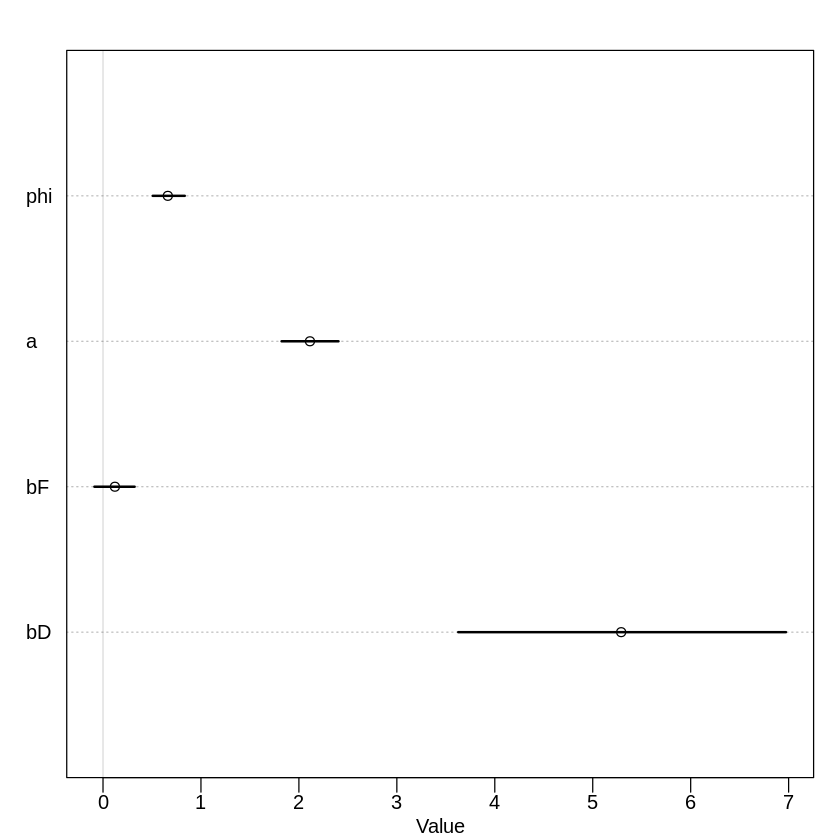

In [337]:
plot(precis(m11h3gamMainEffDAM))

In this plot, we can see that bF is still close to zero, suggesting little influence in the femininity of the name of the hurricane.  The bD is much more important as a predictor (surprise, surprise).

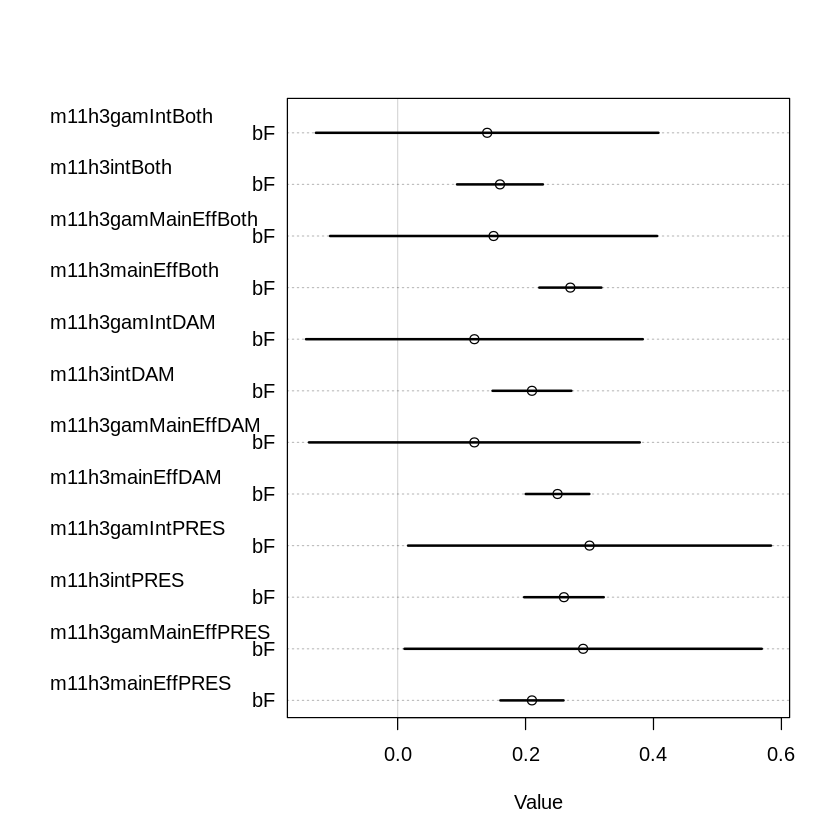

In [358]:
# models <- c(m11h3gamIntBoth, m11h3intBoth, m11h3gamMainEffBoth, m11h3mainEffBoth, m11h3gamIntDAM, m11h3intDAM, m11h3gamMainEffDAM, m11h3mainEffDAM, m11h3gamIntPRES, m11h3intPRES, m11h3gamMainEffPRES, m11h3mainEffPRES)

# for (m in models) {
#     print(coef(m)['bF'])
# }

plot(coeftab(m11h3gamIntBoth, m11h3intBoth, m11h3gamMainEffBoth, m11h3mainEffBoth, m11h3gamIntDAM, m11h3intDAM, m11h3gamMainEffDAM, m11h3mainEffDAM, m11h3gamIntPRES, m11h3intPRES, m11h3gamMainEffPRES, m11h3mainEffPRES), pars="bF", labels="bF")

By data snooping for bF, we find the model with the distribution of bF values that are the greatest, is m11h3gamIntPRES, which is the gamma poisson model featuring the interaction between femininity and minimum pressure.  Almost as high is m11h3gamMainEffPRES, which is the same gamma poisson model but without the interaction term.  Just adding the minimum pressure seems to increase the estimate of bF.

Looking at the WAIC scores however, these models perform the worst of all the gamma-poisson models (and also their poisson versions perform the worst of all the poisson models).  Clearly, the femininity of the name of the hurricane does not help predict the number of deaths caused by the hurricane.

What about if we remove the femininity predictor?

In [5]:
dat6 <- list(deaths=d$deaths, D_norm=normalize(d$damage_norm), minPres_std=standardize(d$min_pressure))

m11h3gamIntBothNoF <- ulam(
                        alist(
                            deaths ~ dgampois(lamda, phi) ,
                            log(lamda) <- a + bD * D_norm + bP * minPres_std + bDP * (D_norm * minPres_std),
                            a ~ dnorm( 2, 1) ,               
                            bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                            bP ~ dnorm( 0, 1 ),
                            bDP ~ dnorm( 0, 0.2 )
                          , phi ~ dexp(1)
                        ), data=dat6
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [365]:
precis(m11h3gamIntBothNoF)

mean       sd        5.5%       94.5%      n_eff    Rhat     
a    2.1252676 0.1700125  1.8689426  2.4059248 1222.653 1.0017068
bD   4.7621890 0.9993955  3.1516234  6.4320859 1181.979 1.0023400
bP  -0.3672659 0.1373890 -0.5894423 -0.1569065 1684.181 0.9990138
bDP  0.1642491 0.1908740 -0.1425279  0.4684475 1760.471 0.9987826
phi  0.7031616 0.1059465  0.5445692  0.8860646 1637.154 0.9987054

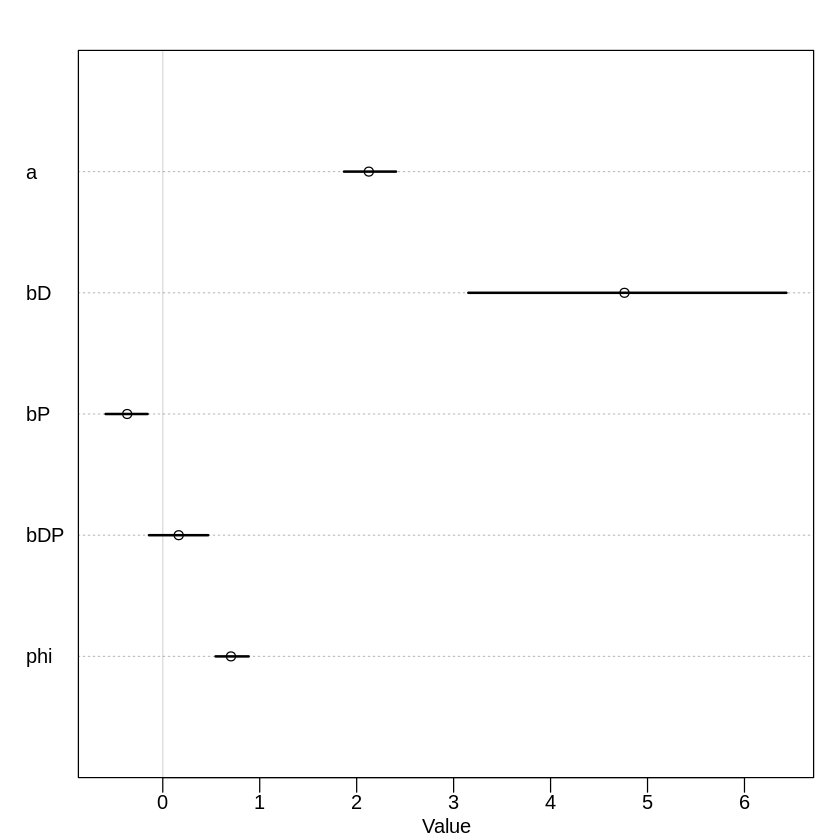

In [366]:
plot(precis(m11h3gamIntBothNoF))

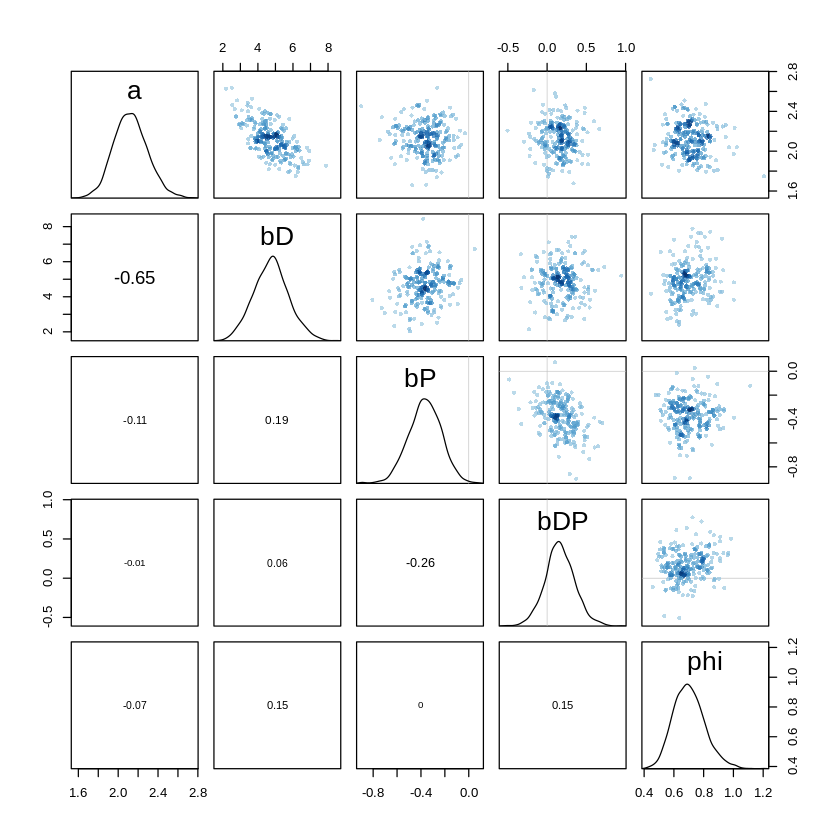

In [367]:
pairs(m11h3gamIntBothNoF)

In [368]:
compare(m11h3gamIntBoth, m11h3intBoth, m11h3gamMainEffBoth, m11h3mainEffBoth, m11h3gamIntDAM, m11h3intDAM, m11h3gamMainEffDAM, m11h3mainEffDAM, m11h3gamIntPRES, m11h3intPRES, m11h3gamMainEffPRES, m11h3mainEffPRES, m11h3gamIntBothNoF)

WAIC      pWAIC      dWAIC       weight       SE        
m11h3gamIntBothNoF   669.9949   7.722514    0.000000 4.455114e-01   38.85410
m11h3gamIntDAM       672.1626   4.747508    2.167639 1.507169e-01   32.30326
m11h3gamMainEffDAM   672.2733   4.750310    2.278386 1.425980e-01   32.28599
m11h3gamIntBoth      672.4067   8.673726    2.411768 1.333982e-01   36.99080
m11h3gamMainEffBoth  672.4929   8.456487    2.497930 1.277733e-01   38.02608
m11h3gamIntPRES      694.9253   8.572219   24.930403 1.719058e-06   38.92798
m11h3gamMainEffPRES  697.7448   8.392005   27.749866 4.198092e-07   40.51038
m11h3mainEffDAM     3201.7161 122.942290 2531.721190 0.000000e+00  788.27271
m11h3intDAM         3216.9014 132.938792 2546.906473 0.000000e+00  788.63568
m11h3mainEffBoth    3237.8068 300.772252 2567.811848 0.000000e+00  962.00700
m11h3intBoth        3249.3545 370.116389 2579.359589 0.000000e+00  988.57510
m11h3mainEffPRES    3479.5311 193.631854 2809.536212 0.000000e+00 1110.51417
m11h3intPRES        3560.4629 252.165748 2890.467945 0.000000e+00 1133.35303
                    dSE        
m11h3gamIntBothNoF           NA
m11h3gamIntDAM        14.447706
m11h3gamMainEffDAM    14.491333
m11h3gamIntBoth        3.980050
m11h3gamMainEffBoth    3.014498
m11h3gamIntPRES        7.042516
m11h3gamMainEffPRES    7.302861
m11h3mainEffDAM      767.498966
m11h3intDAM          767.661615
m11h3mainEffBoth     936.881114
m11h3intBoth         963.686393
m11h3mainEffPRES    1086.854930
m11h3intPRES        1109.615298

Funnily enough, removing femininity as a predictor improves the predictive ability of the model!

In [ ]:
m11h3gamMainEffBothNoF <- ulam(
                        alist(
                            deaths ~ dgampois(lamda, phi) ,
                            log(lamda) <- a + bD * D_norm + bP * minPres_std,
                            a ~ dnorm( 2, 1) ,               
                            bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                            bP ~ dnorm( 0, 1 ),
                            bDP ~ dnorm( 0, 0.2 )
                          , phi ~ dexp(1)
                        ), data=dat6
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [370]:
precis(m11h3gamMainEffBothNoF)

mean         sd        5.5%       94.5%      n_eff    Rhat    
a    2.130115508 0.1786287  1.8519426  2.4193843 1239.176 1.001341
bD   4.706446400 1.0664623  2.9932120  6.3788928 1185.021 1.002354
bP  -0.343648888 0.1355495 -0.5669547 -0.1313847 1485.969 1.004362
bDP  0.006354793 0.2078134 -0.3295060  0.3518977 1790.881 1.000151
phi  0.692861312 0.1066231  0.5331498  0.8694459 1734.631 1.001961

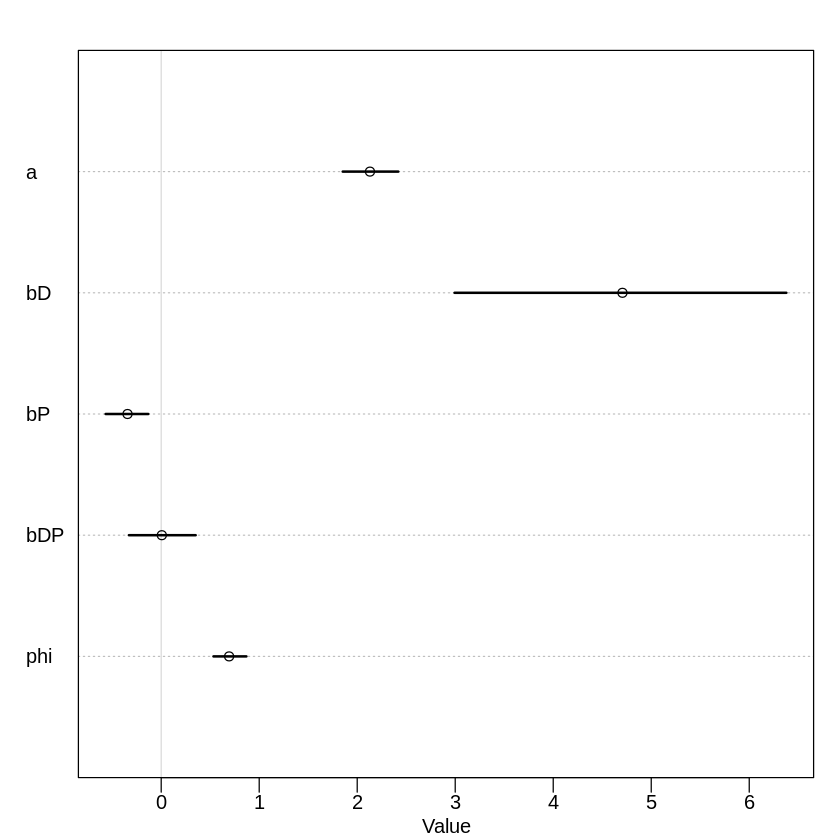

In [371]:
plot(precis(m11h3gamMainEffBothNoF))

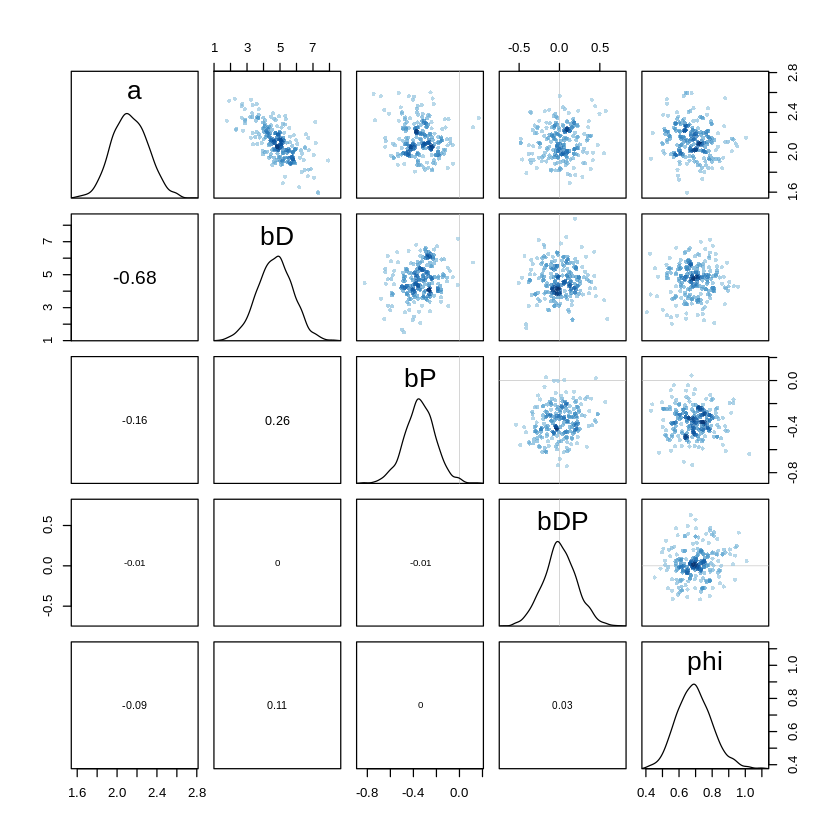

In [373]:
pairs(m11h3gamMainEffBothNoF)

In [372]:
compare(m11h3gamIntBoth, m11h3intBoth, m11h3gamMainEffBoth, m11h3mainEffBoth, m11h3gamIntDAM, m11h3intDAM, m11h3gamMainEffDAM, m11h3mainEffDAM, m11h3gamIntPRES, m11h3intPRES, m11h3gamMainEffPRES, m11h3mainEffPRES, m11h3gamIntBothNoF, m11h3gamMainEffBothNoF)

WAIC      pWAIC      dWAIC       weight       SE        
m11h3gamIntBothNoF      669.9949   7.722514    0.000000 3.848587e-01   38.85410
m11h3gamMainEffBothNoF  672.0733   8.166600    2.078361 1.361416e-01   39.25288
m11h3gamIntDAM          672.1626   4.747508    2.167639 1.301981e-01   32.30326
m11h3gamMainEffDAM      672.2733   4.750310    2.278386 1.231845e-01   32.28599
m11h3gamIntBoth         672.4067   8.673726    2.411768 1.152372e-01   36.99080
m11h3gamMainEffBoth     672.4929   8.456487    2.497930 1.103780e-01   38.02608
m11h3gamIntPRES         694.9253   8.572219   24.930403 1.485022e-06   38.92798
m11h3gamMainEffPRES     697.7448   8.392005   27.749866 3.626557e-07   40.51038
m11h3mainEffDAM        3201.7161 122.942290 2531.721190 0.000000e+00  788.27271
m11h3intDAM            3216.9014 132.938792 2546.906473 0.000000e+00  788.63568
m11h3mainEffBoth       3237.8068 300.772252 2567.811848 0.000000e+00  962.00700
m11h3intBoth           3249.3545 370.116389 2579.359589 0.000000e+00  988.57510
m11h3mainEffPRES       3479.5311 193.631854 2809.536212 0.000000e+00 1110.51417
m11h3intPRES           3560.4629 252.165748 2890.467945 0.000000e+00 1133.35303
                       dSE         
m11h3gamIntBothNoF               NA
m11h3gamMainEffBothNoF    0.7071536
m11h3gamIntDAM           14.4477061
m11h3gamMainEffDAM       14.4913334
m11h3gamIntBoth           3.9800503
m11h3gamMainEffBoth       3.0144983
m11h3gamIntPRES           7.0425159
m11h3gamMainEffPRES       7.3028607
m11h3mainEffDAM         767.4989663
m11h3intDAM             767.6616149
m11h3mainEffBoth        936.8811136
m11h3intBoth            963.6863931
m11h3mainEffPRES       1086.8549299
m11h3intPRES           1109.6152979

Removing the interaction term between damage and min pressure does little to the WAIC score.

In [377]:
m11h3mainEffBothNoF <- ulam(
                        alist(
                            deaths ~ dpois(lamda) ,
                            log(lamda) <- a + bD * D_norm + bP * minPres_std,
                            a ~ dnorm( 2, 1) ,               
                            bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                            bP ~ dnorm( 0, 1 )
                        ), data=dat6
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [378]:
precis(m11h3mainEffBothNoF)

mean       sd         5.5%       94.5%      n_eff    Rhat     
a   2.5583405 0.02957014  2.5112260  2.6056856 1160.814 1.0023889
bD  1.8236412 0.08767040  1.6865421  1.9715019 1000.409 1.0019248
bP -0.4314229 0.02761661 -0.4747278 -0.3861123 1075.903 0.9996499

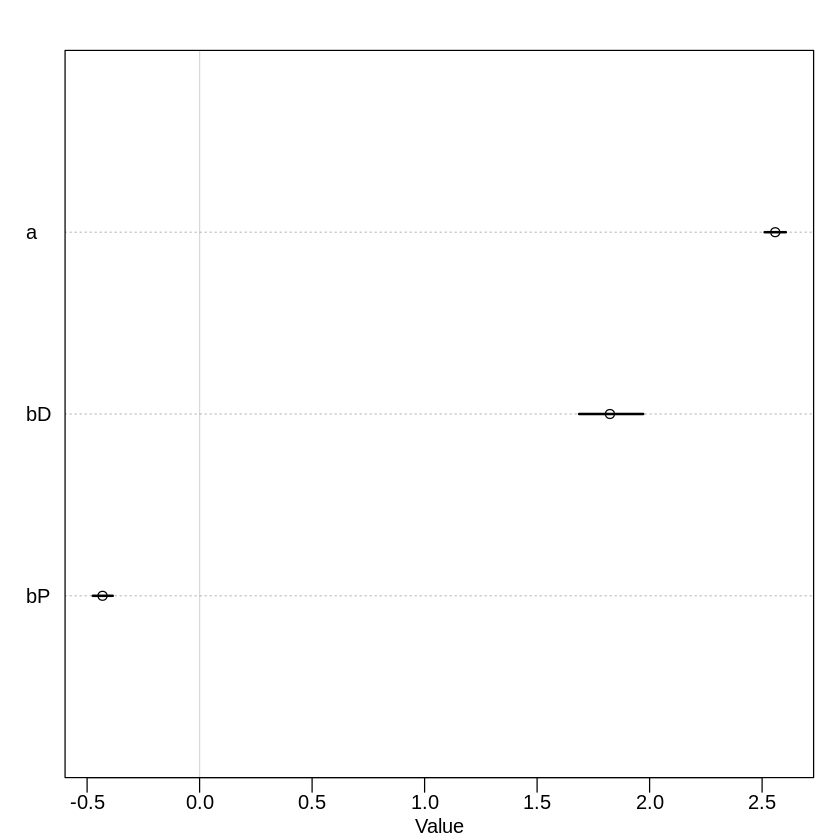

In [379]:
plot(precis(m11h3mainEffBothNoF))

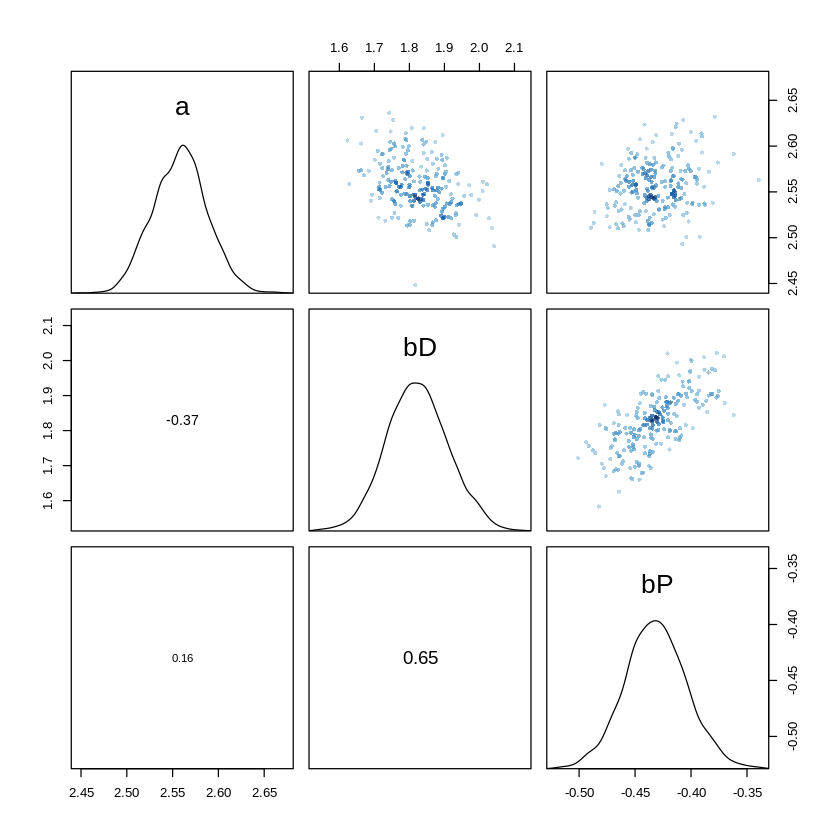

In [383]:
pairs(m11h3mainEffBothNoF)

In [380]:
m11h3intBothNoF <- ulam(
                        alist(
                            deaths ~ dpois(lamda) ,
                            log(lamda) <- a + bD * D_norm + bP * minPres_std + bDP * (D_norm * minPres_std),
                            a ~ dnorm( 2, 1) ,               
                            bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                            bP ~ dnorm( 0, 1 ),
                            bDP ~ dnorm( 0, 0.2 )
                        ), data=dat6
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [381]:
precis(m11h3intBothNoF)

mean       sd         5.5%       94.5%      n_eff    Rhat    
a    2.3780052 0.03511411  2.3212263  2.4346307 916.8109 1.004542
bD   4.1240433 0.15713443  3.8725971  4.3708167 620.4371 1.005267
bP  -0.7006687 0.03393225 -0.7551642 -0.6462364 950.1534 1.001147
bDP  1.6823402 0.10416615  1.5182855  1.8536514 573.6570 1.003898

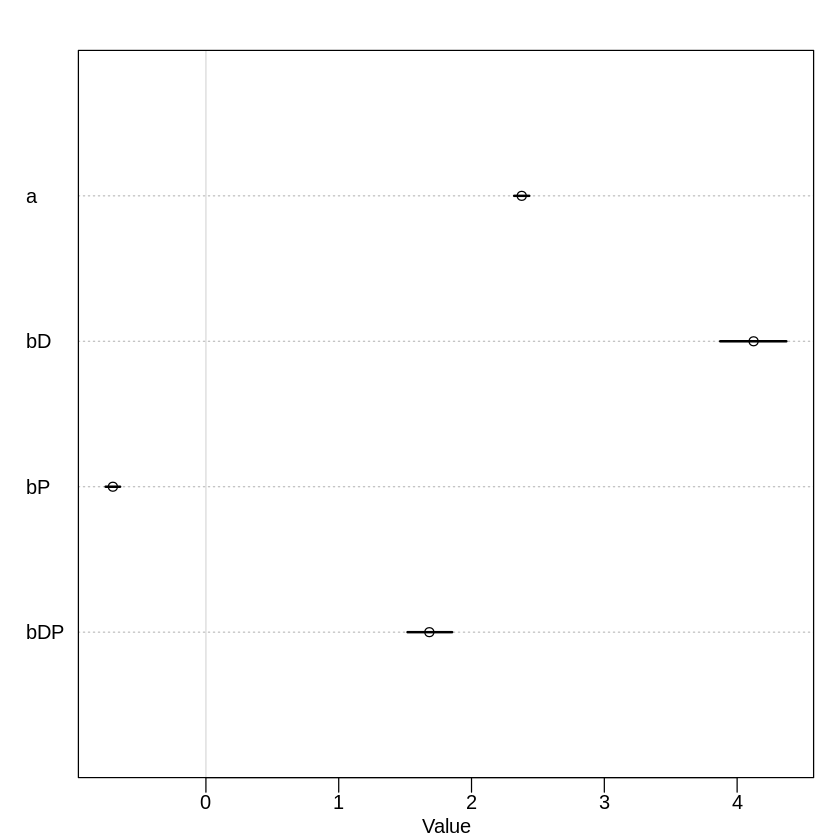

In [382]:
plot(precis(m11h3intBothNoF))

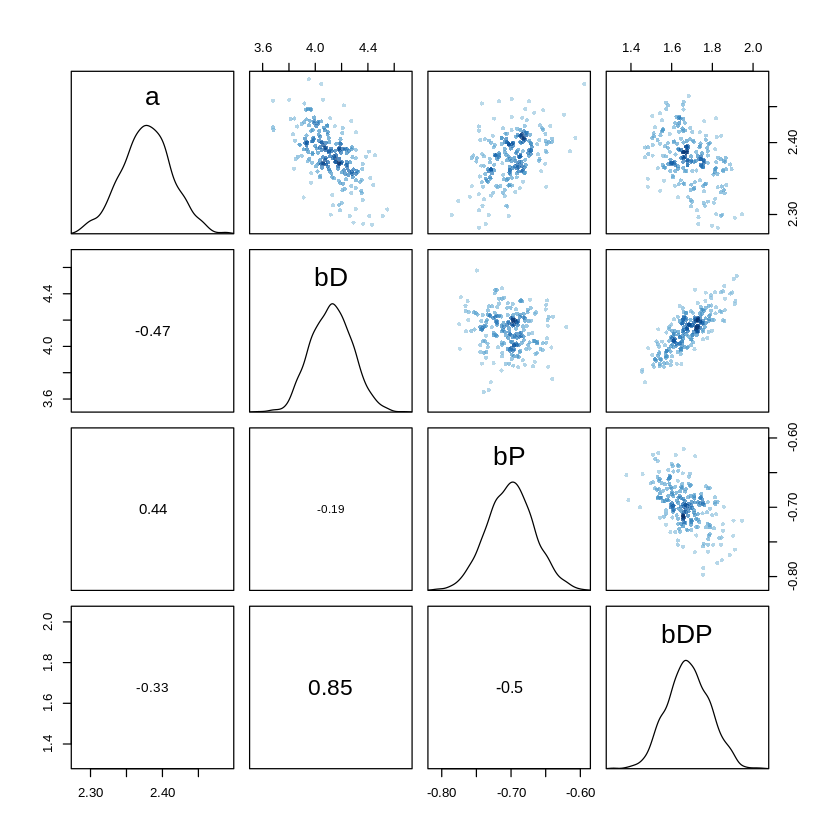

In [384]:
pairs(m11h3intBothNoF)

In [385]:
compare(m11h3gamIntBoth, m11h3intBoth, m11h3gamMainEffBoth, m11h3mainEffBoth, m11h3gamIntDAM, m11h3intDAM, m11h3gamMainEffDAM, m11h3mainEffDAM, m11h3gamIntPRES, m11h3intPRES, m11h3gamMainEffPRES, m11h3mainEffPRES, m11h3gamIntBothNoF, m11h3gamMainEffBothNoF, m11h3intBothNoF, m11h3mainEffBothNoF)

WAIC      pWAIC      dWAIC       weight       SE        
m11h3gamIntBothNoF      669.9949   7.722514    0.000000 3.848587e-01   38.85410
m11h3gamMainEffBothNoF  672.0733   8.166600    2.078361 1.361416e-01   39.25288
m11h3gamIntDAM          672.1626   4.747508    2.167639 1.301981e-01   32.30326
m11h3gamMainEffDAM      672.2733   4.750310    2.278386 1.231845e-01   32.28599
m11h3gamIntBoth         672.4067   8.673726    2.411768 1.152372e-01   36.99080
m11h3gamMainEffBoth     672.4929   8.456487    2.497930 1.103780e-01   38.02608
m11h3gamIntPRES         694.9253   8.572219   24.930403 1.485022e-06   38.92798
m11h3gamMainEffPRES     697.7448   8.392005   27.749866 3.626557e-07   40.51038
m11h3intBothNoF        3089.9321 355.351714 2419.937119 0.000000e+00 1024.81739
m11h3mainEffDAM        3201.7161 122.942290 2531.721190 0.000000e+00  788.27271
m11h3intDAM            3216.9014 132.938792 2546.906473 0.000000e+00  788.63568
m11h3mainEffBoth       3237.8068 300.772252 2567.811848 0.000000e+00  962.00700
m11h3intBoth           3249.3545 370.116389 2579.359589 0.000000e+00  988.57510
m11h3mainEffBothNoF    3348.1493 299.146724 2678.154407 0.000000e+00 1048.53560
m11h3mainEffPRES       3479.5311 193.631854 2809.536212 0.000000e+00 1110.51417
m11h3intPRES           3560.4629 252.165748 2890.467945 0.000000e+00 1133.35303
                       dSE         
m11h3gamIntBothNoF               NA
m11h3gamMainEffBothNoF    0.7071536
m11h3gamIntDAM           14.4477061
m11h3gamMainEffDAM       14.4913334
m11h3gamIntBoth           3.9800503
m11h3gamMainEffBoth       3.0144983
m11h3gamIntPRES           7.0425159
m11h3gamMainEffPRES       7.3028607
m11h3intBothNoF        1002.0500818
m11h3mainEffDAM         767.4989663
m11h3intDAM             767.6616149
m11h3mainEffBoth        936.8811136
m11h3intBoth            963.6863931
m11h3mainEffBothNoF    1024.0308158
m11h3mainEffPRES       1086.8549299
m11h3intPRES           1109.6152979

And even for the pure poisson model, the best one is without the femininity of the name predictor, with an interaction between D_norm and minPres_std.  Note that this is distinguishably better than the second best, given the small value of dSE = 0.7 less than half that of dWAIC = 2.08.

Counterfactuals:

In [6]:
# d$gender <- ifelse(d$female, 2L, 1L)
# dat7 = append(dat6, list(gender=d$gender))
dat7male <- d[d$female==0,]
dat7female <- d[d$female==1,]

In [7]:
dat_slim = list(deaths=dat7male$deaths, D_norm=normalize(dat7male$damage_norm), minPres_std=standardize(dat7male$min_pressure))

m11h3male <- ulam(
                alist(
                    deaths ~ dpois(lamda) ,
                    log(lamda) <- a + bD * D_norm + bP * minPres_std + bDP * (D_norm * minPres_std),
                    a ~ dnorm( 2, 1) ,               
                    bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                    bP ~ dnorm( 0, 1 ),
                    bDP ~ dnorm( 0, 0.2 )
                ), data=dat_slim
                , chains=4, cores=4, log_lik=TRUE
            )

In [8]:
precis(m11h3male)

mean       sd         5.5%       94.5%      n_eff     Rhat    
a    2.2265628 0.07048709  2.1114107  2.3378431 1017.1029 1.002474
bD   1.7611275 0.40401458  1.1076415  2.4137918  813.0085 1.001513
bP  -0.6280577 0.07786888 -0.7551542 -0.5060526 1255.8453 1.000333
bDP  0.5221291 0.15754522  0.2684209  0.7753794  862.1930 1.000537

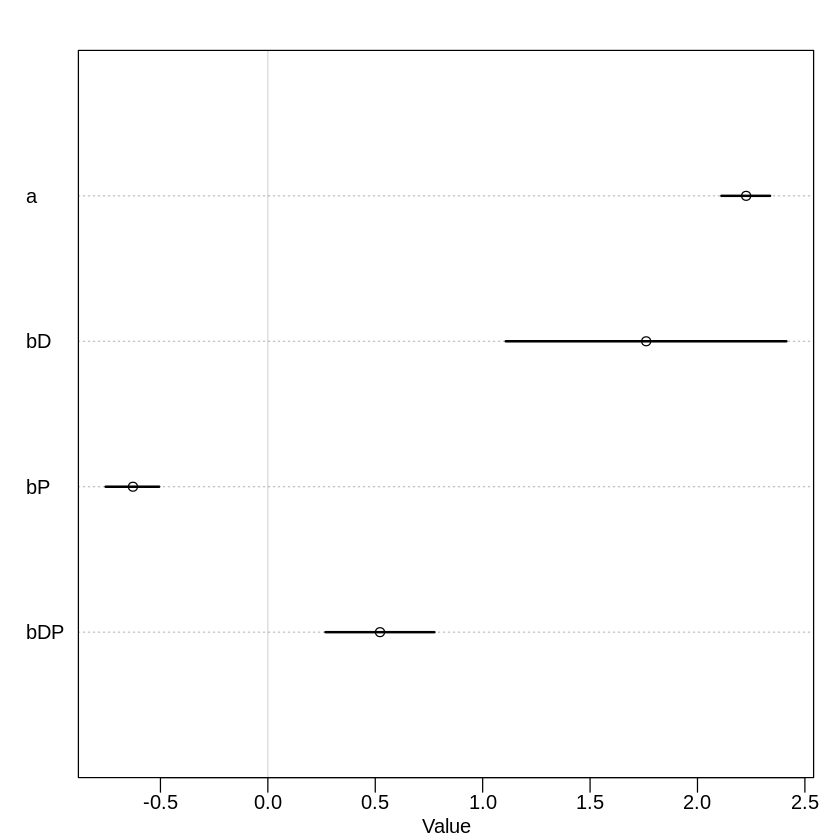

In [11]:
plot(precis(m11h3male))

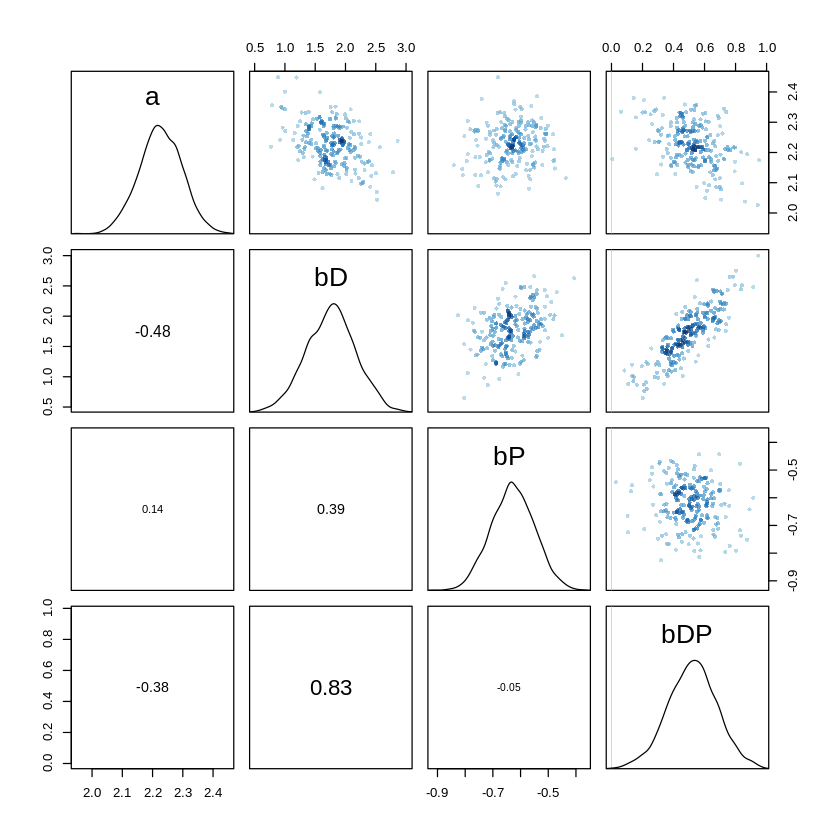

In [9]:
pairs(m11h3male)

In [10]:
dat_slim_fe = list(deaths=dat7female$deaths, D_norm=normalize(dat7female$damage_norm), minPres_std=standardize(dat7female$min_pressure))

m11h3female <- ulam(
                alist(
                    deaths ~ dpois(lamda) ,
                    log(lamda) <- a + bD * D_norm + bP * minPres_std + bDP * (D_norm * minPres_std),
                    a ~ dnorm( 2, 1) ,               
                    bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                    bP ~ dnorm( 0, 1 ),
                    bDP ~ dnorm( 0, 0.2 )
                ), data=dat_slim_fe
                , chains=4, cores=4, log_lik=TRUE
            )

In [12]:
precis(m11h3female)

mean       sd         5.5%       94.5%      n_eff    Rhat    
a    2.5128551 0.03879610  2.4531609  2.5749093 780.1096 1.003066
bD   4.0225343 0.17612834  3.7408242  4.3035886 649.4619 1.002332
bP  -0.7091517 0.03782735 -0.7683876 -0.6473427 697.4201 1.005819
bDP  1.6842253 0.13492417  1.4712653  1.8999900 672.2044 1.003804

In [15]:
precis(m11h3male)

mean       sd         5.5%       94.5%      n_eff     Rhat    
a    2.2265628 0.07048709  2.1114107  2.3378431 1017.1029 1.002474
bD   1.7611275 0.40401458  1.1076415  2.4137918  813.0085 1.001513
bP  -0.6280577 0.07786888 -0.7551542 -0.5060526 1255.8453 1.000333
bDP  0.5221291 0.15754522  0.2684209  0.7753794  862.1930 1.000537

So there are some differences in the bD and bDP coefficients.

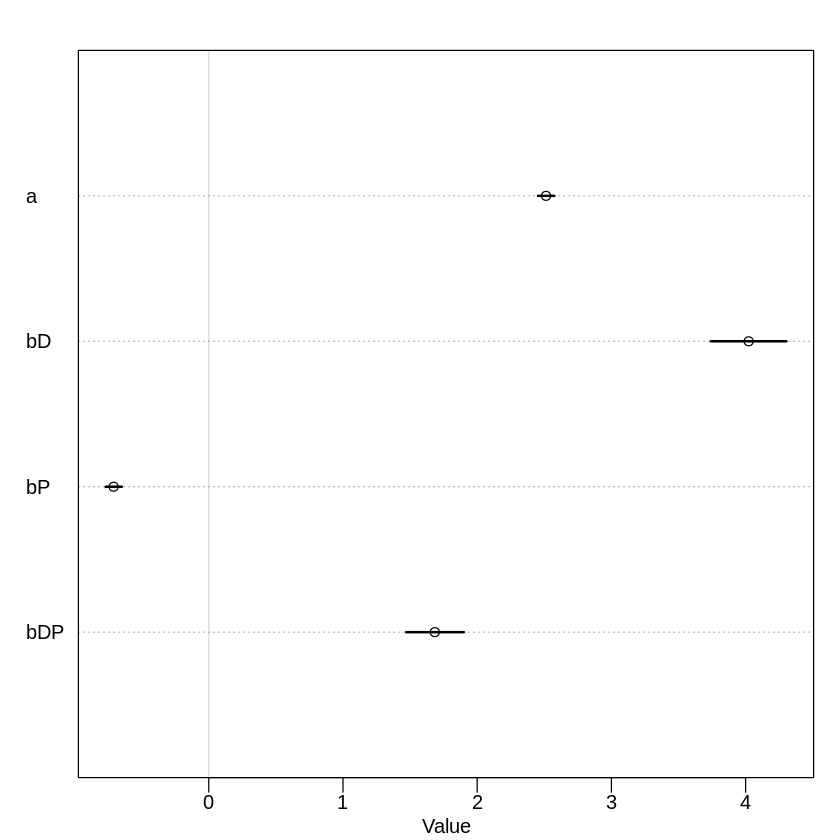

In [13]:
plot(precis(m11h3female))

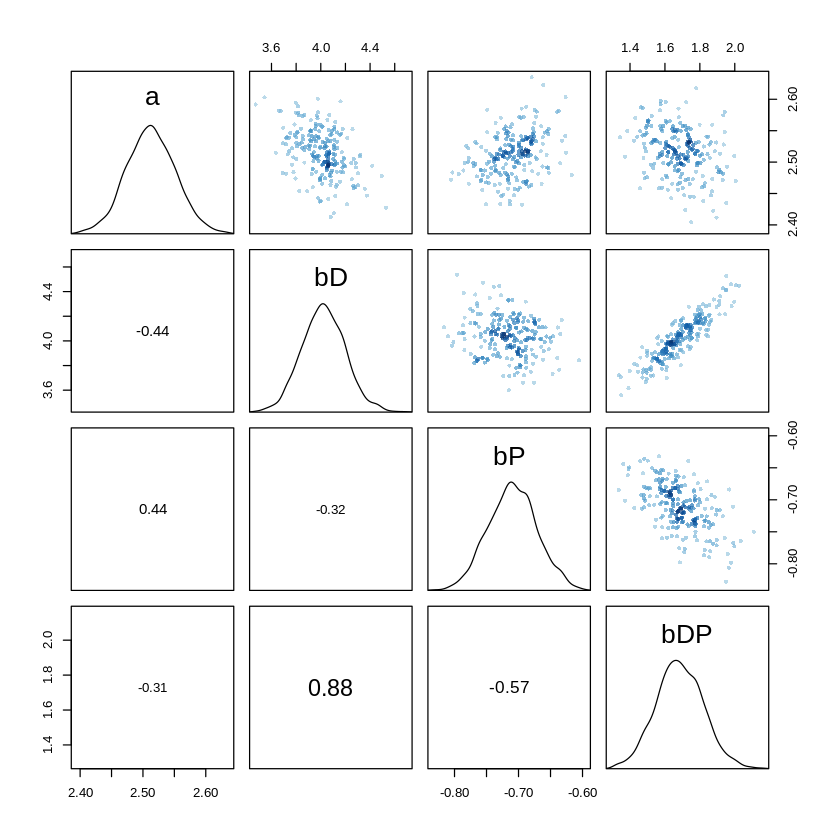

In [14]:
pairs(m11h3female)

Counterfactual stuff based on https://github.com/cavaunpeu/statistical-rethinking/blob/master/chapter-11/homework.R.  

We use the model m11h3gamIntDAM as this has the best WAIC scores involving f_std as a predictor.

We also try model m11h3gamIntPRES as this has the highest values of the bF coefficient, so should exhibit the greatest difference.


In [31]:
# # standardize predictors
# d$damage_norm_std <- (d$damage_norm - mean(d$damage_norm)) / sd(d$damage_norm)
# d$femininity_std <- (d$femininity - mean(d$femininity)) / sd(d$femininity)
# d$min_pressure_std <- (d$min_pressure - mean(d$min_pressure)) / sd(d$min_pressure)

d$D_norm <- normalize(d$damage_norm)
d$minPres_std <- standardize(d$min_pressure)
d$f_std <- standardize(d$femininity)

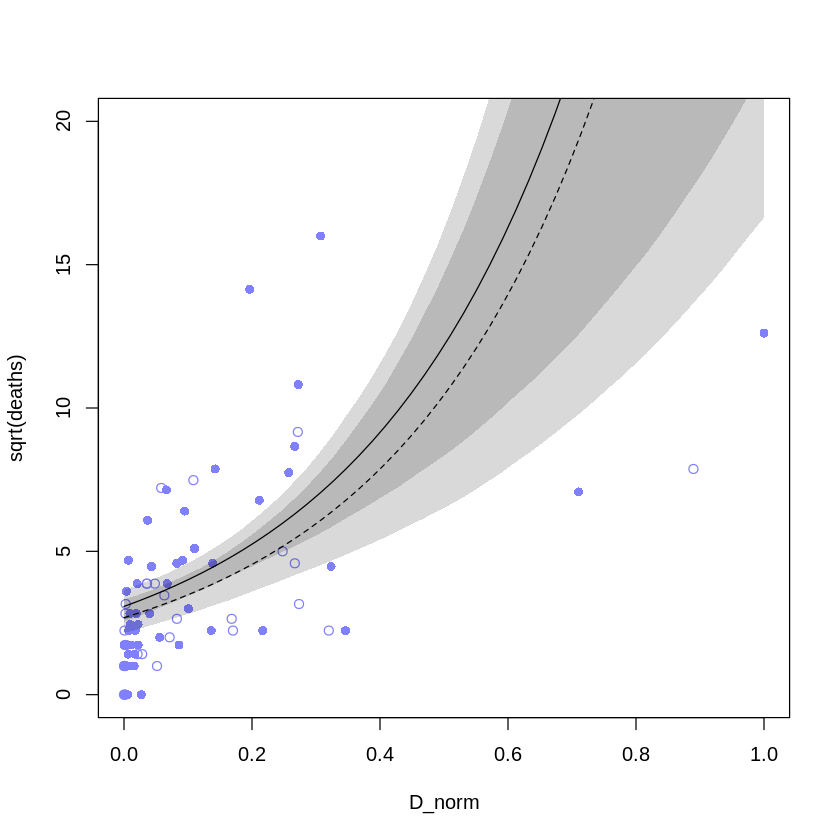

In [79]:
# plot counterfactuals using D_norm and model m11h3gamIntDAM (has the best WAIC scores)

damage.sequence <- seq(from = 0, to = 1, length.out = 50)

# "masculine" storms
prediction.data.maleDAM <- data.frame(
  f_std = -1.5,
  D_norm = damage.sequence,
  minPres_std = 0
)

# lambda.male <- link(model.11H1.single.interaction.damage, data = prediction.data.male)
lambda.maleDAM <- link(m11h3gamIntDAM, data = prediction.data.maleDAM)
lambda.male.muDAM <- apply(X = lambda.maleDAM, MARGIN = 2, FUN = mean)
lambda.male.PIDAM <- apply(X = lambda.maleDAM, MARGIN = 2, FUN = PI)

# "feminine" storms
prediction.data.femaleDAM <- data.frame(
  f_std = 1,
  D_norm = damage.sequence,
  minPres_std = 0
)

# lambda.female <- link(model.11H1.single.interaction.damage, data = prediction.data.female)
lambda.femaleDAM <- link(m11h3gamIntDAM, data = prediction.data.femaleDAM)
lambda.female.muDAM <- apply(X = lambda.femaleDAM, MARGIN = 2, FUN = mean)
lambda.female.PIDAM <- apply(X = lambda.femaleDAM, MARGIN = 2, FUN = PI)

# plot (on square root scale, per author's recommendation)
# plot(d$damage_norm_std, sqrt(d$deaths), pch=ifelse(d$femininity_std>0,16,1), col=rangi2, xlab="damage_norm", ylab="sqrt(deaths)")
plot(d$D_norm, sqrt(d$deaths), pch=ifelse(d$f_std>0,16,1), col=rangi2, xlab="D_norm", ylab="sqrt(deaths)", ylim=c(0,20))
lines( damage.sequence , sqrt(lambda.male.muDAM) , lty=2 )
shade( sqrt(lambda.male.PIDAM) , damage.sequence )
lines( damage.sequence , sqrt(lambda.female.muDAM) , lty=1 )
shade( sqrt(lambda.female.PIDAM) , damage.sequence )

Using the model with the best WAIC scores (m11h3gamIntDAM), it's true that the mean estimated lambda line is larger than the masculine one.  However, we can also see that the 89% credible intervals of the estimated values of lambda for male and female named hurricanes overlap.  The shaded region for males is much larger, reflecting the fact that only 32 of 92 hurricanes have masculine names, so around a third of hurricanes have masculine names.  Based on this analysis and model, there is no distinction between the estimated deaths of female named hurricanes to male hurricanes.

Now let's try the model where the bF coefficient values were the highest, such that we expect there to be a larger difference between male and female named hurricanes:

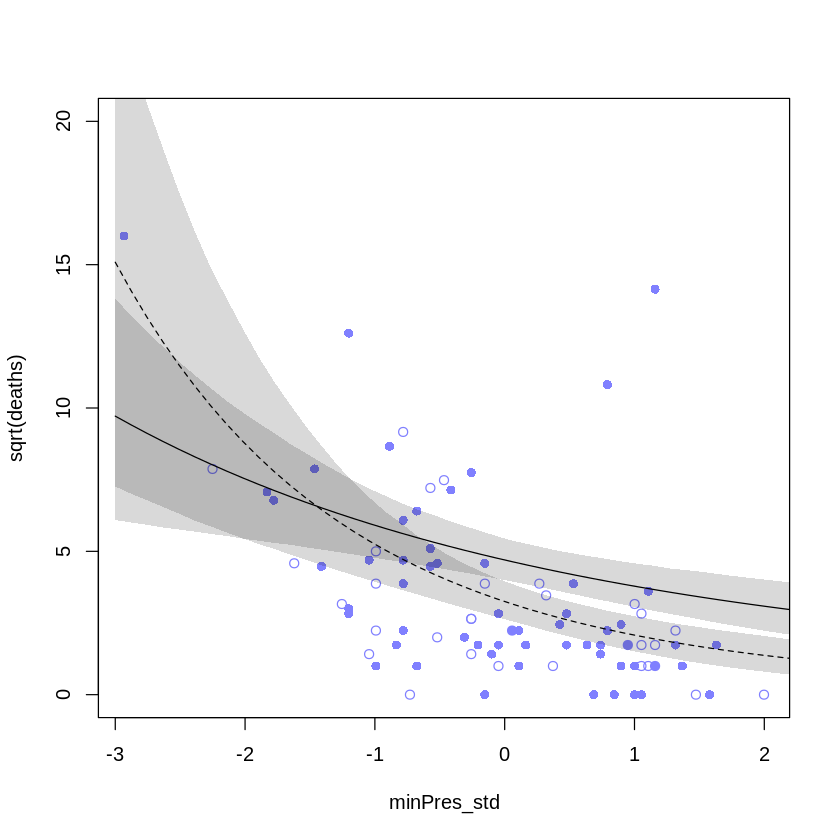

In [87]:
# plot counterfactuals using min_pressure and model m11h3gamIntPRES (has the highest bF coefficient values)

minPres_std.sequence <- seq(from = -3, to = 3, length.out = 50)

# "masculine" storms
prediction.data.malePRES <- data.frame(
  f_std = -1.5,
  D_norm = mean(normalize(d$damage_norm)),
  minPres_std = minPres_std.sequence
)

# lambda.male <- link(model.11H1.single.interaction.damage, data = prediction.data.male)
lambda.malePRES <- link(m11h3gamIntPRES, data = prediction.data.malePRES)
lambda.male.muPRES <- apply(X = lambda.malePRES, MARGIN = 2, FUN = mean)
lambda.male.PIPRES <- apply(X = lambda.malePRES, MARGIN = 2, FUN = PI)

# "feminine" storms
prediction.data.femalePRES <- data.frame(
  f_std = 1,
  D_norm = mean(normalize(d$damage_norm)),
  minPres_std = minPres_std.sequence
)

# lambda.female <- link(model.11H1.single.interaction.damage, data = prediction.data.female)
lambda.femalePRES <- link(m11h3gamIntPRES, data = prediction.data.femalePRES)
lambda.female.muPRES <- apply(X = lambda.femalePRES, MARGIN = 2, FUN = mean)
lambda.female.PIPRES <- apply(X = lambda.femalePRES, MARGIN = 2, FUN = PI)

# plot (on square root scale, per author's recommendation)
# plot(d$damage_norm_std, sqrt(d$deaths), pch=ifelse(d$femininity_std>0,16,1), col=rangi2, xlab="damage_norm", ylab="sqrt(deaths)")
plot(d$minPres_std, sqrt(d$deaths), pch=ifelse(d$f_std>0,16,1), col=rangi2, xlab="minPres_std", ylab="sqrt(deaths)", ylim=c(0,20))
lines( minPres_std.sequence , sqrt(lambda.male.muPRES) , lty=2 )
shade( sqrt(lambda.male.PIPRES) , minPres_std.sequence )
lines( minPres_std.sequence , sqrt(lambda.female.muPRES) , lty=1 )
shade( sqrt(lambda.female.PIPRES) , minPres_std.sequence )

The strongest hurricanes are ones with the lowest minimum pressure.  In this region we see massive overlap between male and female named hurricanes.  In fact, the mean estimated lambda and 89% credible interval for males predicts higher deaths at lower minimum pressures.  It is just that at higher minimum pressures where hurricanes are weaker (and more frequent), female named hurricanes appear to cause more deaths.  Again, this is probably because of the presence of a handful of outliers - most of the hurricanes that caused unexpectadly large numbers of deaths despite being relatively mild had female names, however as previously noted, most hurricanes have female names anyway (almost 2/3).  Of those hurricanes above both shaded regions, 6 and female names and 3 are males, a naming ratio of 2/3 female in proportion with the wider ratio of male to female names in the whole population.  So this increased prevalence of female names is likely the main reason why most of these outliers are female, and hence the higher expected number of deaths for female named hurricanes at high minimum pressures.

All in all, this suggests any releationship betweeen expected number of deaths and female names of hurricanes is likely to be spurious.

11H4

In [2]:
library(rethinking)
data(Hurricanes)
d <- Hurricanes

The model with the best WAIC score was m11h3gamIntBothNoF.  Note that this does not use femininity of name as a predictor.  We will, as the question asks, compare this model with one that uses the logarithm of the damage, D_norm.

In [3]:
dat6 <- list(deaths=d$deaths, D_norm=normalize(d$damage_norm), minPres_std=standardize(d$min_pressure))

In [16]:
m11h3gamIntBothNoF <- ulam(
                        alist(
                            deaths ~ dgampois(lamda, phi) ,
                            log(lamda) <- a + bD * D_norm + bP * minPres_std + bDP * (D_norm * minPres_std),
                            a ~ dnorm( 2, 1) ,               
                            bD ~ dnorm( 0, 2 ),    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                            bP ~ dnorm( 0, 1 ),
                            bDP ~ dnorm( 0, 0.2 )
                          , phi ~ dexp(1)
                        ), data=dat6
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [17]:
precis(m11h3gamIntBothNoF)

mean       sd        5.5%       94.5%      n_eff    Rhat     
a    2.1272516 0.1707351  1.8663699  2.4104891 1255.462 0.9995363
bD   4.7808983 0.9755984  3.2834267  6.3518782 1208.784 0.9992436
bP  -0.3688324 0.1308972 -0.5780580 -0.1606174 1565.388 1.0021051
bDP  0.1708748 0.1920231 -0.1306996  0.4775912 1775.190 1.0007562
phi  0.7040623 0.1075020  0.5507739  0.8864778 1578.330 1.0015177

The Kernel keeps dying if I use log(D_norm) as a predictor.  This may be because D_norm ranges from 0 to 1, so log(D_norm) ranges from -inf to 0.  For the several low strength hurricanes, log(D_norm) will persistently be very negative, so numerically it may be hard for the Hamiltonian MCMC to sample such a large region.  The solution is perhaps then to use log(damage_norm) instead, which ranges from 0 to 11.2.

The mapping from damage_norm to D_norm is linear, just being a rescaling such that damage_norm/max(damage_norm) = D_norm.  Therefore, if we were to use damage_norm instead in the m11h3gamIntBothNoF model above, it shouldn't change the inference, just the size of the coefficients bD and bDP (shouldn't they just be divided by the factor max(damage_norm) = 75,000?  We can, nevertheless, test this here too.

In [15]:
dat6logD <- list(deaths=d$deaths, log_D_norm=log(normalize(d$damage_norm)), minPres_std=standardize(d$min_pressure))
dat6logD$log_D_norm[which(dat6logD$log_D_norm==-Inf)] <- -100      #If we allow -Inf in the data, it kills the Kernel
(dat6logD$log_D_norm)

[1]   -3.8543699   -2.6405652   -6.2212838   -7.1821788   -8.5861727
 [6]   -1.3563340   -3.1453023   -1.1286871   -3.6099317   -1.6276564
[11]   -2.4930868   -3.8863419   -4.9355145   -5.1637731   -4.9927820
[16]   -0.3421202   -7.6988695   -1.5543684   -5.5247865   -2.4535497
[21]   -1.5288282   -3.2989885   -4.5418691   -1.3217925   -4.6335563
[26]   -6.6402626   -2.6963059   -4.5418691   -1.1802863   -2.3904562
[31]   -5.5247865   -5.0126240   -5.9319252   -1.3005193   -4.1528082
[36]   -2.4947013   -4.8813496   -7.0508428   -6.9911236   -3.3245934
[41]   -1.7704544   -3.5618224   -1.9757651   -5.2115149   -6.3654177
[46]   -6.1563259   -2.8874028   -3.2125491   -2.7637610   -4.0482113
[51]   -9.6157921   -7.1821788 -100.0000000  -10.1266178   -5.5588034
[56]   -1.3207930   -5.7915081   -3.0312770   -0.1168351   -6.6713532
[61]   -3.8173057   -2.2960597   -4.6755793   -2.2061713   -5.9319252
[66]   -3.8173057   -6.1563259   -2.9644787   -6.6926306   -2.2220369
[71]   -3.9604999   -4.0871570   -5.7077772   -2.7122457   -9.8389357
[76]   -1.2966110   -1.7822712   -6.0953313   -1.3949048   -1.9942051
[81]   -5.3701581   -3.3432926   -6.7254204   -1.9482596   -1.0609564
[86]   -7.3132071   -4.2140161   -2.8452321   -1.3034606   -2.3561132
[91]   -1.1394626    0.0000000

In [18]:
m11h3gamIntBothNoF_log <- ulam(
                        alist(
                            deaths ~ dgampois(lamda, phi) ,
                            log(lamda) <- a + bD * log_D_norm + bP * minPres_std + bDP * (log_D_norm * minPres_std),
                            a ~ dnorm( 2, 1) ,               
                            bD ~ dnorm( 0, 1 ),    # log_D_norm has max val of 0, and min value of -100
                            bP ~ dnorm( 0, 1 ),
                            bDP ~ dnorm( 0, 0.2 )
                          , phi ~ dexp(1)
                        ), data=dat6logD
                        , chains=4, cores=4, log_lik=TRUE
                    )

In [19]:
precis(m11h3gamIntBothNoF_log)

mean        sd         5.5%       94.5%      n_eff     Rhat     
a    4.41179391 0.25586216  4.0121564 4.84132305 1013.7198 1.0024598
bD   0.54749801 0.07169841  0.4319637 0.66039846  942.9369 1.0005496
bP  -0.18881987 0.16743327 -0.4671101 0.07110867 1198.3448 0.9997957
bDP -0.04387709 0.05313834 -0.1287195 0.03938682  939.0575 0.9986901
phi  1.01220585 0.16562566  0.7718268 1.29151504 1548.9972 0.9990036

The model with one of the best WAIC scores (especially considering the large size of dSE) but simpler with no interaction effects AND the femininity of the name as a predictor is m11h3gamMainEffDAM.  We will also have a look at this model with logarithm of D_norm.

In [20]:
dat3 <- list(deaths=d$deaths, f_std=standardize(d$femininity), D_norm=normalize(d$damage_norm))

In [21]:
m11h3gamMainEffDAM <- ulam(
                alist(
                    deaths ~ dgampois(lamda, phi) ,
                    phi ~ dexp(1) ,
                    log(lamda) <- a + bF * f_std + bD * D_norm ,
                    a ~ dnorm( 2, 1) ,               
                    bF ~ dnorm( 0, 1 ),    # max deaths is 256
                    bD ~ dnorm( 0, 2 )    # D_norm has max val of 1, so we allow bD prior to have double the standard deviation of bF
                ), data=dat3
                , chains=4, cores=4, log_lik=TRUE
            )

In [22]:
precis(m11h3gamMainEffDAM)

mean      sd         5.5%        94.5%     n_eff    Rhat    
phi 0.6624721 0.09856028  0.51485660 0.8322148 1199.598 1.002708
a   2.1078309 0.18338386  1.83267511 2.4049497 1137.555 1.000747
bF  0.1246525 0.12702841 -0.08241983 0.3196279 1573.610 1.002224
bD  5.3123484 1.04958887  3.59364788 6.9508706 1174.226 1.000210

In [26]:
dat3logD <- list(deaths=d$deaths, f_std=standardize(d$femininity), log_D_norm=log(normalize(d$damage_norm)))
dat3logD$log_D_norm[which(dat3logD$log_D_norm==-Inf)] <- -100      #If we allow -Inf in the data, it kills the Kernel
(dat3logD$log_D_norm)

[1]   -3.8543699   -2.6405652   -6.2212838   -7.1821788   -8.5861727
 [6]   -1.3563340   -3.1453023   -1.1286871   -3.6099317   -1.6276564
[11]   -2.4930868   -3.8863419   -4.9355145   -5.1637731   -4.9927820
[16]   -0.3421202   -7.6988695   -1.5543684   -5.5247865   -2.4535497
[21]   -1.5288282   -3.2989885   -4.5418691   -1.3217925   -4.6335563
[26]   -6.6402626   -2.6963059   -4.5418691   -1.1802863   -2.3904562
[31]   -5.5247865   -5.0126240   -5.9319252   -1.3005193   -4.1528082
[36]   -2.4947013   -4.8813496   -7.0508428   -6.9911236   -3.3245934
[41]   -1.7704544   -3.5618224   -1.9757651   -5.2115149   -6.3654177
[46]   -6.1563259   -2.8874028   -3.2125491   -2.7637610   -4.0482113
[51]   -9.6157921   -7.1821788 -100.0000000  -10.1266178   -5.5588034
[56]   -1.3207930   -5.7915081   -3.0312770   -0.1168351   -6.6713532
[61]   -3.8173057   -2.2960597   -4.6755793   -2.2061713   -5.9319252
[66]   -3.8173057   -6.1563259   -2.9644787   -6.6926306   -2.2220369
[71]   -3.9604999   -4.0871570   -5.7077772   -2.7122457   -9.8389357
[76]   -1.2966110   -1.7822712   -6.0953313   -1.3949048   -1.9942051
[81]   -5.3701581   -3.3432926   -6.7254204   -1.9482596   -1.0609564
[86]   -7.3132071   -4.2140161   -2.8452321   -1.3034606   -2.3561132
[91]   -1.1394626    0.0000000

In [27]:
m11h3gamMainEffDAMlog <- ulam(
                alist(
                    deaths ~ dgampois(lamda, phi) ,
                    phi ~ dexp(1) ,
                    log(lamda) <- a + bF * f_std + bD * log_D_norm ,
                    a ~ dnorm( 2, 1) ,               
                    bF ~ dnorm( 0, 1 ),    # max deaths is 256
                    bD ~ dnorm( 0, 1 )    # log_D_norm has max val of 0 and min of -100
                ), data=dat3logD
                , chains=4, cores=4, log_lik=TRUE
            )

In [28]:
precis(m11h3gamMainEffDAMlog)

mean       sd         5.5%       94.5%     n_eff     Rhat     
phi 1.02335724 0.16824857  0.7819864 1.3183395 1312.3389 1.0000071
a   4.46545295 0.19859351  4.1504642 4.7768545 1080.2834 0.9996153
bF  0.08043711 0.11357036 -0.1030511 0.2625055 1369.0507 0.9994860
bD  0.54537786 0.05023177  0.4646645 0.6238243  934.6536 1.0000176

In [29]:
compare(m11h3gamMainEffDAMlog, m11h3gamMainEffDAM, m11h3gamIntBothNoF_log, m11h3gamIntBothNoF)

WAIC     pWAIC    dWAIC     weight       SE      
m11h3gamMainEffDAMlog  630.6452 4.074926  0.000000 9.278030e-01 31.46765
m11h3gamIntBothNoF_log 635.7520 7.420564  5.106843 7.219697e-02 33.99305
m11h3gamIntBothNoF     669.0310 7.287319 38.385844 4.286232e-09 38.35972
m11h3gamMainEffDAM     672.0937 4.731991 41.448506 9.268877e-10 32.34380
                       dSE      
m11h3gamMainEffDAMlog         NA
m11h3gamIntBothNoF_log  6.155405
m11h3gamIntBothNoF     17.181009
m11h3gamMainEffDAM      9.762926

Indeed, the log_D_norm models seem to have better predictive ability than those that use D_norm in the log(lambda) link function.  The dSE is large enough for the NoF_log model to not be significantly worse than the MainEffDAMlog model at prediction.

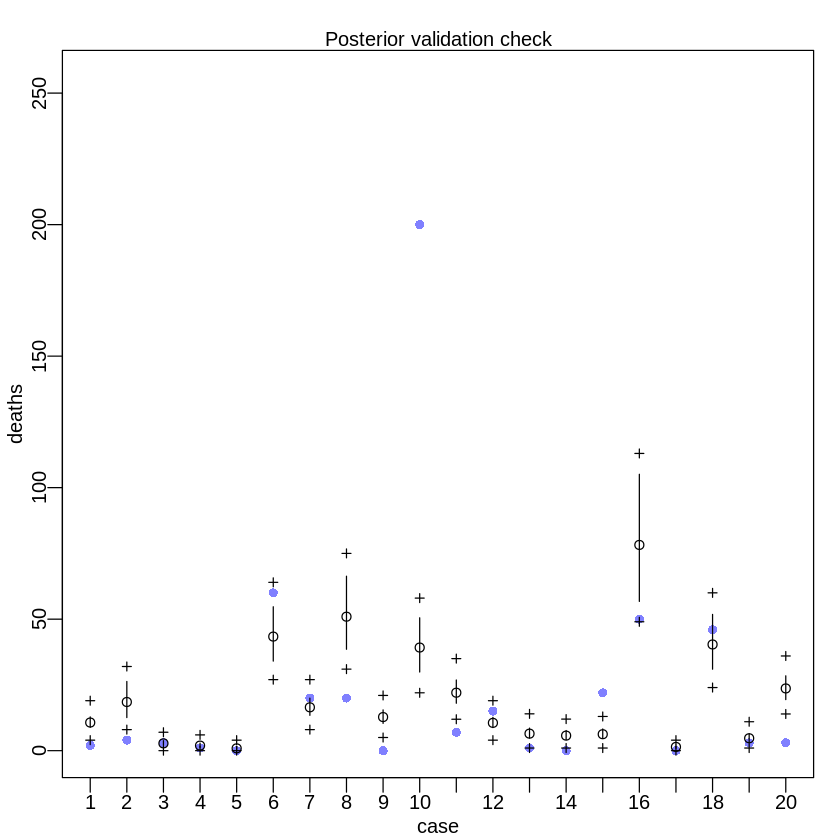

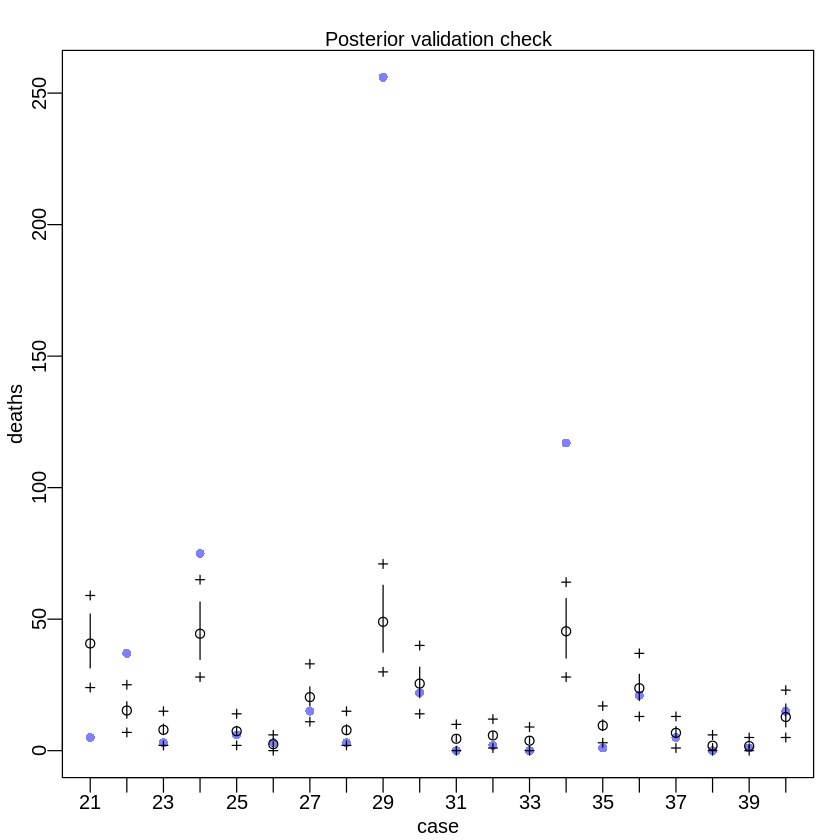

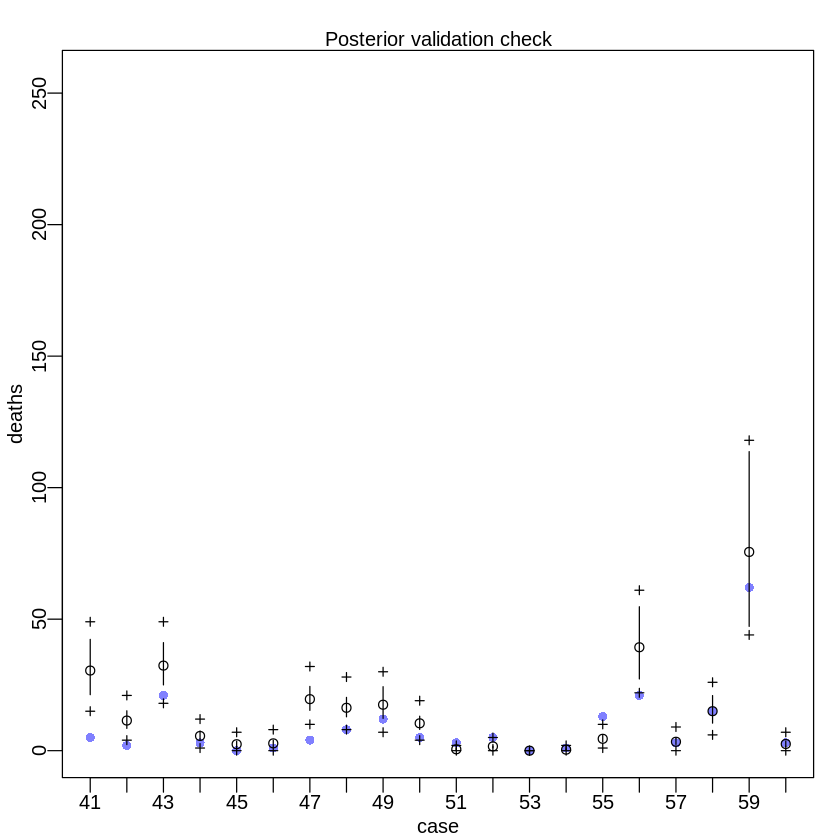

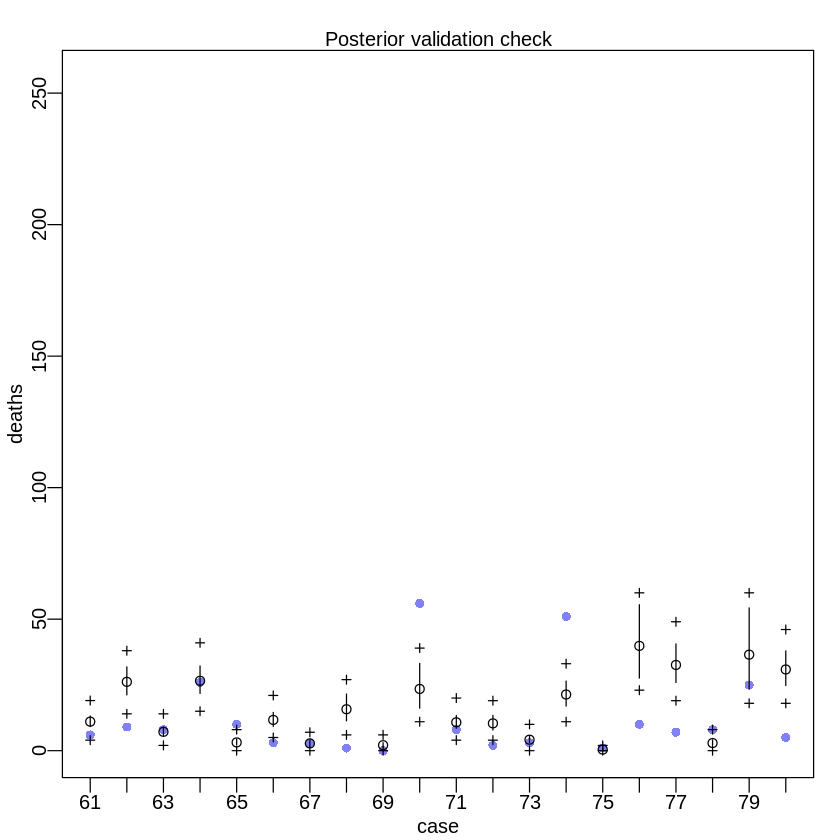

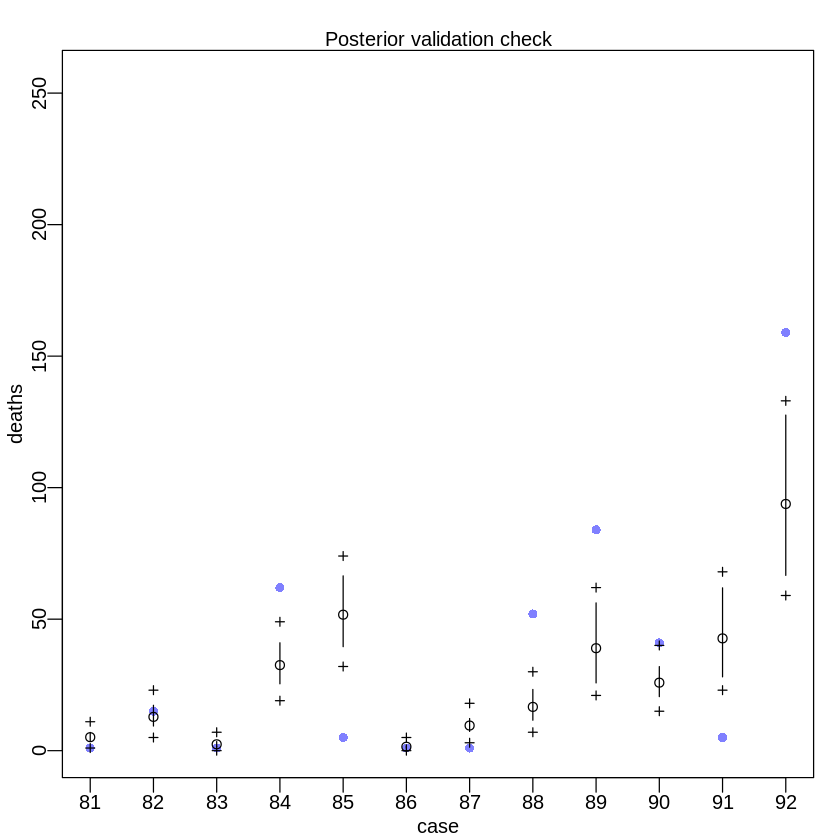

In [33]:
postcheck(m11h3gamMainEffDAMlog)

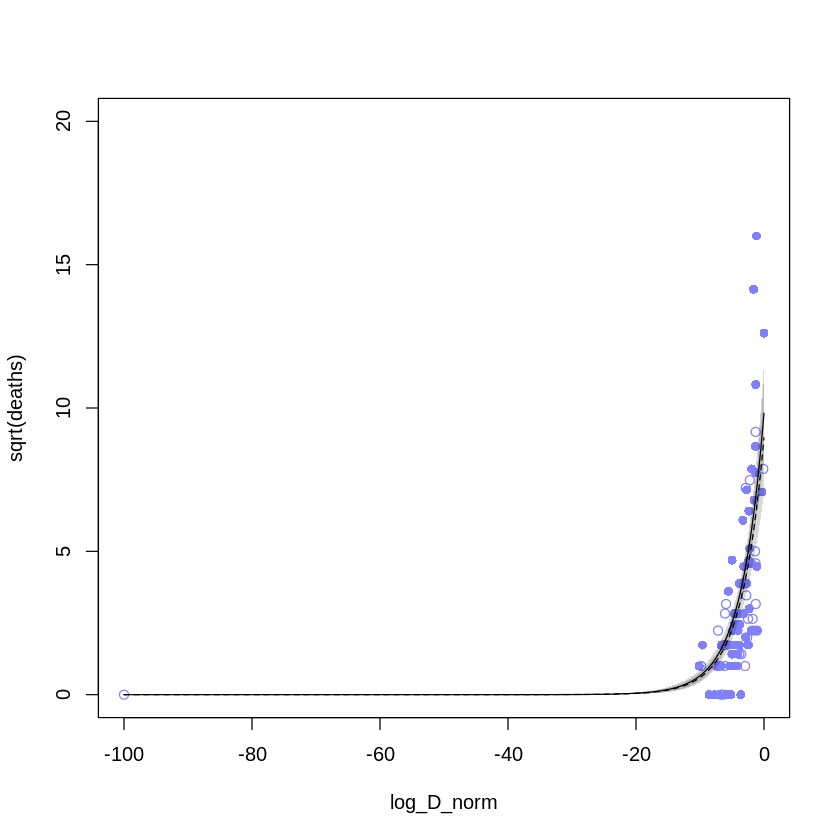

In [58]:
# plot counterfactuals using D_norm and model m11h3gamIntDAM (has the best WAIC scores)

log_D_norm.sequence <- seq(from = -100, to = 0, length.out = 200)

# "masculine" storms
prediction.data.maleDAM <- data.frame(
  f_std = -1.5,
  log_D_norm = log_D_norm.sequence
#   minPres_std = 0
)

# lambda.male <- link(model.11H1.single.interaction.damage, data = prediction.data.male)
lambda.maleDAM <- link(m11h3gamMainEffDAMlog, data = prediction.data.maleDAM)
lambda.male.muDAM <- apply(X = lambda.maleDAM, MARGIN = 2, FUN = mean)
lambda.male.PIDAM <- apply(X = lambda.maleDAM, MARGIN = 2, FUN = PI)

# "feminine" storms
prediction.data.femaleDAM <- data.frame(
  f_std = 1,
  log_D_norm = log_D_norm.sequence
#   minPres_std = 0
)

# lambda.female <- link(model.11H1.single.interaction.damage, data = prediction.data.female)
lambda.femaleDAM <- link(m11h3gamMainEffDAMlog, data = prediction.data.femaleDAM)
lambda.female.muDAM <- apply(X = lambda.femaleDAM, MARGIN = 2, FUN = mean)
lambda.female.PIDAM <- apply(X = lambda.femaleDAM, MARGIN = 2, FUN = PI)

# plot (on square root scale, per author's recommendation)
plot(dat3logD$log_D_norm, sqrt(dat3logD$deaths), pch=ifelse(dat3logD$f_std>0,16,1), col=rangi2, xlab="log_D_norm", ylab="sqrt(deaths)", ylim=c(0,20), xlim=c(-100,0))
lines( log_D_norm.sequence , sqrt(lambda.male.muDAM) , lty=2 )
shade( sqrt(lambda.male.PIDAM) , log_D_norm.sequence )
lines( log_D_norm.sequence , sqrt(lambda.female.muDAM) , lty=1 )
shade( sqrt(lambda.female.PIDAM) , log_D_norm.sequence )

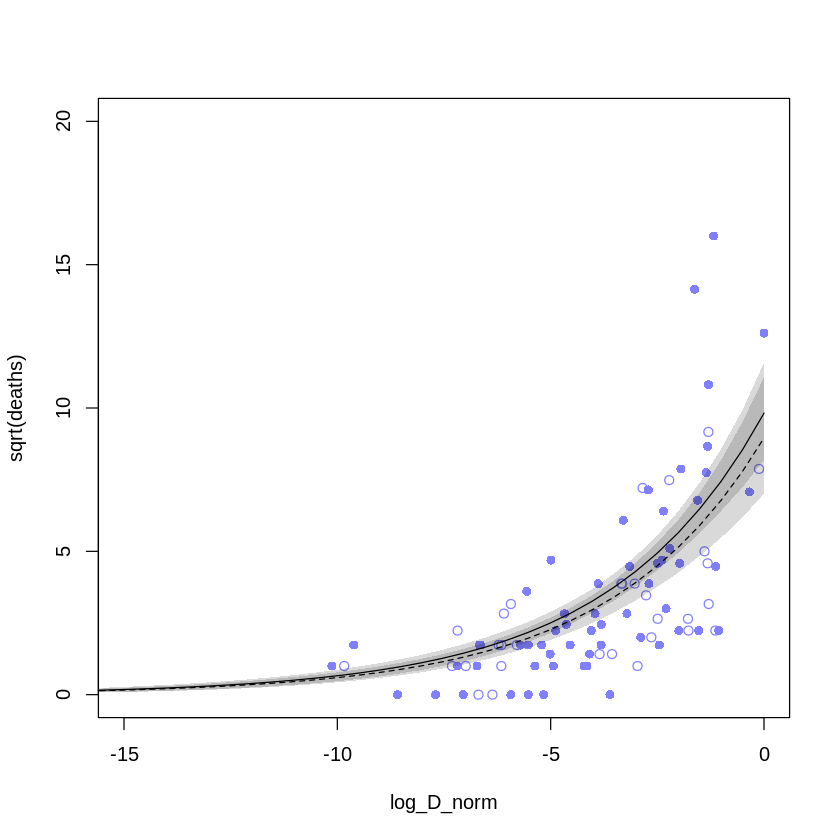

In [59]:
# plot (on square root scale, per author's recommendation)
plot(dat3logD$log_D_norm, sqrt(dat3logD$deaths), pch=ifelse(dat3logD$f_std>0,16,1), col=rangi2, xlab="log_D_norm", ylab="sqrt(deaths)", ylim=c(0,20), xlim=c(-15,0))
lines( log_D_norm.sequence , sqrt(lambda.male.muDAM) , lty=2 )
shade( sqrt(lambda.male.PIDAM) , log_D_norm.sequence )
lines( log_D_norm.sequence , sqrt(lambda.female.muDAM) , lty=1 )
shade( sqrt(lambda.female.PIDAM) , log_D_norm.sequence )

And indeed, in this case we see that there is massive overlap between male and female lambda estimates.  Let's see in D_norm space too:

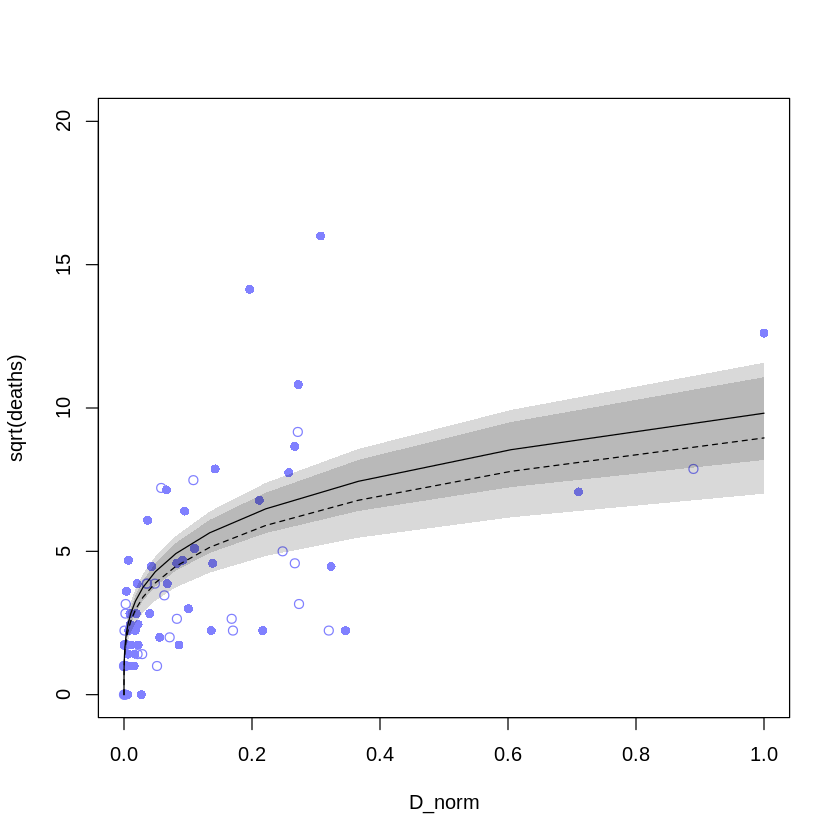

In [57]:
# plot (on square root scale, per author's recommendation)
plot(exp(dat3logD$log_D_norm), sqrt(dat3logD$deaths), pch=ifelse(dat3logD$f_std>0,16,1), col=rangi2, xlab="D_norm", ylab="sqrt(deaths)", ylim=c(0,20), xlim=c(0,1))
lines( exp(log_D_norm.sequence) , sqrt(lambda.male.muDAM) , lty=2 )
shade( sqrt(lambda.male.PIDAM) , exp(log_D_norm.sequence) )
lines( exp(log_D_norm.sequence) , sqrt(lambda.female.muDAM) , lty=1 )
shade( sqrt(lambda.female.PIDAM) , exp(log_D_norm.sequence) )

Again, there is massive overlap between male and female named hurricanes.  So any such causation between gender of names and deaths appears purely spurious and naively observed due to more hurricanes having female rather than male names, such that there are more female outliers than men.

Let's see how well the other model fits the data (noting that there is no femininity predictor in this model, so no point in plotting separately for male and female named hurricanes.  This time, we also simulate the number of deaths.

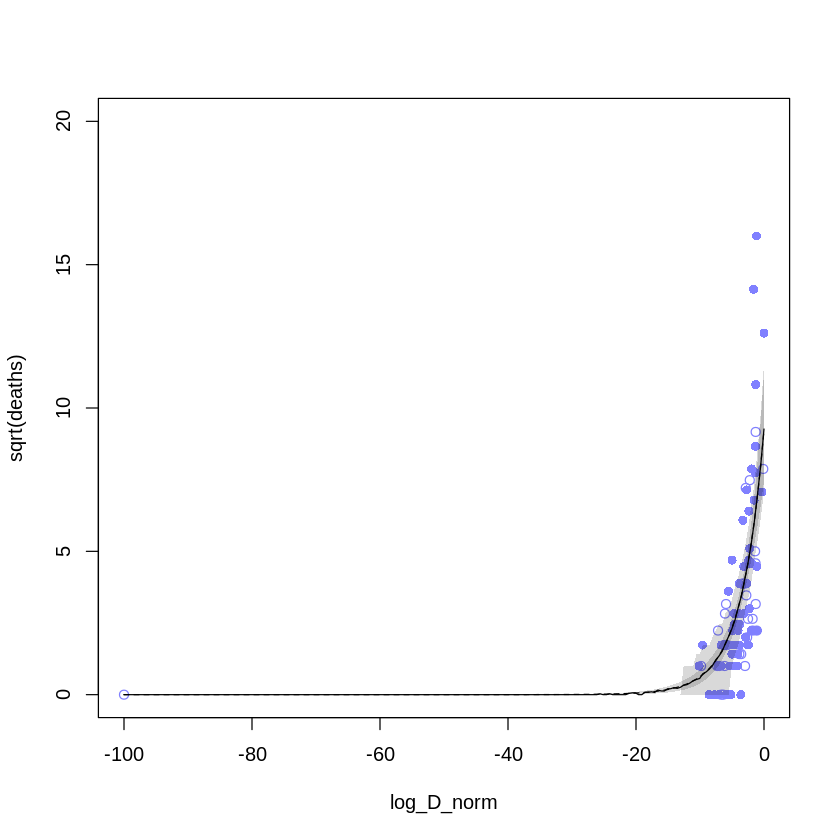

In [79]:
# plot counterfactuals using D_norm and model m11h3gamIntDAM (has the best WAIC scores)

log_D_norm.sequence <- seq(from = -100, to = 0, length.out = 200)


prediction.data.DAM <- data.frame(
  log_D_norm = log_D_norm.sequence,
  minPres_std = 0
)

lambda.DAM <- link(m11h3gamIntBothNoF_log, data = prediction.data.DAM)
lambda.muDAM <- apply(X = lambda.maleDAM, MARGIN = 2, FUN = mean)
lambda.PIDAM <- apply(X = lambda.maleDAM, MARGIN = 2, FUN = PI)

deaths.DAM <- sim(m11h3gamIntBothNoF_log, data = prediction.data.DAM)
lambda.meanDeathsDAM <- apply(X = deaths.DAM, MARGIN = 2, FUN = mean)
lambda.PIdeathsDAM <- apply(X = deaths.DAM, MARGIN = 2, FUN = PI)

# plot (on square root scale, per author's recommendation)
plot(dat6logD$log_D_norm, sqrt(dat6logD$deaths), pch=ifelse(dat3logD$f_std>0,16,1), col=rangi2, xlab="log_D_norm", ylab="sqrt(deaths)", ylim=c(0,20), xlim=c(-100,0))
lines( log_D_norm.sequence , sqrt(lambda.muDAM) , lty=2 )
shade( sqrt(lambda.PIDAM) , log_D_norm.sequence )
lines( log_D_norm.sequence , sqrt(lambda.meanDeathsDAM) , lty=1 )
shade( sqrt(lambda.PIdeathsDAM) , log_D_norm.sequence )

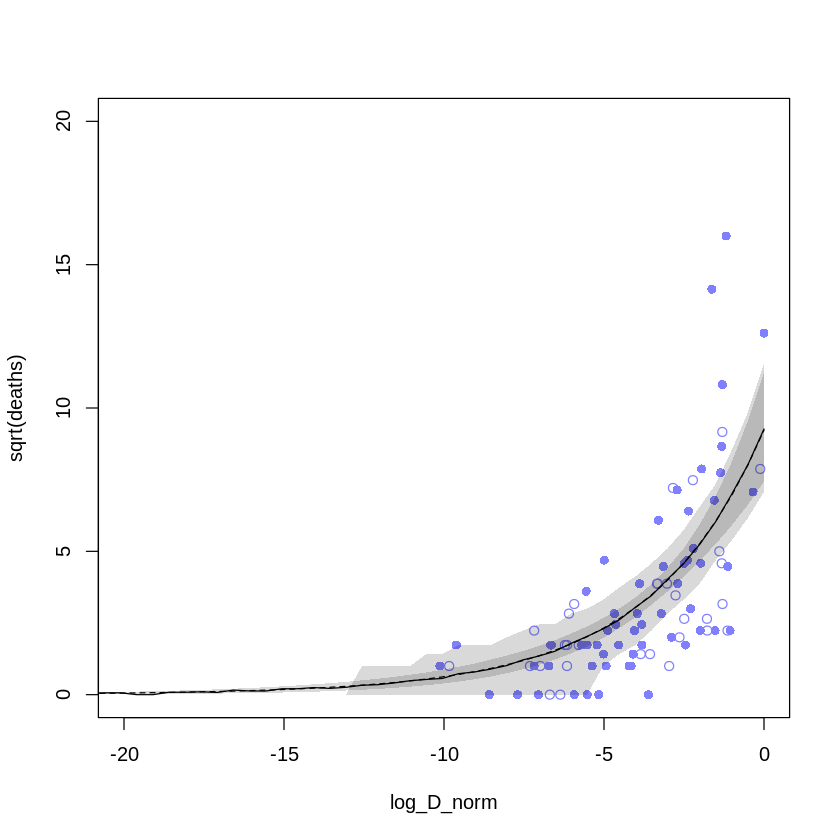

In [80]:
# plot (on square root scale, per author's recommendation)
plot(dat6logD$log_D_norm, sqrt(dat6logD$deaths), pch=ifelse(dat3logD$f_std>0,16,1), col=rangi2, xlab="log_D_norm", ylab="sqrt(deaths)", ylim=c(0,20), xlim=c(-20,0))
lines( log_D_norm.sequence , sqrt(lambda.muDAM) , lty=2 )
shade( sqrt(lambda.PIDAM) , log_D_norm.sequence )
lines( log_D_norm.sequence , sqrt(lambda.meanDeathsDAM) , lty=1 )
shade( sqrt(lambda.PIdeathsDAM) , log_D_norm.sequence )

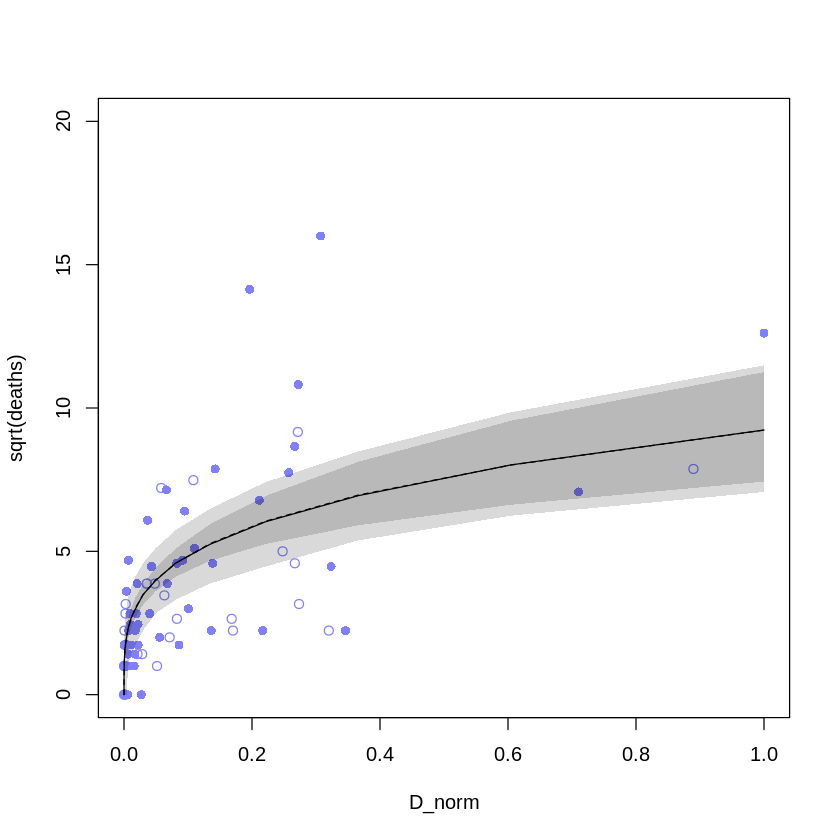

In [78]:
# plot (on square root scale, per author's recommendation)
plot(exp(dat6logD$log_D_norm), sqrt(dat6logD$deaths), pch=ifelse(dat3logD$f_std>0,16,1), col=rangi2, xlab="D_norm", ylab="sqrt(deaths)", ylim=c(0,20), xlim=c(0,1))
lines( exp(log_D_norm.sequence) , sqrt(lambda.muDAM) , lty=2 )
shade( sqrt(lambda.PIDAM) , exp(log_D_norm.sequence) )
lines( exp(log_D_norm.sequence) , sqrt(lambda.meanDeathsDAM) , lty=1 )
shade( sqrt(lambda.PIdeathsDAM) , exp(log_D_norm.sequence) )

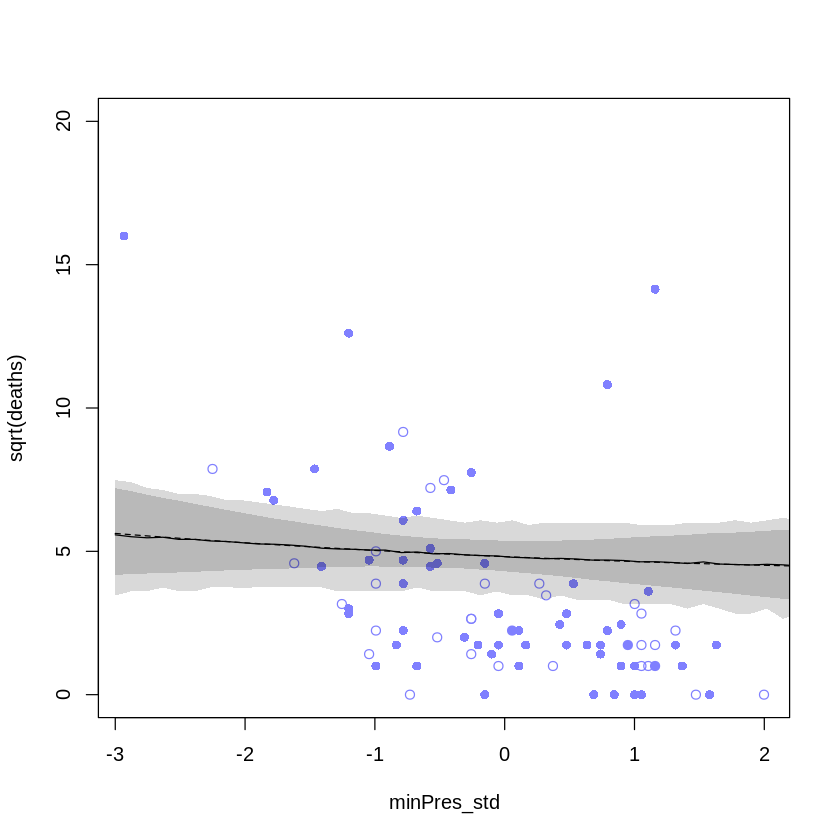

In [76]:
minPres_std.sequence <- seq(from = -3, to = 3, length.out = 50)

prediction.data.PRES <- data.frame(
  log_D_norm = log(mean(normalize(d$damage_norm))),
  minPres_std = minPres_std.sequence
)

lambda.PRES <- link(m11h3gamIntBothNoF_log, data = prediction.data.PRES)
lambda.muPRES <- apply(X = lambda.PRES, MARGIN = 2, FUN = mean)
lambda.PIPRES <- apply(X = lambda.PRES, MARGIN = 2, FUN = PI)

deaths.PRES <- sim(m11h3gamIntBothNoF_log, data = prediction.data.PRES)
lambda.meanDeathsPRES <- apply(X = deaths.PRES, MARGIN = 2, FUN = mean)
lambda.PIdeathsPRES <- apply(X = deaths.PRES, MARGIN = 2, FUN = PI)

# plot (on square root scale, per author's recommendation)
plot(dat6logD$minPres_std, sqrt(dat6logD$deaths), pch=ifelse(dat3logD$f_std>0,16,1), col=rangi2, xlab="minPres_std", ylab="sqrt(deaths)", ylim=c(0,20))
lines( minPres_std.sequence , sqrt(lambda.muPRES) , lty=2 )
shade( sqrt(lambda.PIPRES) , minPres_std.sequence )
lines( minPres_std.sequence , sqrt(lambda.meanDeathsPRES) , lty=1 )
shade( sqrt(lambda.PIdeathsPRES) , minPres_std.sequence )

11H5

"One hypothesis from developmental psychology, usually attributed to Carol Gilligan, proposes that women and men have different average tendencies in moral reasoning. Like most hypotheses in social psychology, it is merely descriptive. The notion is that women are more concerned with care (avoiding harm), while men are more concerned with justice and rights.  Culture-bound nonsense? Yes. Descriptively accurate? Maybe.

Evaluate this hypothesis, using the Trolley data, supposing that contact provides a proxy for
physical harm. Are women more or less bothered by contact than are men, in these data? Figure out
the model(s) that is needed to address this question."

We could investigate this question narrowly, as the question suggests at the end, just to focus on whether women are more or less bothered by contact.

Should we investigate more widely though, making inferences about the meaning of action and intention?  For example, if men are more concerned with justice and rights, does that mean that men would be more bothered by intention (or action)?

Clearly, either way, we need a model with coefficients indexed by gender.

How should we present the data?  A sort of triptych as in the book's Figure 12.6 on page 397?

Contact implies action.  If we do a triptych with contact on the bottom, whenever contact = 1, this implies action = 1; whenever contact = 0, there are two options: (i) action = 0, (ii) action = 1.  Then, for each possibility, there are two further choices: with or without intention.  This leads not to a triptych, but a series of four figures.  In fact, we need to compare male and female, so there would be 8 figures if we did genders separately.

In fact, if we really want to isolate contact, we ought to only compare (action=1, contact=0) on the left of each of the triptych figures, to (action=1, contact=1) on the right, given that moving from (action=0, contact=0) to (action=1, contact=1) changes two distinct psychological issues (as described in the literature).

So perhaps we only need two figures per gender.  (action=1, intention=0) and (action=1, intention=1), with the left of each figure being contact=0, and the right being contact=1.  Then do each of these for male and female, so four figures in total.

What if we were to also explore the hypothesis about intention as a proxy for justice and rights?
    
In this we would also compare figures for males and females.  For each gender, we would provide figures with intention on the bottom as in the book's Figure 12.6 on page 397, and it would be a triptych for each gender.  The idea being that males are more effected by intention than females.

We could try to plot males and females on the same chart, we would have to use different colours to make it clear.

In [2]:
library(rethinking)

data(Trolley)
d <- Trolley

d$gender <- ifelse(d$male == 0, 1L, 2L)          #Females are index 1, males are index 2
head(d)

dat <- list(
R = d$response,
A = d$action,
I = d$intention,
C = d$contact,
gid = d$gender)

case  response order id     age male edu           action intention contact
1 cfaqu 4         2    96;434 14  0    Middle School 0      0         1      
2 cfbur 3        31    96;434 14  0    Middle School 0      0         1      
3 cfrub 4        16    96;434 14  0    Middle School 0      0         1      
4 cibox 3        32    96;434 14  0    Middle School 0      1         1      
5 cibur 3         4    96;434 14  0    Middle School 0      1         1      
6 cispe 3         9    96;434 14  0    Middle School 0      1         1      
  story action2 gender
1 aqu   1       1     
2 bur   1       1     
3 rub   1       1     
4 box   1       1     
5 bur   1       1     
6 spe   1       1

Should we just use the same model in the book, with an interaction term between intention and the other predictors?

What justification is there to include interaction between action and contact, and between action AND contact AND intention?

The situation is complicated because contact implies action, so we never do get the pure contact main effect of (A=0, C=1), we just get the (lack of) main effect (A=0,C=0), the main effect (A=1,C=0), and a pseudo interaction effect (A=1,C=1).  So for an interaction affect, A * C = 0 whenever C=0, and A * C = 1 whenever C=1, regardless of what A is.  So C is an interaction effect already, and A * C is an indicator for C.  No need to include this in the model.

The data contains action2, which is A OR C, could this be used in some way in the model?  (A=0,C=0) implies action2 = 0.  (A=1, C=0), (A=0, C=1), and (A=1, C=1) all have action2 = 1.  So this shows a difference between A=0,C=0 and the rest; this is an indicator for A=0,C=0.  As discussed above, as we are interested purely in the change that contact makes, we will assume A=1 for the figures, so no need to use action2, as action2=1 in all these cases.

In [26]:
m11H5 <- ulam(
            alist(
                R ~ dordlogit( phi , cutpoints ),
#                 phi <- bA[gid]*A + bC[gid]*C + BI[gid]*I ,
#                 BI <- bI[gid] + bIA[gid]*A + bIC[gid]*C ,
                phi <- bA[gid]*A + bC[gid]*C + bI[gid]*I + bIA[gid]*I*A + bIC[gid]*I*C,
                bA[gid] ~ dnorm( 0 , 0.5 ),
                bI[gid] ~ dnorm( 0 , 0.5 ),
                bC[gid] ~ dnorm( 0 , 0.5 ),
                bIA[gid] ~ dnorm( 0 , 0.5 ),
                bIC[gid] ~ dnorm( 0 , 0.5 ),
                cutpoints ~ dnorm( 0 , 1.5 )
            ) , data=dat , chains=4 , cores=4 )

In [118]:
precis(m11H5, depth=2)

mean         sd         5.5%        94.5%        n_eff   
bA[1]        -0.753540446 0.06290383 -0.85469501 -0.652534674 1520.986
bA[2]        -0.244774774 0.06090394 -0.34140408 -0.148039478 1337.699
bI[1]        -0.667481930 0.06932621 -0.78045883 -0.556800816 1253.341
bI[2]         0.005823943 0.06577809 -0.09885715  0.114123172 1336.249
bC[1]        -0.609140767 0.08970188 -0.75435189 -0.461302094 1731.276
bC[2]        -0.138215762 0.07976502 -0.26624098 -0.009101843 1653.084
bIA[1]       -0.025236129 0.10298266 -0.19018168  0.139336968 1534.073
bIA[2]       -0.764344855 0.10094692 -0.93396983 -0.608409038 1483.360
bIC[1]       -0.770576785 0.13252882 -0.98753005 -0.559256058 1734.678
bIC[2]       -1.601300762 0.12258206 -1.79687203 -1.404892970 1585.846
cutpoints[1] -2.657279802 0.04946108 -2.73786556 -2.577934198 1220.315
cutpoints[2] -1.962697679 0.04591709 -2.03360685 -1.889582465 1160.538
cutpoints[3] -1.363766792 0.04370938 -1.43208019 -1.294732772 1038.083
cutpoints[4] -0.314818652 0.04129864 -0.38021648 -0.250428072 1021.461
cutpoints[5]  0.368320201 0.04160570  0.30229878  0.434069513 1078.072
cutpoints[6]  1.288604654 0.04498031  1.21777225  1.361293390 1331.786
             Rhat     
bA[1]        1.0022683
bA[2]        1.0019109
bI[1]        1.0026942
bI[2]        1.0022375
bC[1]        0.9996523
bC[2]        1.0023303
bIA[1]       1.0019551
bIA[2]       1.0002097
bIC[1]       1.0008538
bIC[2]       1.0006524
cutpoints[1] 1.0012522
cutpoints[2] 1.0018753
cutpoints[3] 1.0030684
cutpoints[4] 1.0041204
cutpoints[5] 1.0041455
cutpoints[6] 1.0044302

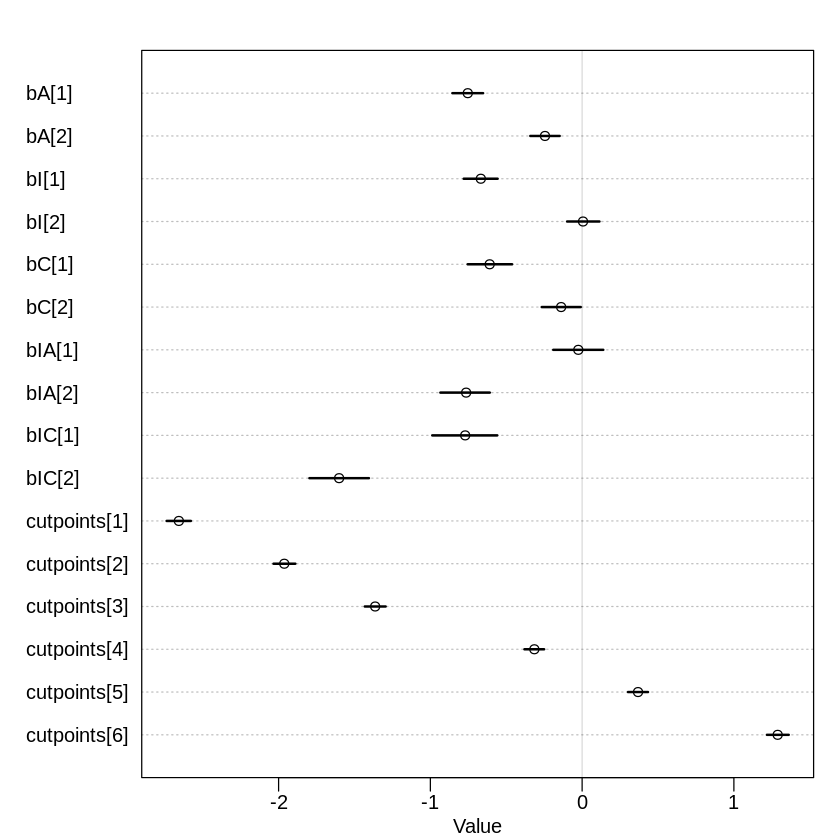

In [119]:
plot(precis(m11H5, depth=2))

In [110]:
m11H5b <- ulam(
            alist(
                R ~ dordlogit( phi , cutpoints ),
                phi <- bA[gid]*A + bC[gid]*C + BI[gid]*I ,
                BI <- bI[gid] + bIA[gid]*A + bIC[gid]*C ,
#                 phi <- bA[gid]*A + bC[gid]*C + bI[gid]*I + bIA[gid]*I*A + bIC[gid]*I*C,
                bA[gid] ~ dnorm( 0 , 0.5 ),
                bI[gid] ~ dnorm( 0 , 0.5 ),
                bC[gid] ~ dnorm( 0 , 0.5 ),
                bIA[gid] ~ dnorm( 0 , 0.5 ),
                bIC[gid] ~ dnorm( 0 , 0.5 ),
                cutpoints ~ dnorm( 0 , 1.5 )
            ) , data=dat , chains=4 , cores=4 )

recompiling to avoid crashing R session


In [111]:
precis(m11H5b, depth=2)

mean          sd         5.5%        94.5%      n_eff    
bA[1]        -0.9521771968 0.04993263 -1.03328812 -0.8733631 1134.6618
bA[2]        -0.4759215246 0.04821834 -0.54979973 -0.3975804 1342.2474
bI[1]        -0.3583561450 0.32999808 -0.90326643  0.1630942 1146.3638
bI[2]        -0.0153148815 0.50049270 -0.83178132  0.7821965 2378.7859
bC[1]        -1.1518676311 0.06562215 -1.25609783 -1.0435181 1471.9753
bC[2]        -0.7632894205 0.06309196 -0.86581788 -0.6644947 1676.1603
bIA[1]        0.0005771573 0.50572164 -0.81171685  0.8052257 2528.1724
bIA[2]        0.0085172903 0.49062362 -0.77624987  0.8205237 1886.5475
bIC[1]       -0.3603513874 0.33168501 -0.88889974  0.1761042 1154.3760
bIC[2]       -0.0149835157 0.51613260 -0.83689706  0.8139645 2252.0183
cutpoints[1] -2.8351226471 0.04899335 -2.91332266 -2.7566410  958.8883
cutpoints[2] -2.1539896083 0.04474889 -2.22382241 -2.0813220 1024.4415
cutpoints[3] -1.5692650733 0.04071667 -1.63439334 -1.5045917 1068.5848
cutpoints[4] -0.5386325131 0.03696447 -0.59828892 -0.4809659 1085.7677
cutpoints[5]  0.1357896341 0.03727825  0.07626892  0.1941904 1108.2747
cutpoints[6]  1.0489320127 0.03962476  0.98668367  1.1122427 1373.0795
             Rhat     
bA[1]        1.0016788
bA[2]        0.9997687
bI[1]        1.0071230
bI[2]        0.9997542
bC[1]        0.9999911
bC[2]        0.9995562
bIA[1]       0.9993164
bIA[2]       1.0007553
bIC[1]       1.0069249
bIC[2]       1.0011301
cutpoints[1] 1.0007750
cutpoints[2] 1.0000524
cutpoints[3] 1.0010081
cutpoints[4] 1.0014800
cutpoints[5] 1.0013372
cutpoints[6] 1.0022358

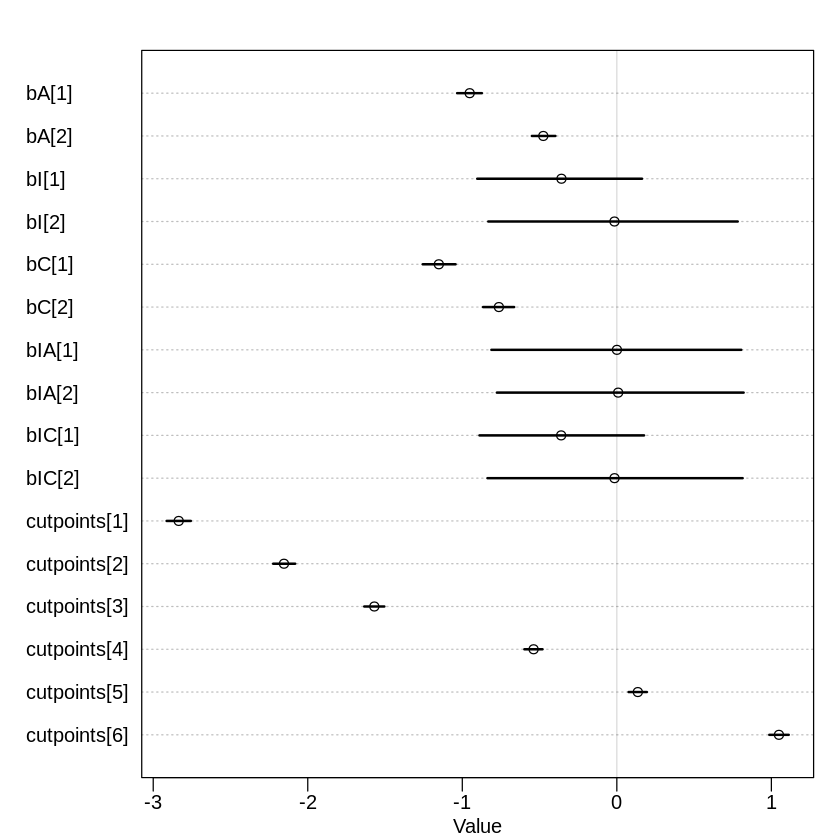

In [113]:
plot( precis(m11H5b, depth=2) )

A worrying things about m11H5 and m11H5b is that they are equivalent models, yet the estimates are different!!!

How is this possible?

The problem with all the above models is that the cutpoints are not gender specific.  In order to get gender specific cutpoints (without the Kernel dying), it seems necessary to split the data by gender before passing it to the model, which we do below.

In [12]:
dmale <- d[which(d$male==1),]
dfemale <- d[which(d$male==0),]

In [13]:
dat_male <- list(
R = dmale$response,
A = dmale$action,
I = dmale$intention,
C = dmale$contact)

dat_female <- list(
R = dfemale$response,
A = dfemale$action,
I = dfemale$intention,
C = dfemale$contact)

In [15]:
m11H5male <- ulam(
            alist(
                R ~ dordlogit( phi , cutpoints ),
                phi <- bA*A + bC*C + BI*I ,
                BI <- bI + bIA*A + bIC*C ,
                c(bA, bI, bC, bIA, bIC) ~ dnorm( 0 , 0.5 ),
                cutpoints ~ dnorm( 0 , 1.5 )
            ) , data=dat_male , chains=4 , cores=4 )

In [40]:
m11H5maleQ <- quap(
            alist(
                R ~ dordlogit( phi , c(a1,a2,a3,a4,a5,a6) ),
                phi <- bA*A + bC*C + BI*I ,
                BI <- bI + bIA*A + bIC*C ,
                c(bA, bI, bC, bIA, bIC) ~ dnorm( 0 , 0.5 ),
#                 cutpoints ~ dnorm( 0 , 1.5 )
                c(a1,a2,a3,a4,a5,a6) ~ dnorm( 0 , 1.5 )
            ) , data=dat_male
            , start=list(a1=-2,a2=-1,a3=0,a4=1,a5=2,a6=2.5) 
)

In [21]:
precis(m11H5male, depth=2)

mean        sd         5.5%       94.5%      n_eff    Rhat     
bIC          -1.09253455 0.12989631 -1.2958911 -0.8790119 1215.130 1.0002418
bIA          -0.35340407 0.10344033 -0.5186032 -0.1881405 1188.376 1.0026658
bC           -0.45418785 0.08969579 -0.6009476 -0.3103307 1156.594 1.0001384
bI           -0.31513364 0.07663476 -0.4378342 -0.1906747 1081.056 1.0023764
bA           -0.55818290 0.07232342 -0.6722380 -0.4419992 1155.006 1.0003364
cutpoints[1] -2.55783832 0.06796402 -2.6692051 -2.4512893 1090.259 0.9995797
cutpoints[2] -2.03836020 0.06396207 -2.1414902 -1.9369366 1115.767 1.0005779
cutpoints[3] -1.57365325 0.06106845 -1.6727464 -1.4784788 1092.077 1.0010583
cutpoints[4] -0.66924011 0.05853770 -0.7646462 -0.5776495 1118.735 0.9999602
cutpoints[5] -0.03669899 0.05867445 -0.1321484  0.0545524 1087.103 0.9995511
cutpoints[6]  0.85308250 0.05981228  0.7546903  0.9489615 1216.450 1.0008329

In [44]:
precis(m11H5maleQ, depth=2)

mean        sd         5.5%       94.5%      
a1  -2.55116858 0.06653888 -2.6575106 -2.44482660
a2  -2.03261277 0.06272422 -2.1328582 -1.93236734
a3  -1.56883330 0.06019597 -1.6650381 -1.47262851
a4  -0.66509319 0.05716204 -0.7564492 -0.57373721
a5  -0.03402373 0.05653740 -0.1243814  0.05633395
a6   0.85565518 0.05832009  0.7624484  0.94886194
bA  -0.55461354 0.07023125 -0.6668566 -0.44237044
bI  -0.31101793 0.07419630 -0.4295979 -0.19243791
bC  -0.45060120 0.08878753 -0.5925008 -0.30870158
bIA -0.35591831 0.10251374 -0.5197551 -0.19208155
bIC -1.09225272 0.12445426 -1.2911547 -0.89335077

Quap seems to provide good approximation to ulam, so we can use below in analysis, where we need to call extract.samples with pdat.

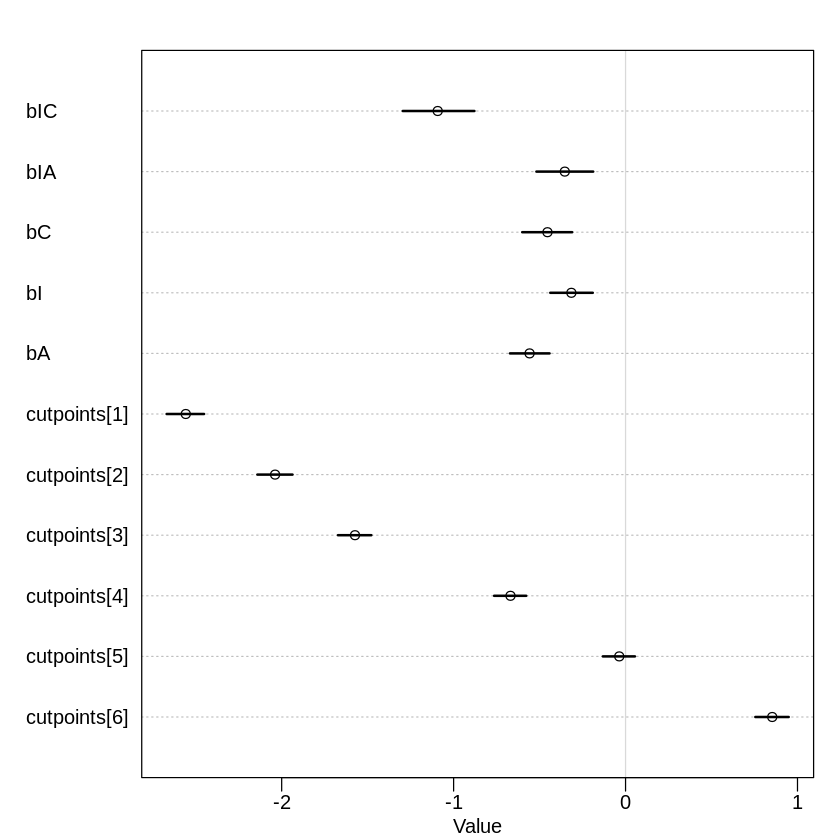

In [22]:
plot(precis(m11H5male, depth=2))

In [18]:
m11H5female <- ulam(
            alist(
                R ~ dordlogit( phi , cutpoints ),
                phi <- bA*A + bC*C + BI*I ,
                BI <- bI + bIA*A + bIC*C ,
                c(bA, bI, bC, bIA, bIC) ~ dnorm( 0 , 0.5 ),
                cutpoints ~ dnorm( 0 , 1.5 )
            ) , data=dat_female , chains=4 , cores=4 )

In [41]:
m11H5femaleQ <- quap(
            alist(
                R ~ dordlogit( phi , c(a1,a2,a3,a4,a5,a6) ),
                phi <- bA*A + bC*C + BI*I ,
                BI <- bI + bIA*A + bIC*C ,
                c(bA, bI, bC, bIA, bIC) ~ dnorm( 0 , 0.5 ),
#                 cutpoints ~ dnorm( 0 , 1.5 )
                c(a1,a2,a3,a4,a5,a6) ~ dnorm( 0 , 1.5 )
            ) , data=dat_female
            , start=list(a1=-2,a2=-1,a3=0,a4=1,a5=2,a6=2.5) 
)

In [23]:
precis(m11H5female, depth=2)

mean       sd         5.5%        94.5%       n_eff    Rhat    
bIC          -1.3995602 0.14074500 -1.62738836 -1.17083596 1382.348 1.003261
bIA          -0.5277646 0.11615779 -0.71200223 -0.33923373 1209.539 1.003129
bC           -0.2210136 0.10040461 -0.38448847 -0.05800762 1409.318 1.005464
bI           -0.2872389 0.08100929 -0.41644969 -0.15789894 1059.560 1.005097
bA           -0.3766739 0.07940170 -0.50610013 -0.25017365 1252.743 1.005665
cutpoints[1] -2.7800074 0.07729501 -2.90232290 -2.65725599 1120.518 1.005789
cutpoints[2] -1.8273715 0.06851257 -1.93476018 -1.71989184 1257.340 1.004867
cutpoints[3] -1.0692369 0.06560917 -1.17653577 -0.96806666 1253.208 1.005547
cutpoints[4]  0.1756006 0.06504658  0.07263408  0.27766835 1196.397 1.006453
cutpoints[5]  0.9788154 0.06789155  0.87196018  1.08479398 1344.601 1.007020
cutpoints[6]  2.0406745 0.07774249  1.91406401  2.16070997 1683.316 1.001850

In [42]:
precis(m11H5femaleQ, depth=2)

mean       sd         5.5%        94.5%      
a1  -2.7761535 0.07986831 -2.90379849 -2.64850851
a2  -1.8263539 0.07087693 -1.93962893 -1.71307886
a3  -1.0695633 0.06681232 -1.17634230 -0.96278431
a4   0.1743342 0.06485277  0.07068697  0.27798146
a5   0.9768604 0.06763667  0.86876390  1.08495682
a6   2.0348932 0.07908995  1.90849216  2.16129419
bA  -0.3770001 0.08055492 -0.50574246 -0.24825781
bI  -0.2860998 0.08479661 -0.42162114 -0.15057841
bC  -0.2219135 0.10164830 -0.38436707 -0.05945984
bIA -0.5271282 0.11780284 -0.71539994 -0.33885655
bIC -1.3967540 0.14367803 -1.62637921 -1.16712873

Quap seems to provide good approximation to ulam, so we can use below in analysis, where we need to call extract.samples with pdat.

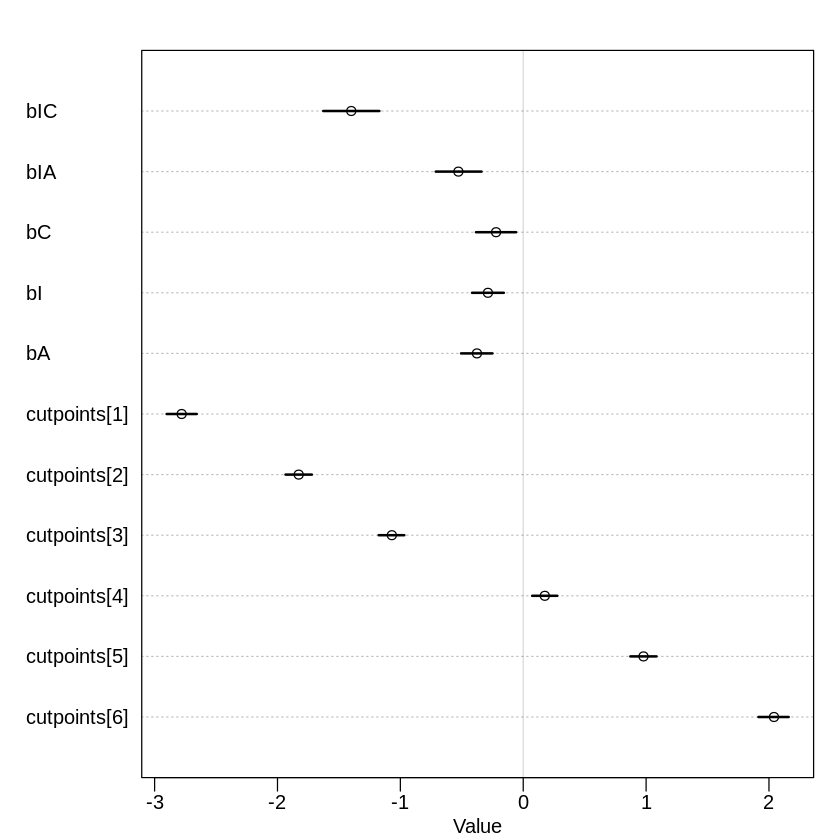

In [24]:
plot(precis(m11H5female, depth=2))

A cursory glance at the estimates for m11H5male and m11H5female is that - ignoring the different cutpoints - the coefficients for females seem to suggest that involving contact leads to less favourable responses from males compared to females (bC is more negative for males than females).  However bIC is more negative for females than males, suggesting that females are more sensitive and likely to disapprove of contact when there is also intention.

Should we consider the cutpoints in this analysis?

What are the cutpoints?  They are the 'average' thresholds that determine the response when the link function is 0, i.e. they determine the log cumulative odds, or the cumulative distribution and hence the probabilities of each response.  If we treat males and females separately, such thresholds will naturally be allowed to differ, however the coefficients bC and bIC for example, indicate how sensitive the cumulative distribution and hence probability densities of each response are to a change in predictor C or I * C.  

If we were to treat the cutpoints altogether for both males and females, what would that do?  The coefficients bC[gid] and bIC[gid] (and the others) would then determine how each gender responds to the change in predictor (C and I * C) from the whole population.  I don't think this is what we want to do, so I expect it is best to keep the cutpoints gender specific, thus we need to use m11H5male and -female models.

We also should calculate the contrast between bC and bIC for males and females.

In [39]:
kA <- 1
# value for action

kC <- 0:1
# value for contact

kI <- 0
# values of intention to calculate over

pdat_I0 <- data.frame(A=kA,C=kC,I=kI)

kA <- 1
# value for action

kC <- 0:1
# value for contact

kI <- 1
# values of intention to calculate over

pdat_I1 <- data.frame(A=kA,C=kC,I=kI)


# post <- link( m12.6q , data=pdat )
# phi <- post$phi

# cutpoints <- coef(m12.6q)[1:6]
# print(cutpoints)

# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
# post_I0 <- extract.samples( m11H5maleQ , data=pdat_I0 )
# post_I1 <- extract.samples( m11H5maleQ , data=pdat_I1 )

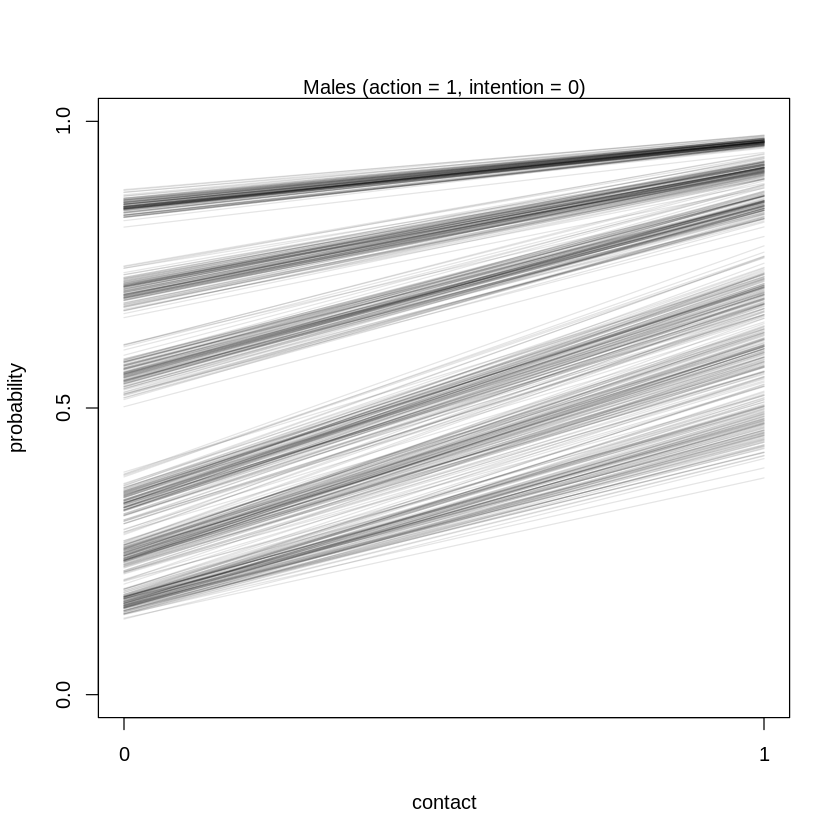

In [53]:
# Use posterior with I = 0 first
pdat <- pdat_I0

# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5maleQ , data=pdat )

A <- pdat['A']
C <- pdat['C']
I <- pdat['I']


phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA*A[i,] + post$bC*C[i,] + post$bI*I[i,] + post$bIA*A[i,] + post$bIC*C[i,]

plot( NULL , type="n" , xlab="contact" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )
mtext("Males (action = 1, intention = 0)")
for ( s in 1:100 ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("black",0.1) )
}

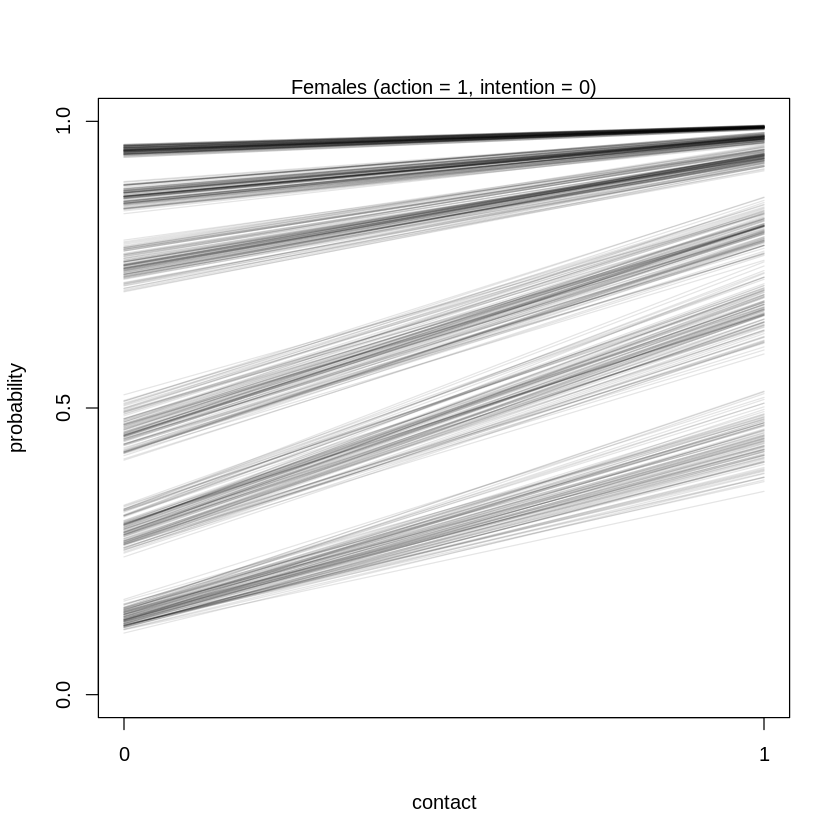

In [56]:
# Use posterior with I = 0 first
pdat <- pdat_I0

# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5femaleQ , data=pdat )

A <- pdat['A']
C <- pdat['C']
I <- pdat['I']


phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA*A[i,] + post$bC*C[i,] + post$bI*I[i,] + post$bIA*A[i,] + post$bIC*C[i,]

plot( NULL , type="n" , xlab="contact" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )
mtext("Females (action = 1, intention = 0)")
for ( s in 1:100 ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("black",0.1) )
}

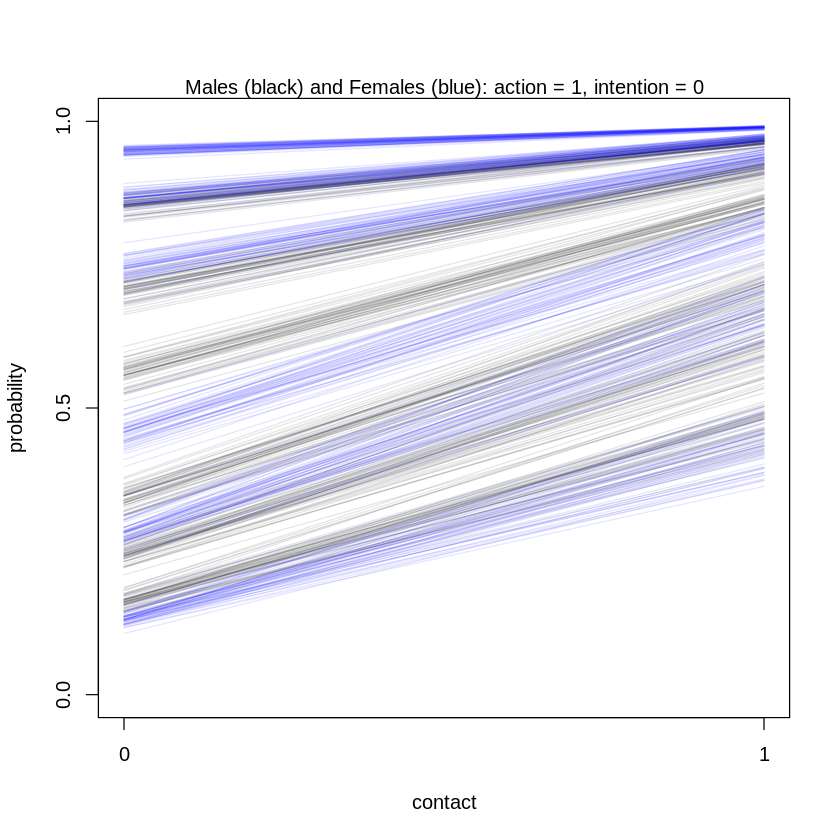

In [88]:
# Use posterior with I = 0 first
pdat <- pdat_I0
A <- pdat['A']
C <- pdat['C']
I <- pdat['I']

num_samples <- 50

#Males
# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5maleQ , data=pdat )


phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA*A[i,] + post$bC*C[i,] + post$bI*I[i,] + post$bIA*A[i,] + post$bIC*C[i,]

plot( NULL , type="n" , xlab="contact" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )
mtext("Males (black) and Females (blue): action = 1, intention = 0")
for ( s in 1:num_samples ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("black",0.1) )
}


#Females
# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5femaleQ , data=pdat )

phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA*A[i,] + post$bC*C[i,] + post$bI*I[i,] + post$bIA*A[i,] + post$bIC*C[i,]

for ( s in 1:num_samples ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("blue",0.1) )
}

For action with no intention:

Without contact, females start out with much more central responses, i.e. with very low prob of response 7 and lower response 1 compared to males.  Males have much greater approval of high numbered responses compared to females.  For example, the combined probability of response 6 or 7 is lower in females than that of 7 in males.  responses 6 +   

However, the gradient of the slopes tends to be steeper in males than females (except perhaps for response 4) suggesting males are more sensitive to contact than females.

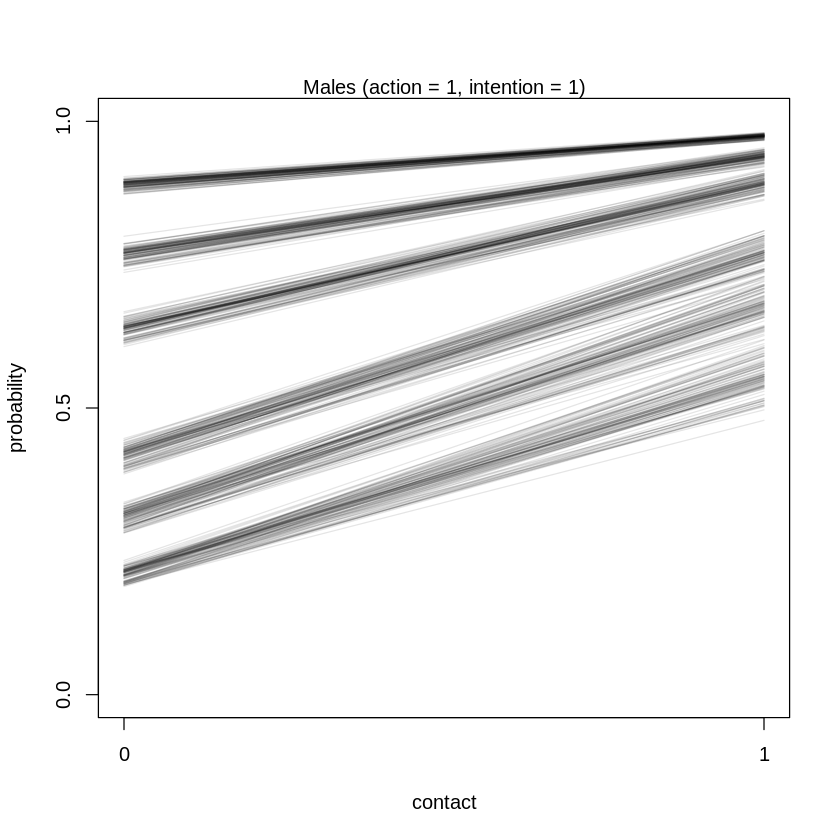

In [76]:
# Use posterior with I = 1 now
pdat <- pdat_I1

# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5maleQ , data=pdat )

A <- pdat['A']
C <- pdat['C']
I <- pdat['I']


phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA*A[i,] + post$bC*C[i,] + post$bI*I[i,] + post$bIA*A[i,] + post$bIC*C[i,]

plot( NULL , type="n" , xlab="contact" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )
mtext("Males (action = 1, intention = 1)")
for ( s in 1:100 ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("black",0.1) )
}

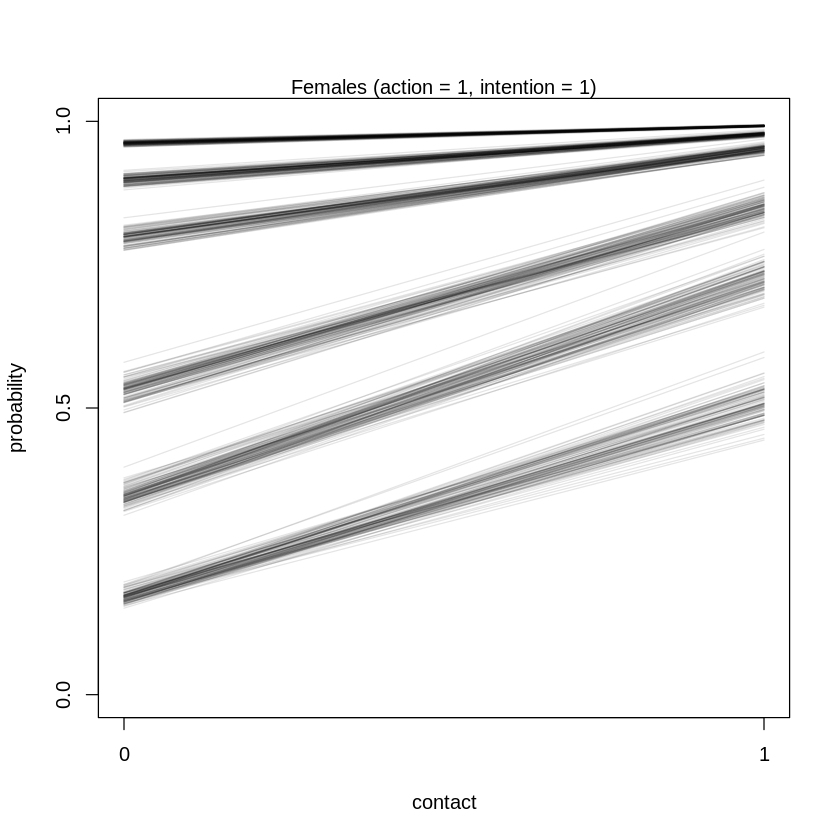

In [58]:
# Use posterior with I = 1 now
pdat <- pdat_I1

# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5femaleQ , data=pdat )

A <- pdat['A']
C <- pdat['C']
I <- pdat['I']


phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA*A[i,] + post$bC*C[i,] + post$bI*I[i,] + post$bIA*A[i,] + post$bIC*C[i,]

plot( NULL , type="n" , xlab="contact" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )
mtext("Females (action = 1, intention = 1)")
for ( s in 1:100 ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("black",0.1) )
}

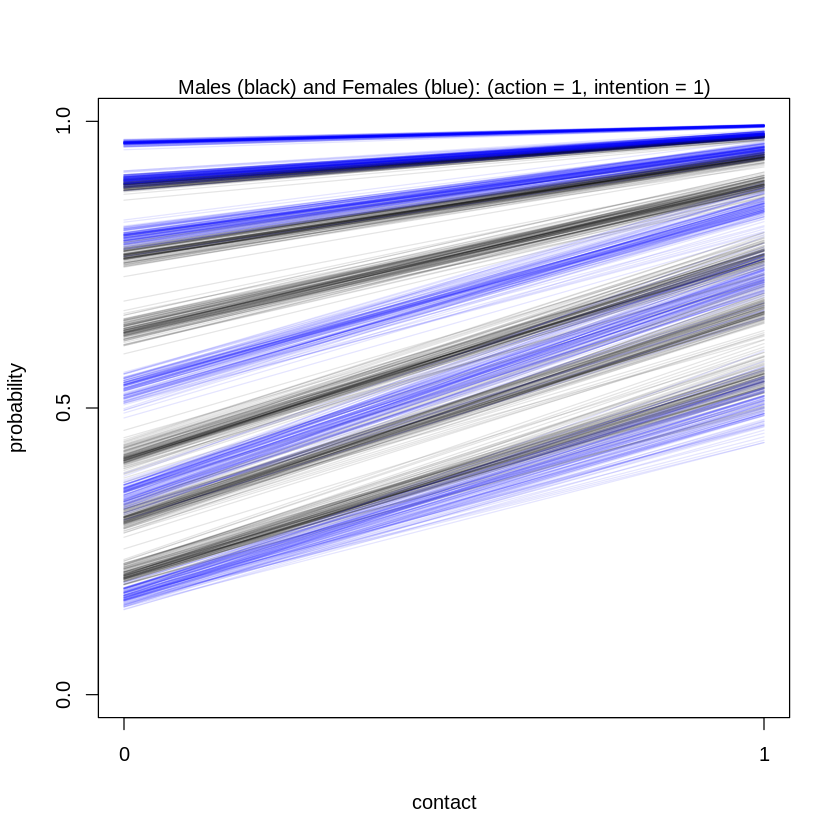

In [86]:
# Use posterior with I = 1 now
pdat <- pdat_I1
A <- pdat['A']
C <- pdat['C']
I <- pdat['I']

num_samples <- 100

#Males
# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5maleQ , data=pdat )

phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA*A[i,] + post$bC*C[i,] + post$bI*I[i,] + post$bIA*A[i,] + post$bIC*C[i,]

plot( NULL , type="n" , xlab="contact" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )
mtext("Males (black) and Females (blue): (action = 1, intention = 1)")
for ( s in 1:num_samples ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("black",0.1) )
}


#Females
# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5femaleQ , data=pdat )

phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA*A[i,] + post$bC*C[i,] + post$bI*I[i,] + post$bIA*A[i,] + post$bIC*C[i,]

for ( s in 1:num_samples ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("blue",0.1) )
}

With both action and intention:

Without contact, again, females are much less likely to choose extreme responses (response 1 or 7).  In fact, females are much less likely to approve, with prob of response 6 or 7 lower than prob of response 7 in males.  

Conversely, females are much more likely to give a lower response (5 or less) than males when either contact or no contact is involved.  In fact, the female prob of responses 5 or lower is greater than the male prob of response 6 or lower for both contact or no contact.

However, in almost all of the lines (about 5 out of 6), the slope between contact and non-contact is greater for males, suggesting that men are, in general, more sensitive to contact than are women.  This contradicts the psychological hypothesis.

How best to compare males and females?  Because the cutpoints are different for male and females, is it fair to compare bC between the two gender specific models?  Or should we compare with the same population wide (not gender specific) cutpoints in the indexed model?

Because the cumulative probablity space is bounded between 0 and 1, this prevents a merely linear model of cutpoints - obviously, that's why we use a cumulative log-odds model.  So comparing bC on a linear scale between the genders may not be fair.  E.g. if we cutpoints of males are for example, on average higher than females, nearer the border of cum prob = 1, then the coefficients bC may not have as much scope to be large?  Is this a fair comment, or is it incorrect, given that we are modelling it linearwise in the logistic space????

Let's just keep things simple and test bC both ways, first by contrasting the gender specific models:

We have already done this, by noting the different coefficients between the gender specific models:

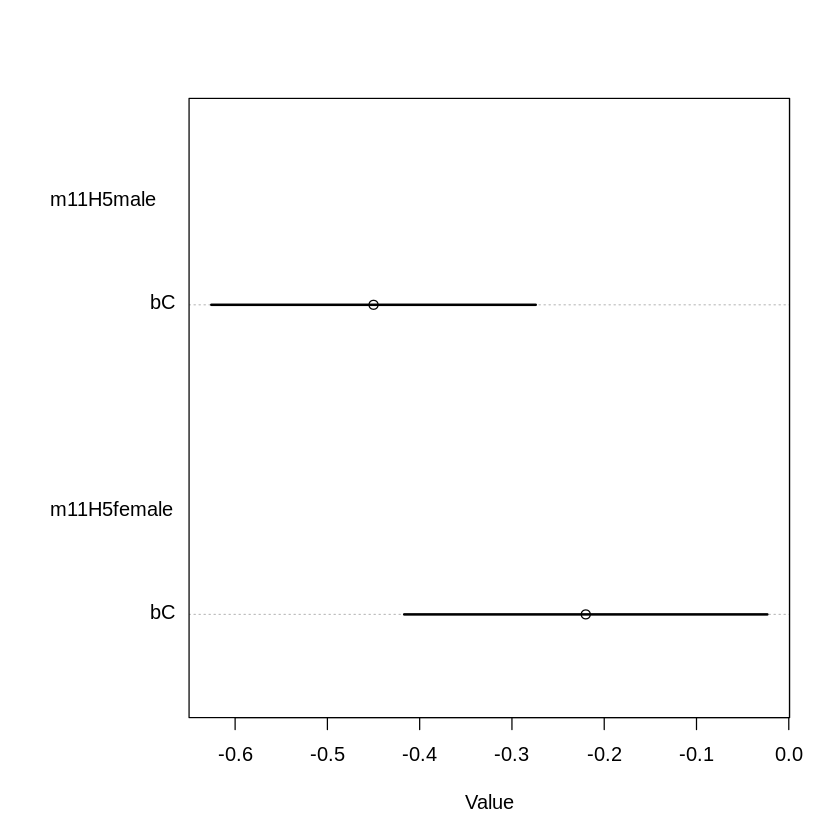

In [66]:
plot(coeftab(m11H5male, m11H5female), pars="bC", labels="bC")

While there is some overlap, this suggests men are less approving of contact than women, contrary to what the psychological claim suggests.  The difference in means is around 0.25.


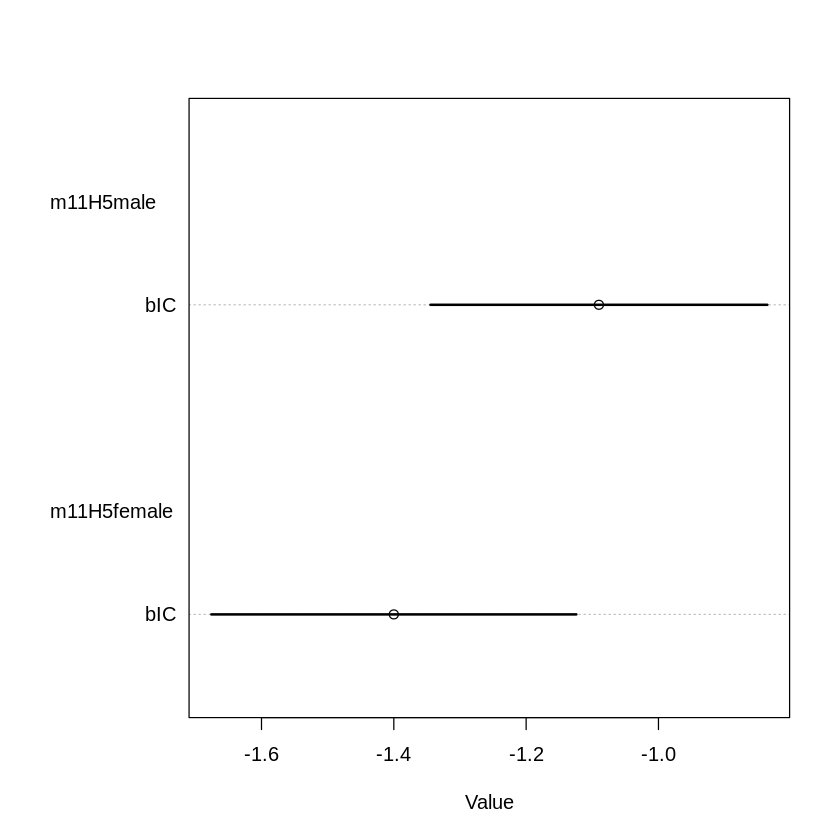

In [68]:
plot(coeftab(m11H5male, m11H5female), pars="bIC", labels="bIC")

In comparison, now females are mode disapproving of intended contact (contact when there is intention) compared to men.  The difference in means is around 0.3.

Let's also make posterior prediction simulations, creating the histograms below:

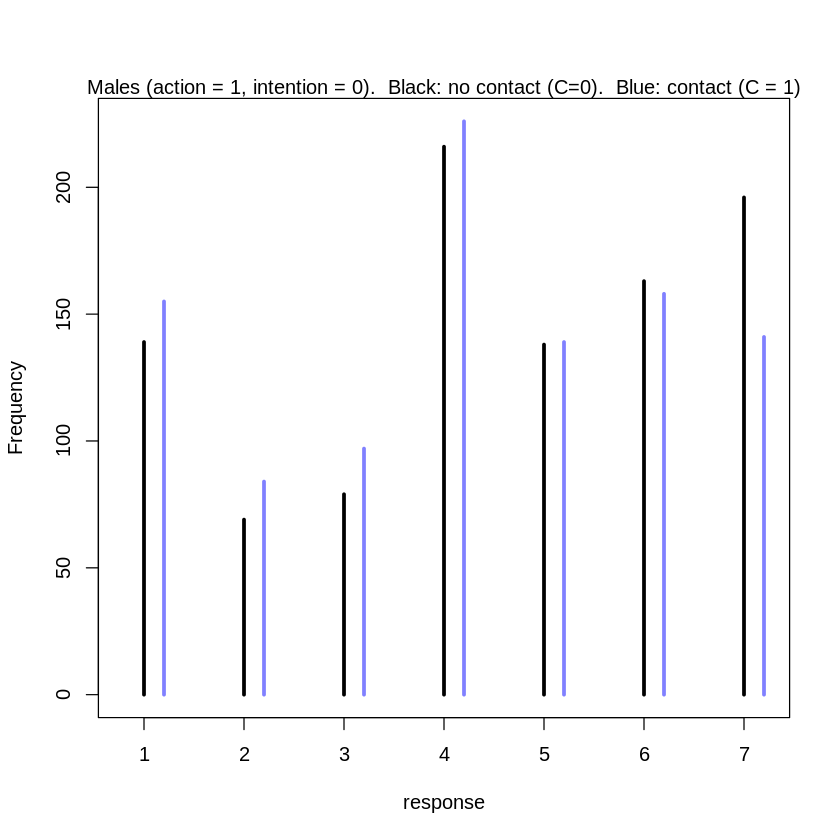

In [71]:
kA <- 1
# value for action
kC <- 0:1
# value for contact
kI <- 0
# values of intention to calculate over
pdat <- data.frame(A=kA,C=kC,I=kI)
s <- sim( m11H5male , data=pdat_I0 )
simplehist( s , xlab="response" )
mtext("Males (action = 1, intention = 0).  Black: no contact (C=0).  Blue: contact (C = 1)")

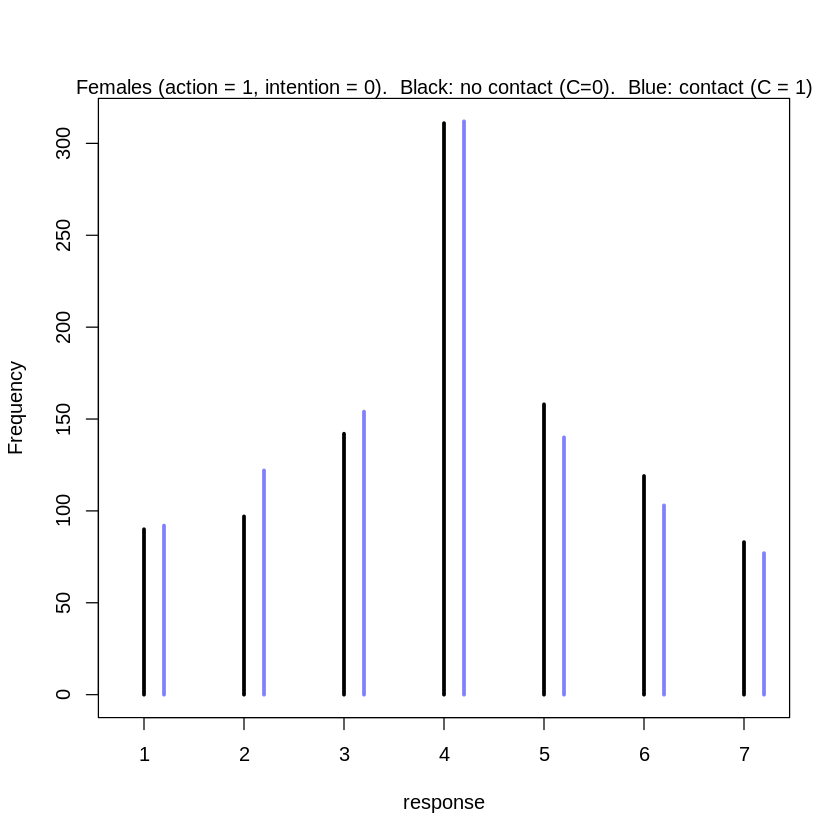

In [75]:
#For Females

kA <- 1
# value for action
kC <- 0:1
# value for contact
kI <- 0
# values of intention to calculate over
pdat <- data.frame(A=kA,C=kC,I=kI)
s <- sim( m11H5female , data=pdat_I0 )
simplehist( s , xlab="response" )
mtext("Females (action = 1, intention = 0).  Black: no contact (C=0).  Blue: contact (C = 1)")

Without intention, both males and females don't change their responses much, except for males the strong approval response of number 7 drops sharply.  No such thing is observed in females, so it appears that females are less sensitive to contact than males when it's done without intention.

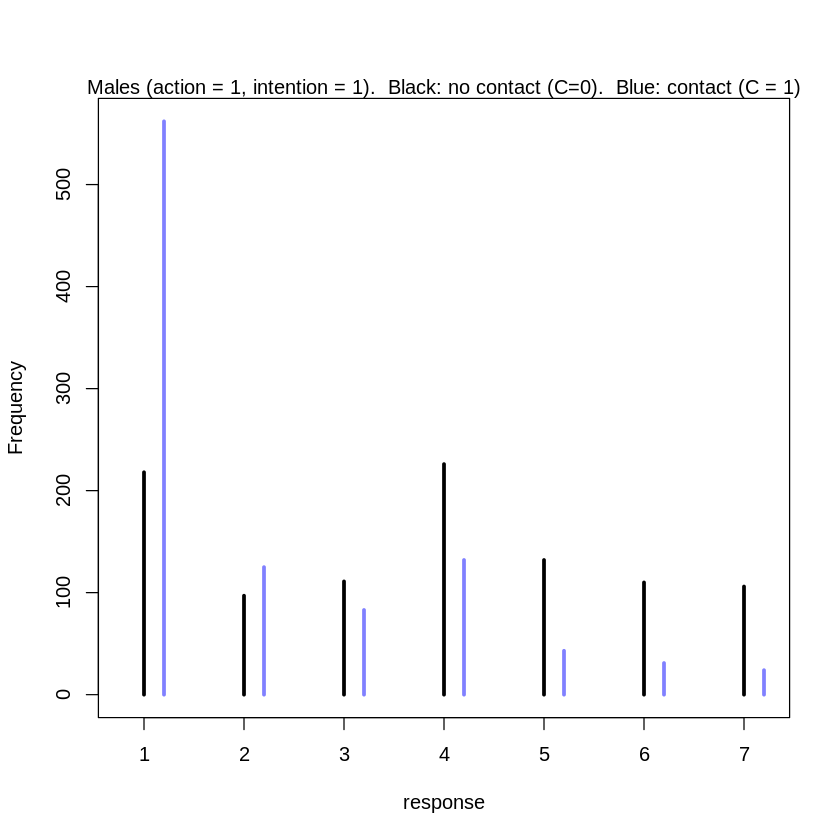

In [72]:
kA <- 1
# value for action
kC <- 0:1
# value for contact
kI <- 1
# values of intention to calculate over
pdat <- data.frame(A=kA,C=kC,I=kI)
s <- sim( m11H5male , data=pdat_I1 )
simplehist( s , xlab="response" )
mtext("Males (action = 1, intention = 1).  Black: no contact (C=0).  Blue: contact (C = 1)")

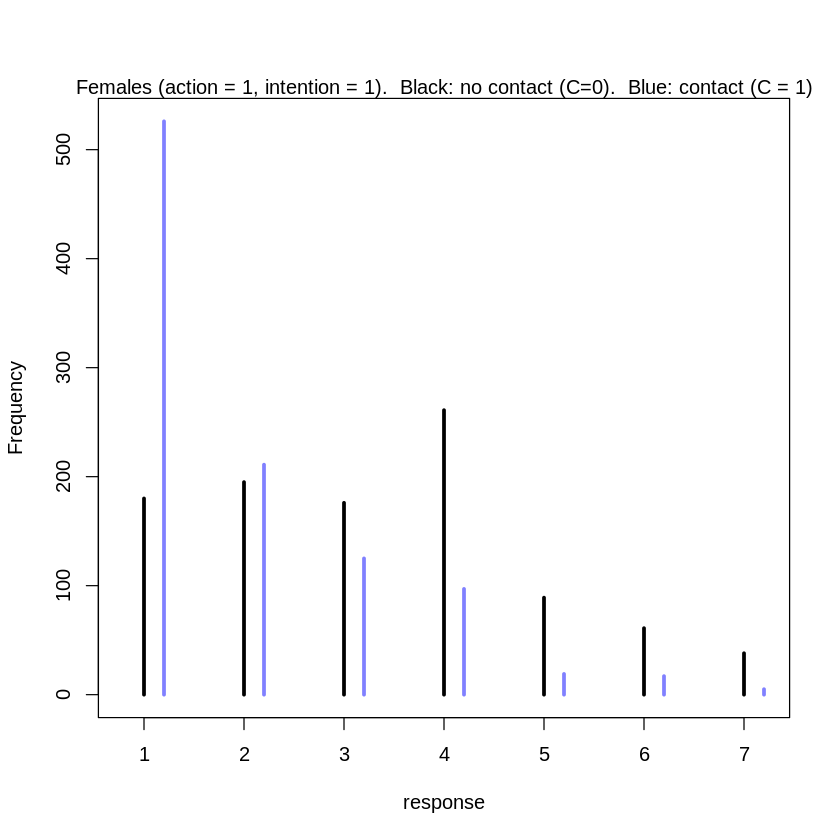

In [74]:
kA <- 1
# value for action
kC <- 0:1
# value for contact
kI <- 1
# values of intention to calculate over
pdat <- data.frame(A=kA,C=kC,I=kI)
s <- sim( m11H5female , data=pdat_I1 )
simplehist( s , xlab="response" )
mtext("Females (action = 1, intention = 1).  Black: no contact (C=0).  Blue: contact (C = 1)")

From the last two graphs, it seems that men generally find it more acceptable than women for action and intention without contact, but with contact shift more to the left of the distribution (i.e. less approval).  Women tend to start out (A=1, I=1, C=0) with lower approval or, at least a lot more ambivalent (number 4) responses, so their shift is less dramatic when contact is made with intention.

All in all, from these gender specific models, it seems that men are more sensitive to contact than women, disproving the psychological hypothesis.

Finally, let's try the model with the combined cutpoints to check what that model says:

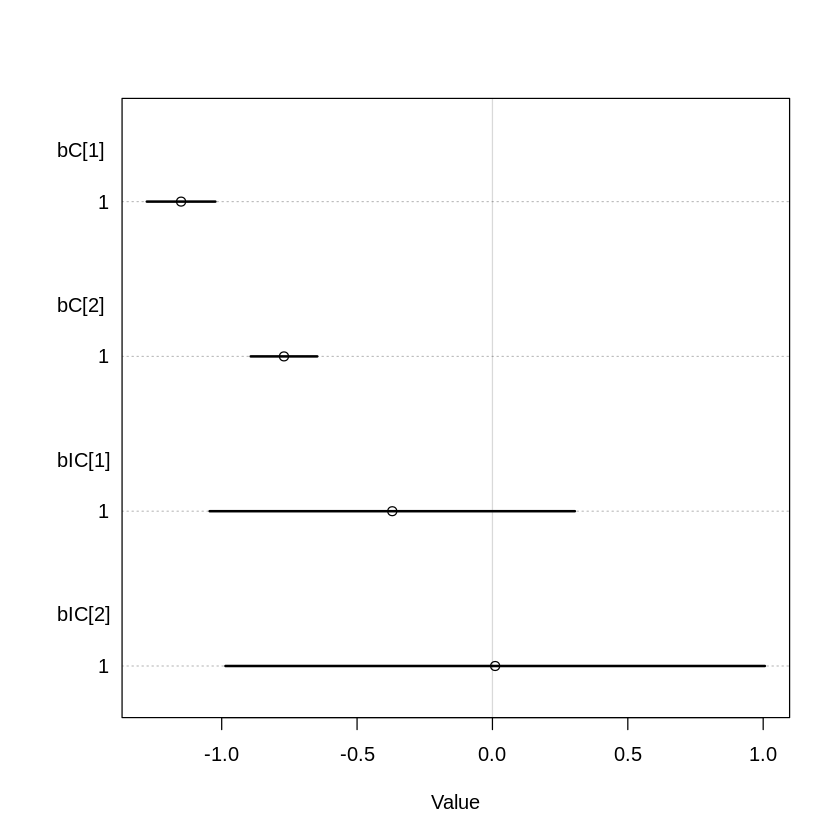

In [99]:
# Note that gender 1 is female, gender 2 is male.
plot(coeftab(m11H5b), pars=c("bC[1]", "bC[2]", "bIC[1]", "bIC[2]"))

In the model with the combined cutpoints, at face value, the bC and even bIC are more negative for females than males.  This implies that females disapporve more than males when non-contact (C=0) changes to contact (C=1), contrary to what we saw with separate cutpoint models.

Just to confirm, let's investigate the contrast between males and females in the combined cutpoints model:

mean       sd         5.5%       94.5%      histogram  
post.diff_fm -0.3848612 0.08096338 -0.5156678 -0.2568351 ▁▁▂▃▇▇▅▃▁▁▁

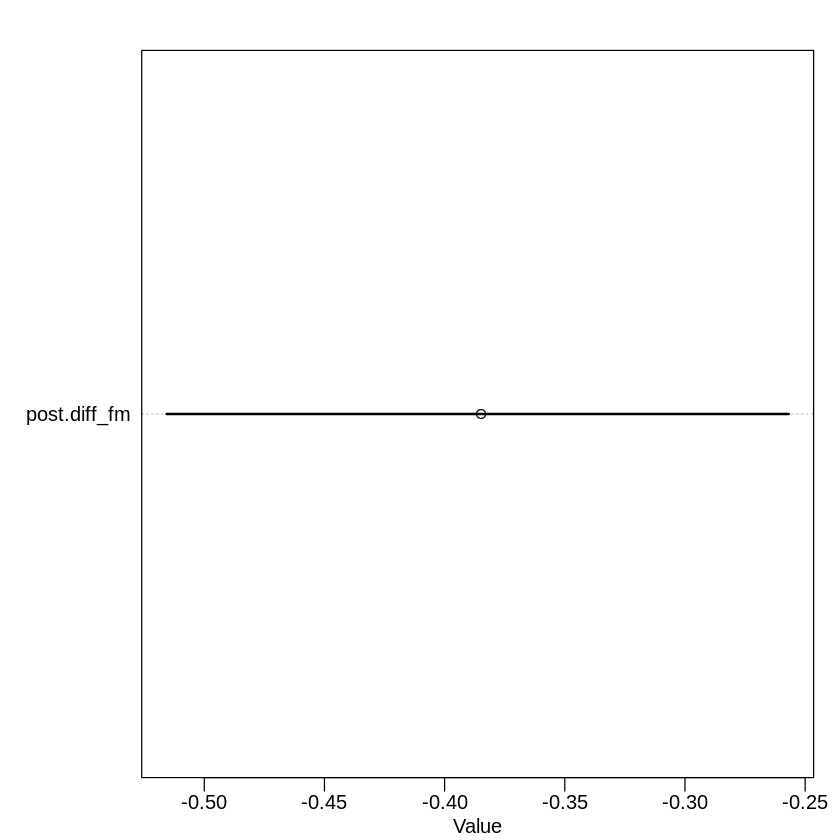

In [105]:
post <- extract.samples(m11H5b)
post$diff_fm <- post$bC[,1] - post$bC[,2]
precis( post$diff_fm )
plot(precis( post$diff_fm ))

This confirms that in the combined cutpoints model, bC is between about 0.52 and 0.25 more negative for females than males.

I would suggest also doing the triptych type figures to investigate more closely.

In [126]:
#Cannot get this to work...

# m11H5bQ <- quap(
#             alist(
#                 R ~ dordlogit( phi , c(a1,a2,a3,a4,a5,a6) ),
#                 phi <- bA[gid]*A + bC[gid]*C + BI[gid]*I ,
#                 BI <- bI[gid] + bIA[gid]*A + bIC[gid]*C ,
#                 c(bA, bI, bC, bIA, bIC) ~ dnorm( 0 , 0.5 ),
# #                 cutpoints ~ dnorm( 0 , 1.5 )
#                 c(a1,a2,a3,a4,a5,a6) ~ dnorm( 0 , 1.5 )
#             ) , data=dat
#             , start=list(a1=-2,a2=-1,a3=0,a4=1,a5=2,a6=2.5) 
# )

ERROR: Error in quap(alist(R ~ dordlogit(phi, c(a1, a2, a3, a4, a5, a6)), phi <- bA[gid] * : Cannot find 'BI'.
If this is a parameter, try defining a prior for it or providing a start value.
If this is a variable, make sure it is in the data list.


In [33]:
# Need to use m11H5 instead as basis of Quap model, even though it has different estimates from m11H5b for some reason.

m11H5q <- quap(
            alist(
                R ~ dordlogit( phi , c(a1,a2,a3,a4,a5,a6) ),
                phi <- bA[gid]*A + bC[gid]*C + bI[gid]*I + bIA[gid]*I*A + bIC[gid]*I*C,
#                 phi <- bA[gid]*A + bC[gid]*C + BI[gid]*I ,
#                 BI <- bI[gid] + bIA[gid]*A + bIC[gid]*C ,
                bA[gid] ~ dnorm( 0 , 0.5 ),
                bI[gid] ~ dnorm( 0 , 0.5 ),
                bC[gid] ~ dnorm( 0 , 0.5 ),
                bIA[gid] ~ dnorm( 0 , 0.5 ),
                bIC[gid] ~ dnorm( 0 , 0.5 ),
#                 c(bA[gid], bI[gid], bC[gid], bIA[gid], bIC[gid]) ~ dnorm( 0 , 0.5 ),
                c(a1,a2,a3,a4,a5,a6) ~ dnorm( 0 , 1.5 )
            ) , data=dat
            , start=list(a1=-2,a2=-1,a3=0,a4=1,a5=2,a6=2.5) 
)

In [35]:
precis(m11H5q, depth=2)

mean         sd         5.5%       94.5%       
a1     -2.655703460 0.05123935 -2.7375938 -2.573813084
a2     -1.961792052 0.04722478 -2.0372664 -1.886317725
a3     -1.363644571 0.04491453 -1.4354267 -1.291862477
a4     -0.314369399 0.04286563 -0.3828770 -0.245861841
a5      0.368355414 0.04310170  0.2994706  0.437240250
a6      1.287460938 0.04603779  1.2138837  1.361038221
bA[1]  -0.753213710 0.06441375 -0.8561593 -0.650268105
bA[2]  -0.245042584 0.06118394 -0.3428263 -0.147258827
bI[1]  -0.667216585 0.06977765 -0.7787347 -0.555698424
bI[2]   0.005621218 0.06626289 -0.1002797  0.111522117
bC[1]  -0.611878823 0.08855165 -0.7534015 -0.470356177
bC[2]  -0.139729985 0.08305576 -0.2724691 -0.006990836
bIA[1] -0.023647742 0.10520259 -0.1917818  0.144486310
bIA[2] -0.763270729 0.09929845 -0.9219688 -0.604572629
bIC[1] -0.764281837 0.13171028 -0.9747803 -0.553783368
bIC[2] -1.598294539 0.12298810 -1.7948533 -1.401735808

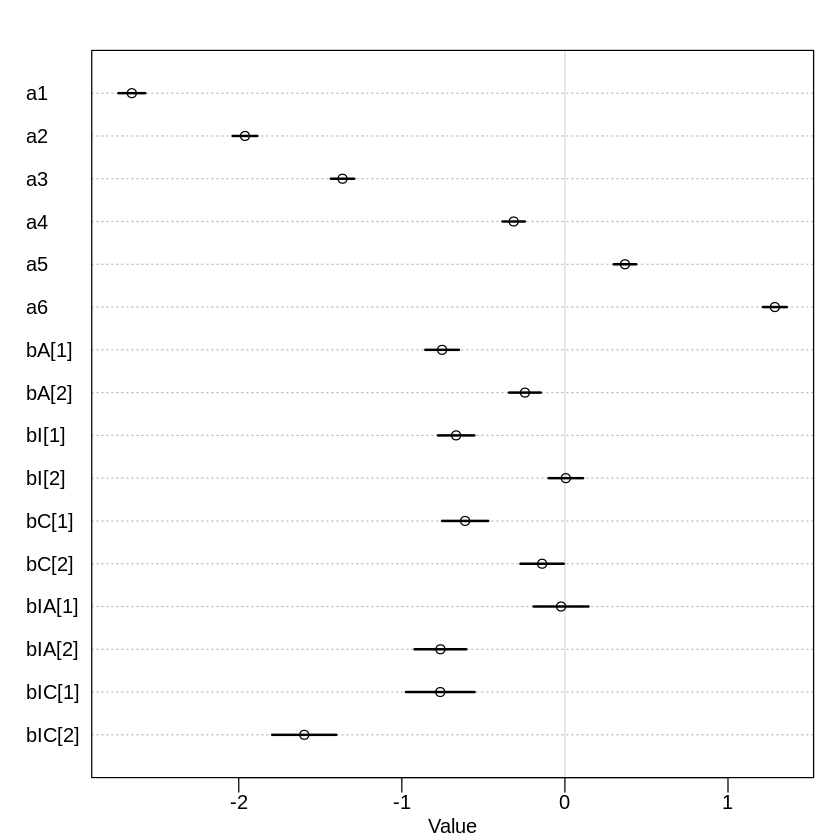

In [36]:
plot(precis(m11H5q, depth=2))

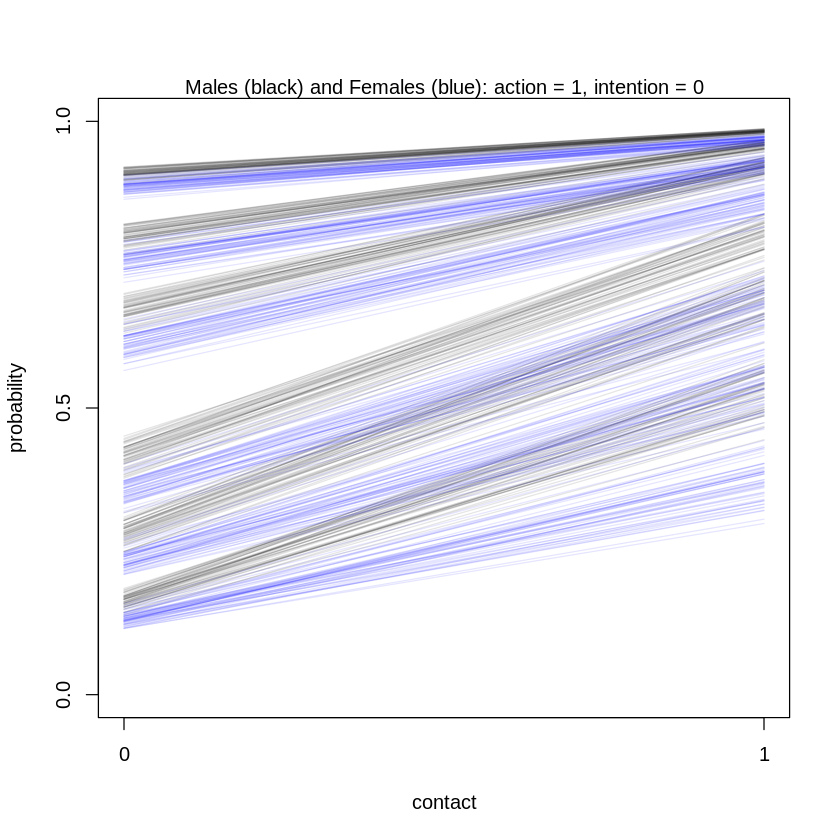

In [40]:
# Use posterior with I = 0 first
pdat <- pdat_I0
A <- pdat['A']
C <- pdat['C']
I <- pdat['I']

num_samples <- 50

# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5q , data=pdat )

#Males
phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA[,2]*A[i,] + post$bC[,2]*C[i,] + post$bI[,2]*I[i,] + post$bIA[,2]*A[i,] + post$bIC[,2]*C[i,]

plot( NULL , type="n" , xlab="contact" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )
mtext("Males (black) and Females (blue): action = 1, intention = 0")
for ( s in 1:num_samples ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("black",0.1) )
}


#Females
phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA[,1]*A[i,] + post$bC[,1]*C[i,] + post$bI[,1]*I[i,] + post$bIA[,1]*A[i,] + post$bIC[,1]*C[i,]

for ( s in 1:num_samples ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("blue",0.1) )
}

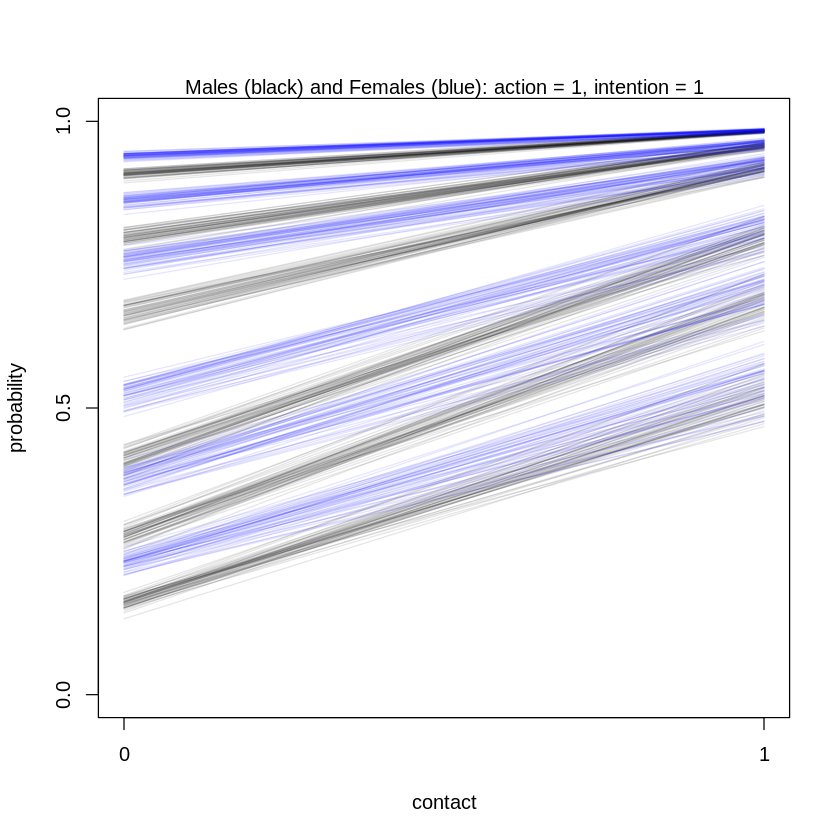

In [41]:
# Use posterior with I = 1 now
pdat <- pdat_I1
A <- pdat['A']
C <- pdat['C']
I <- pdat['I']

num_samples <- 50

# Need to use Quap versions below, because if we use ulam, it throws an error, saying that data is unnecessary argument
post <- extract.samples( m11H5q , data=pdat )

#Males
phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA[,2]*A[i,] + post$bC[,2]*C[i,] + post$bI[,2]*I[i,] + post$bIA[,2]*A[i,] + post$bIC[,2]*C[i,]

plot( NULL , type="n" , xlab="contact" , ylab="probability" ,
xlim=c(0,1) , ylim=c(0,1) , xaxp=c(0,1,1) , yaxp=c(0,1,2) )
mtext("Males (black) and Females (blue): action = 1, intention = 1")
for ( s in 1:num_samples ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("black",0.1) )
}


#Females
phi_hat = matrix(nrow=length(post$bA), ncol=2)
for (i in 1:2) phi_hat[,i] <- post$bA[,1]*A[i,] + post$bC[,1]*C[i,] + post$bI[,1]*I[i,] + post$bIA[,1]*A[i,] + post$bIC[,1]*C[i,]

for ( s in 1:num_samples ) {
    cutpoints <- c(post$a1[s], post$a2[s], post$a3[s], post$a4[s], post$a5[s], post$a6[s] )
    pk <- pordlogit( 1:6 , phi_hat[s,] , cutpoints )
    for ( i in 1:6 ) lines( kC , pk[,i] , col=col.alpha("blue",0.1) )
}

For the shared cutpoints (quap) model, we see similar findings, where the gradient of the lines are flatter for females in both intention=0 and intention=1 cases.  This suggests that males are more sensitive to the addition of contact to the case than are females, suggesting the psychological claim is false.

I expect I have misunderstood the issue about cutpoints in the index model with shared 'base' cutpoints.  The cutpoints are not only affected by the intercept values of a1, a2..., but also the values of the coefficients (bC, bI, etc.) and the predictors (C, I, A), so they should end up with an equivalent set of values, regardless of whether we separate the data first or use indices.

This is easy to understand when we consider the link function, i.e. on page 394.

In [3]:
options(mc.cores = parallel::detectCores())
library(rethinking)
library(gtools)

data(Trolley)
d <- Trolley

d$gender <- ifelse(d$male == 0, 1L, 2L)          #Females are index 1, males are index 2
head(d)

dat <- list(
R = d$response,
A = d$action,
I = d$intention,
C = d$contact,
gid = d$gender)

case  response order id     age male edu           action intention contact
1 cfaqu 4         2    96;434 14  0    Middle School 0      0         1      
2 cfbur 3        31    96;434 14  0    Middle School 0      0         1      
3 cfrub 4        16    96;434 14  0    Middle School 0      0         1      
4 cibox 3        32    96;434 14  0    Middle School 0      1         1      
5 cibur 3         4    96;434 14  0    Middle School 0      1         1      
6 cispe 3         9    96;434 14  0    Middle School 0      1         1      
  story action2 gender
1 aqu   1       1     
2 bur   1       1     
3 rub   1       1     
4 box   1       1     
5 bur   1       1     
6 spe   1       1

I don't know how to solve the issues below, but I think I have answered the question in several ways already, using a joint cutpoint model (m11H5q) and models built using separate gender data.  So you can ignore the following issues, though I leave them here as a reminder of things I didn't know how to fix.  I'm not sure if they are bugs that will be sorted out by McElreath... (though it might be worth asking for an explanation on how to get these things working).

In [38]:
#I think it's worth trying map2stan instead of ulam, because there are issues running extract.samples on ulam (doesn't work).  And it seems I cannot use quap for the combined cutpoints model because of other issues with indexing for gender.  One solution would be to use dummy variables, however, as the 2nd edition of the book warns against that, I will make a last attempt at using map2stan to get a posterior distribution that can be used with artificial data 'pdat' to do the analysis (the triptych figures etc.) analagous to that done above for separate data.

m11H5bM2S <- map2stan(
            alist(
                R ~ dordlogit( phi , cutpoints ),
                phi <- bA[gid]*A + bC[gid]*C + BI[gid]*I ,
                BI <- bI[gid] + bIA[gid]*A + bIC[gid]*C ,
#                 phi <- bA[gid]*A + bC[gid]*C + bI[gid]*I + bIA[gid]*I*A + bIC[gid]*I*C,
                bA[gid] ~ dnorm( 0 , 0.5 ),
                bI[gid] ~ dnorm( 0 , 0.5 ),
                bC[gid] ~ dnorm( 0 , 0.5 ),
                bIA[gid] ~ dnorm( 0 , 0.5 ),
                bIC[gid] ~ dnorm( 0 , 0.5 ),
                vector[6]: cutpoints ~ dnorm( 0 , 1.5 )
            ) , data=dat , chains=1 , cores=1 )

SYNTAX ERROR, MESSAGE(S) FROM PARSER:
Variable "cutpoints" does not exist.
 error in 'model1d2f441cd401_ffc08f16e457bb8b13c562ae4ad99e2d' at line 33, column 51
  -------------------------------------------------
    31:     }
    32:     for ( i in 1:N ) {
    33:         R[i] ~ ordered_logistic( phi[i] , cutpoints );
                                                          ^
    34:     }//i 
  -------------------------------------------------



Error in stanc(file = file, model_code = model_code, model_name = model_name,  : 
  failed to parse Stan model 'ffc08f16e457bb8b13c562ae4ad99e2d' due to the above error.


ERROR: Error in map2stan(alist(R ~ dordlogit(phi, cutpoints), phi <- bA[gid] * : Something went wrong, when calling Stan. Check any debug messages for clues, detective.
failed to parse Stan model 'ffc08f16e457bb8b13c562ae4ad99e2d' due to the above error.


In [6]:
m11H5c <- ulam(
            alist(
                R ~ dordlogit( phi , cutpoints ),
                phi <- bA[gid]*A + bC[gid]*C + BI[gid]*I ,
                BI <- bI[gid] + bIA[gid]*A + bIC[gid]*C ,
#                 phi <- bA[gid]*A + bC[gid]*C + bI[gid]*I + bIA[gid]*I*A + bIC[gid]*I*C,
                bA[gid] ~ dnorm( 0 , 0.5 ),
                bI[gid] ~ dnorm( 0 , 0.5 ),
                bC[gid] ~ dnorm( 0 , 0.5 ),
                bIA[gid] ~ dnorm( 0 , 0.5 ),
                bIC[gid] ~ dnorm( 0 , 0.5 ),
                cutpoints[gid] ~ dnorm( 0 , 1.5 )
            ) , data=dat , chains=1 , cores=1 )



Attaching package: ‘gtools’

The following object is masked from ‘package:rethinking’:

    logit




SAMPLING FOR MODEL '9554b4ce862576362e0013836143cc2c' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: ordered_logistic: Random variable is 4, but must be in the interval [1, 3]  (in 'model1d2f26cf3816_9554b4ce862576362e0013836143cc2c' at line 31)

Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: ordered_logistic: Random variable is 4, but must be in the interval [1, 3]  (in 'model1d2f26cf3816_9554b4ce862576362e0013836143cc2c' at line 31)

Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: ordered_logistic: Random variable is 4, but must be in the interval [1, 3]  (in 'model1d2f26cf3816_9554b4ce862576362e0013836143cc2c' at line 31)

Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Excepti

error occurred during calling the sampler; sampling not done


Stan model '9554b4ce862576362e0013836143cc2c' does not contain samples.


ERROR: Error in validObject(.Object): invalid class “ulam” object: invalid object for slot "coef" in class "ulam": got class "NULL", should be or extend class "numeric"


In [24]:
OK, let's just do the analysis

recompiling to avoid crashing R session



SAMPLING FOR MODEL '9554b4ce862576362e0013836143cc2c' NOW (CHAIN 1).
Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: ordered_logistic: Random variable is 4, but must be in the interval [1, 3]  (in 'model1d2f1dd85be7_9554b4ce862576362e0013836143cc2c' at line 31)

Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: ordered_logistic: Random variable is 4, but must be in the interval [1, 3]  (in 'model1d2f1dd85be7_9554b4ce862576362e0013836143cc2c' at line 31)

Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Exception: ordered_logistic: Random variable is 4, but must be in the interval [1, 3]  (in 'model1d2f1dd85be7_9554b4ce862576362e0013836143cc2c' at line 31)

Chain 1: Rejecting initial value:
Chain 1:   Error evaluating the log probability at the initial value.
Chain 1: Excepti

error occurred during calling the sampler; sampling not done


Stan model '9554b4ce862576362e0013836143cc2c' does not contain samples.


ERROR: Error in validObject(.Object): invalid class “ulam” object: invalid object for slot "coef" in class "ulam": got class "NULL", should be or extend class "numeric"


ERROR: Error in .local(object, ...): unused arguments (data = dat, chains = 1, cores = 1)


11H6

We assume the rate of lambda remains constant per hour of genuine fishing, because we have no data on the ability of the people fishing.  So, after taking into account the offset (the varying amount of time spent in the park), the main reason a non-poisson distribution will depend on the estimated probility that the trip was a fishing trip.  Therefore, we need to work out the predictors that affect the p_zero rate.

The question or data does not describe what other attractions there may be at the national park, other than to fish.  Perhaps there are hiking trails, in which case a group of adults might go on hikes, or do sports such as sailing on the lake.  Without this knowledge we have to make some crude assumptions.

Presence of livebait shows obvious intent to fish.

I don't know whether the presence of camper is conducive to fishing or not.  If there is a camper, I expect hours to be large.  But it may be that people are camping and relaxing, not fishing.  But it may also be that people are camping and fishing.  So I don't think it suggests they are fishing one way or another.

Presence of (children or more than one person) AND no livebait may suggest a social trip, rather than a fishing trip.  We can group children and more than one person together to define a new variable called 'others'.  If there are others and no livebait, this strongly suggests a social trip.  If there is livebait and others, this suggests a mix of social and fishing, perhaps one person fishes while the others are relaxing?  Then there is one person with no children AND livebait.  This is almost definitely a fishing trip.  One person with no livebait, we're not quite sure whether it's fishing or what.  This is interaction effect between children, persons and livebait.


Let's keep things simple and consider the following 3 cases:

Livebait (call this id=3) -> Fishing 

For cases of NO livebait, we split:

* Presence of child (call this id=1) -> Family holiday, so perhaps not fishing (or not concentrating well on the fishing, or inexperienced kids trying to fish keep scaring fish away, or parent distracted by needing to keep kids entertained???). Note, snooping the data, no single person took children.  There were always more than 1 person when children were present.  This means that child > 0 implies person > 1.  

* Lack of child (call this id=2) -> Perhaps fishing.  Does it matter whether there is one person or not?  If there is only one person perhaps they are fishing (assuming there aren't that many other things to do in the national park).  If there are more than one person, could it be a group fishing trip, or could it be a group hiking trip or what?  So let's ignore the number of persons, because a priori I don't think it suggests they are fishing or not fishing.  

In [2]:
data(Fish)
d <- Fish

In [4]:
d$id[(d$livebait==0) & (d$child>0)] <- 1L
d$id[(d$livebait==0) & (d$child==0)] <- 2L
d$id[d$livebait==1] <- 3L
# d[which((d$child==0 & d$person>1) & (1-d$livebait)),]

In [5]:
dat <- list(fish_caught=d$fish_caught, hours=d$hours, id=d$id )

In [7]:
m11H6 <- ulam(
            alist(
                fish_caught ~ dzipois( p_zero, lambda ),             
                log(lambda) <- log(hours) + a,
                logit(p_zero) <- b[id],
                a ~ dnorm(0, 1),     #Lognormal distribution exp(a) has mean exp(mu + sd^2/2), so dnorm(0,1) means exp(a) has mean exp(0.5) ~ 1.6 and standard deviation ~ 2.2.  So one and a half fish every hour would be caught on average.  Is this a reasonable assumption?  Who knows, without looking at the data.  If anything, perhaps we might want a larger sd, though that would also affect the mean?
                b[id] ~ dnorm(0, 1.5)   #This creates a sort of flat prior, as seen in simulations done by McElreath in 2nd ed. Figure 11.3, page 334.
            ), data=dat, chains=4, cores=4
        )

In [9]:
precis(m11H6, depth=2)

mean       sd         5.5%       94.5%       n_eff    Rhat     
a    -0.1453352 0.03458188 -0.2031426 -0.08998668 2452.501 1.0001564
b[1] -0.0368716 0.98875000 -1.5941908  1.47067618 2091.127 0.9989602
b[2]  0.1031660 0.49041610 -0.6920149  0.91698238 3161.332 0.9991908
b[3] -0.8963831 0.20416574 -1.2259903 -0.58177764 2492.500 1.0000171

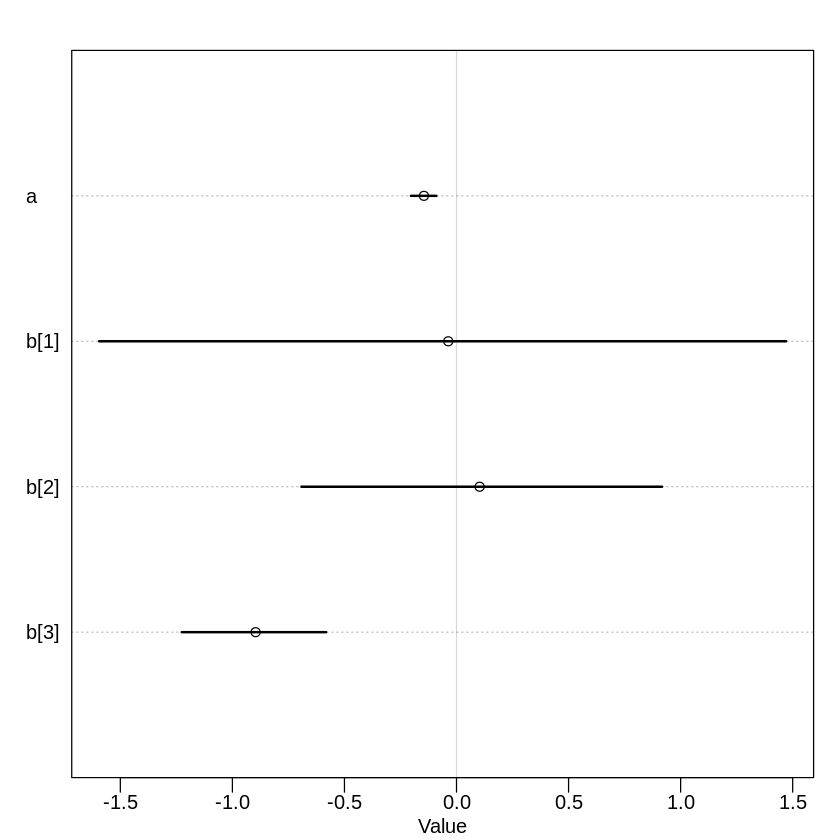

In [11]:
plot(precis(m11H6, depth=2))

In [29]:
post <- extract.samples(m11H6)

lambda <- exp(post$a)

p1 <- inv_logit(post$b[,1])
p2 <- inv_logit(post$b[,2])
p3 <- inv_logit(post$b[,3])

diff_p12 <- inv_logit(post$b[,1]) - inv_logit(post$b[,2])
diff_p13 <- inv_logit(post$b[,1]) - inv_logit(post$b[,3])
diff_p23 <- inv_logit(post$b[,2]) - inv_logit(post$b[,3])

precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) )

mean        sd         5.5%        94.5%     histogram     
lambda    0.86524889 0.02988878  0.81616183 0.9139434 ▁▁▂▃▇▇▅▂▁▁▁   
p1        0.49451824 0.20433802  0.16879511 0.8131601 ▁▃▅▇▇▇▇▅▂▁    
p2        0.52437200 0.11571698  0.33358500 0.7144268 ▁▁▁▂▃▅▇▇▇▅▃▂▁▁
p3        0.29158059 0.04159793  0.22688399 0.3585237 ▁▁▂▇▅▁▁       
diff_p12 -0.02985376 0.23019582 -0.39634898 0.3376675 ▁▁▁▂▃▅▇▇▇▇▃▂▁▁
diff_p13  0.20293765 0.20938801 -0.13398506 0.5358271 ▁▁▂▅▇▇▇▇▅▂▁   
diff_p23  0.23279141 0.12227521  0.02911856 0.4291479 ▁▁▂▅▇▃▂▁▁

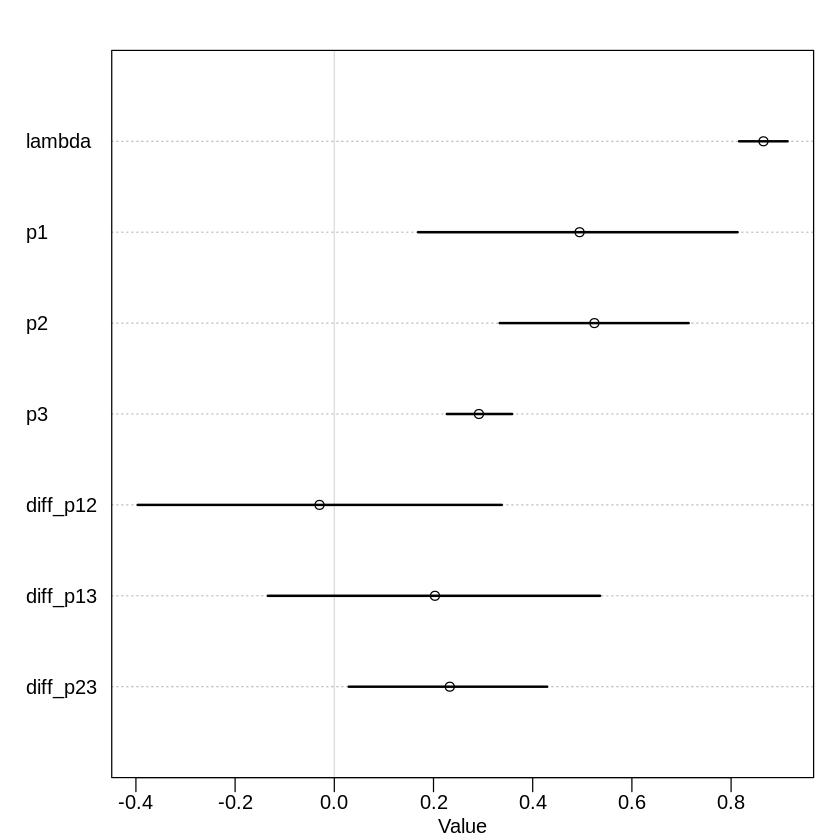

In [30]:
plot(precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) ))

The estimated range of possible lambda values is quite tight around about 0.82 to 0.91, so expected catch of fish per hour for people who are fishing in the park is 0.87.

The p's are the estimated probabilities of not fishing for each id.  The diff_p12 refers to the estimated difference in probability of not fishing between id 1 and id 2, with prob of id 2 subtracted from prob of id 1, so positive values would mean id 1 had estimated probability of not fishing higher than id 2.

So, in line with our predictions, id=1 (no livebait AND presence of child) has the highest estimated probability of not fishing with a range between around 0.2 up to 0.8 (it is very uncertain, clearly there are sometimes that people take their kids fishing).  

It seems that there is not much difference in mean estimated probability of not fishing between id=1 and id=2 (no livebait AND no child).  So it seems child is not a good predictor for p_zero (after conditioning for lack of livebait).

As expected though, id=3 has a lot smaller estimated probability of not fishing, with id=2 clearly having a greater estimated probability of not fishing compared to id=3.

Let's try presence of other adults, or even presence of other people (persons + child) as predictors, given no livebait.

We define id=1 as those in a group without livebait, id=2 as lone people without livebait, and id=3 remains as those with livebait.

In [19]:
#efine 'others' as presence of children (child=1) or others (persons>1).
d$others <- ((d$child>0) | (d$persons>1))

d$id2[(d$livebait==0) & d$others] <- 1L               #Group without livebait
d$id2[(d$livebait==0) & !d$others] <- 2L              #Lone person without livebait
d$id2[d$livebait==1] <- 3L

In [22]:
head(d)

fish_caught livebait camper persons child hours  id others id2
1 0           0        0      1       0     21.124 2  FALSE  2  
2 0           1        1      1       0      5.732 3  FALSE  3  
3 0           1        0      1       0      1.323 3  FALSE  3  
4 0           1        1      2       1      0.548 3   TRUE  3  
5 1           1        0      1       0      1.695 3  FALSE  3  
6 0           1        1      4       2      0.493 3   TRUE  3

In [23]:
dat2 <- list(fish_caught=d$fish_caught, hours=d$hours, id=d$id2 )

In [24]:
m11H6b <- ulam(
            alist(
                fish_caught ~ dzipois( p_zero, lambda ),             
                log(lambda) <- log(hours) + a,
                logit(p_zero) <- b[id],
                a ~ dnorm(0, 1),     #Lognormal distribution exp(a) has mean exp(mu + sd^2/2), so dnorm(0,1) means exp(a) has mean exp(0.5) ~ 1.6 and standard deviation ~ 2.2.  So one and a half fish every hour would be caught on average.  Is this a reasonable assumption?  Who knows, without looking at the data.  If anything, perhaps we might want a larger sd, though that would also affect the mean?
                b[id] ~ dnorm(0, 1.5)   #This creates a sort of flat prior, as seen in simulations done by McElreath in 2nd ed. Figure 11.3, page 334.
            ), data=dat2, chains=4, cores=4
        )

recompiling to avoid crashing R session


In [25]:
precis(m11H6b, depth=2)

mean       sd         5.5%       94.5%       n_eff    Rhat     
a    -0.1456893 0.03631037 -0.2024532 -0.08784257 2566.570 1.0001530
b[1] -0.3086613 0.52846549 -1.1965096  0.53452578 2926.208 0.9999052
b[2]  1.0609791 0.83531439 -0.1936786  2.44639692 2832.748 0.9986758
b[3] -0.8907975 0.20947815 -1.2255446 -0.56848945 2303.982 0.9986498

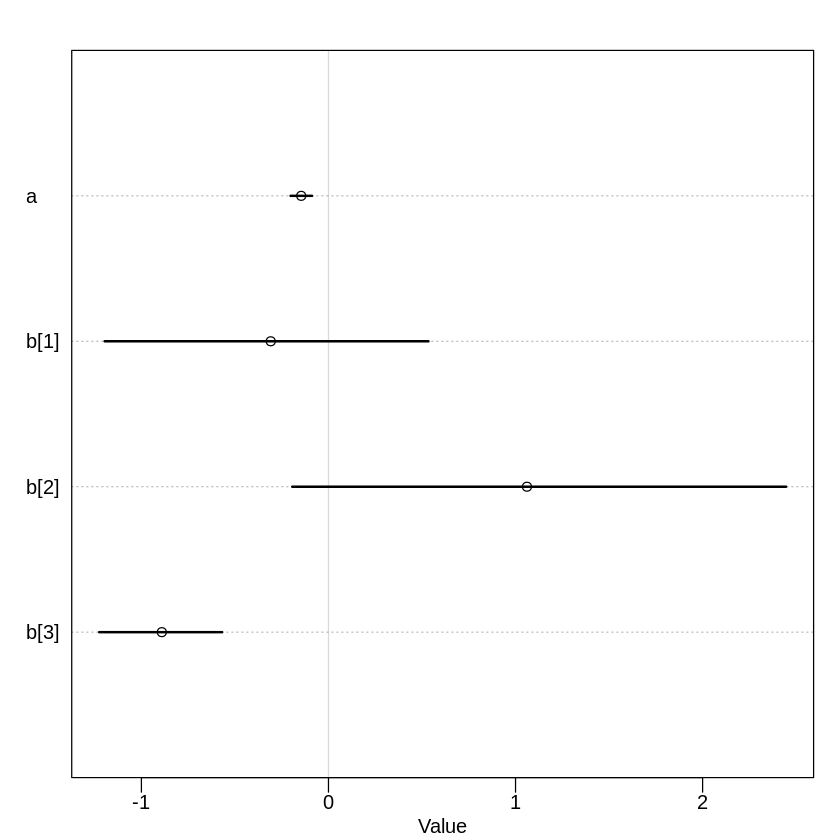

In [26]:
plot(precis(m11H6b, depth=2))

In [32]:
post <- extract.samples(m11H6b)

lambda <- exp(post$a)

p1 <- inv_logit(post$b[,1])
p2 <- inv_logit(post$b[,2])
p3 <- inv_logit(post$b[,3])

diff_p12 <- inv_logit(post$b[,1]) - inv_logit(post$b[,2])
diff_p13 <- inv_logit(post$b[,1]) - inv_logit(post$b[,3])
diff_p23 <- inv_logit(post$b[,2]) - inv_logit(post$b[,3])

precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) )

mean       sd         5.5%        94.5%      histogram      
lambda    0.8649960 0.03141631  0.81672470 0.91590505 ▁▁▁▂▅▇▇▅▃▁▁▁▁  
p1        0.4284567 0.12103746  0.23209672 0.63053806 ▁▁▁▂▃▅▇▇▇▅▃▂▁▁▁
p2        0.7162191 0.15041680  0.45173114 0.92029756 ▁▁▁▂▃▇▇▇▂      
p3        0.2928182 0.04276845  0.22696218 0.36158545 ▁▂▇▇▂▁▁        
diff_p12 -0.2877624 0.19291987 -0.57515442 0.03106077 ▁▁▃▇▇▇▅▃▁▁▁▁   
diff_p13  0.1356384 0.13036419 -0.07109233 0.34827611 ▁▁▃▇▇▅▂▁▁      
diff_p23  0.4234009 0.15470605  0.14292481 0.64093325 ▁▁▁▂▃▅▇▇▂▁▁

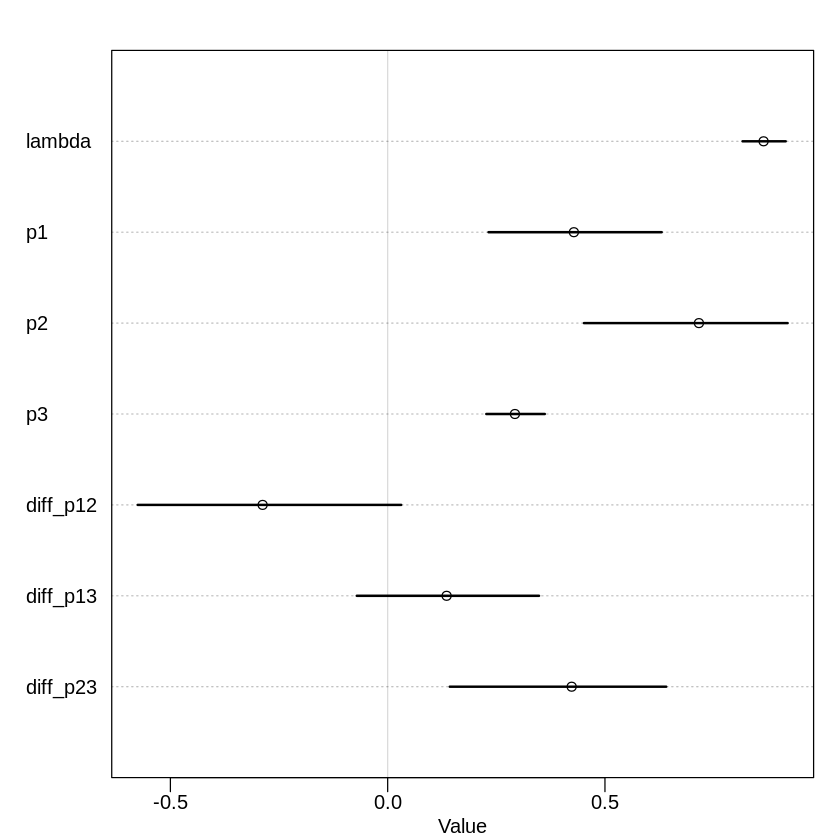

In [34]:
plot(precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) ))

This has not affected the estimated value of lambda, which remains at 0.87 fish per hour.

Here, lone people without livebait are estimated as having a very high probability of not fishing, whereas those in groups without livebait are around 50%.  Interesting, as I thought that those in a group may be families who might not be fishing.  Again, those with livebait are much more likely to be fishing.

Interestingly, whereas beforehand there was not much difference in probabilities of fishing using child as predictor, the presence of other people (children or adults) are a much stronger predictor of fishing.

Let's take a look at using presence of other adults, i.e. persons > 1, ignoring children.  We could even check for persons > 2, to try to filter out a romantic trip?

In [37]:
d$id3[(d$livebait==0) & (d$persons>1)] <- 1L               #Group without livebait
d$id3[(d$livebait==0) & (d$persons==1)] <- 2L              #Lone person without livebait
d$id3[d$livebait==1] <- 3L
head(d)

fish_caught livebait camper persons child hours  id others id2 id3
1 0           0        0      1       0     21.124 2  FALSE  2   2  
2 0           1        1      1       0      5.732 3  FALSE  3   3  
3 0           1        0      1       0      1.323 3  FALSE  3   3  
4 0           1        1      2       1      0.548 3   TRUE  3   3  
5 1           1        0      1       0      1.695 3  FALSE  3   3  
6 0           1        1      4       2      0.493 3   TRUE  3   3

In [38]:
dat3 <- list(fish_caught=d$fish_caught, hours=d$hours, id=d$id3 )

In [40]:
m11H6c <- ulam(
            alist(
                fish_caught ~ dzipois( p_zero, lambda ),             
                log(lambda) <- log(hours) + a,
                logit(p_zero) <- b[id],
                a ~ dnorm(0, 1),     #Lognormal distribution exp(a) has mean exp(mu + sd^2/2), so dnorm(0,1) means exp(a) has mean exp(0.5) ~ 1.6 and standard deviation ~ 2.2.  So one and a half fish every hour would be caught on average.  Is this a reasonable assumption?  Who knows, without looking at the data.  If anything, perhaps we might want a larger sd, though that would also affect the mean?
                b[id] ~ dnorm(0, 1.5)   #This creates a sort of flat prior, as seen in simulations done by McElreath in 2nd ed. Figure 11.3, page 334.
            ), data=dat3, chains=4, cores=4
        )

recompiling to avoid crashing R session


In [41]:
precis(m11H6c, depth=2)

mean       sd        5.5%       94.5%       n_eff    Rhat     
a    -0.1447172 0.0370932 -0.2026461 -0.08631448 2092.499 1.0010800
b[1] -0.3184928 0.5181542 -1.1722564  0.46044834 2917.235 0.9986682
b[2]  1.0999158 0.8825278 -0.2557338  2.57095753 2729.016 0.9987377
b[3] -0.8858652 0.1994217 -1.2068779 -0.57239836 2518.605 0.9988694

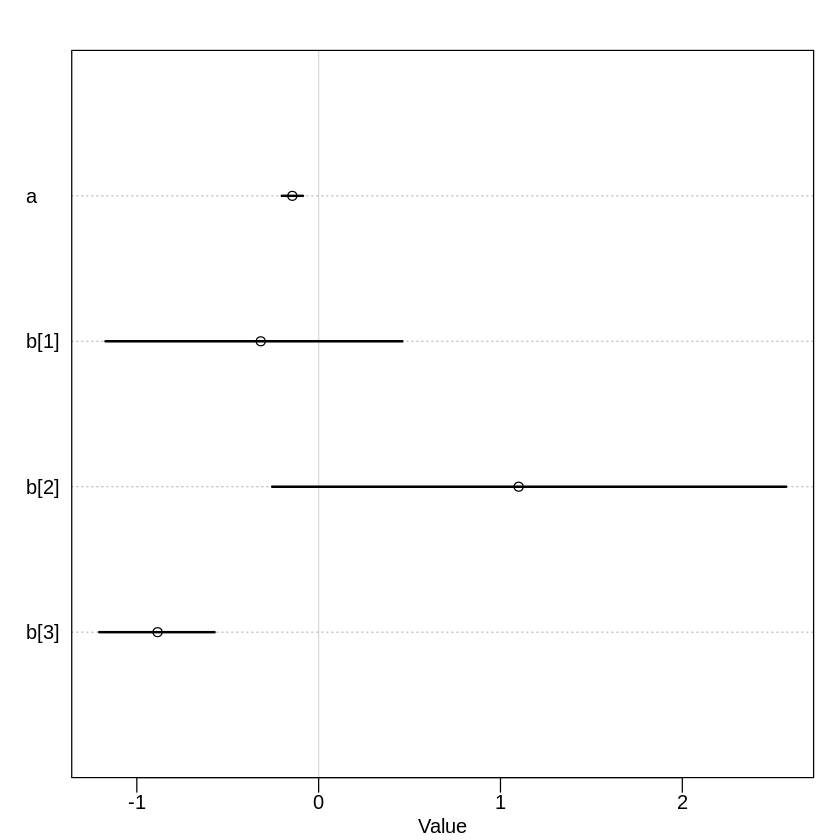

In [42]:
plot(precis(m11H6c, depth=2))

In [43]:
post <- extract.samples(m11H6c)

lambda <- exp(post$a)

p1 <- inv_logit(post$b[,1])
p2 <- inv_logit(post$b[,2])
p3 <- inv_logit(post$b[,3])

diff_p12 <- inv_logit(post$b[,1]) - inv_logit(post$b[,2])
diff_p13 <- inv_logit(post$b[,1]) - inv_logit(post$b[,3])
diff_p23 <- inv_logit(post$b[,2]) - inv_logit(post$b[,3])

precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) )

mean       sd         5.5%        94.5%      histogram    
lambda    0.8658621 0.03212437  0.81656721 0.91730572 ▁▁▂▃▇▇▅▂▁▁▁  
p1        0.4261809 0.11827750  0.23644738 0.61312053 ▁▁▂▇▇▅▂▁     
p2        0.7201696 0.15662859  0.43641272 0.92896888 ▁▁▁▂▃▅▇▇▃    
p3        0.2936515 0.04100175  0.23025395 0.36068360 ▁▁▂▇▇▁▁▁     
diff_p12 -0.2939887 0.19412923 -0.58659234 0.04811457 ▁▁▁▃▅▇▇▃▂▂▁▁▁
diff_p13  0.1325294 0.12480076 -0.06650724 0.33432334 ▁▁▃▇▇▅▂▁▁    
diff_p23  0.4265181 0.15830317  0.13676385 0.64001677 ▁▁▁▂▃▅▇▇▃▁

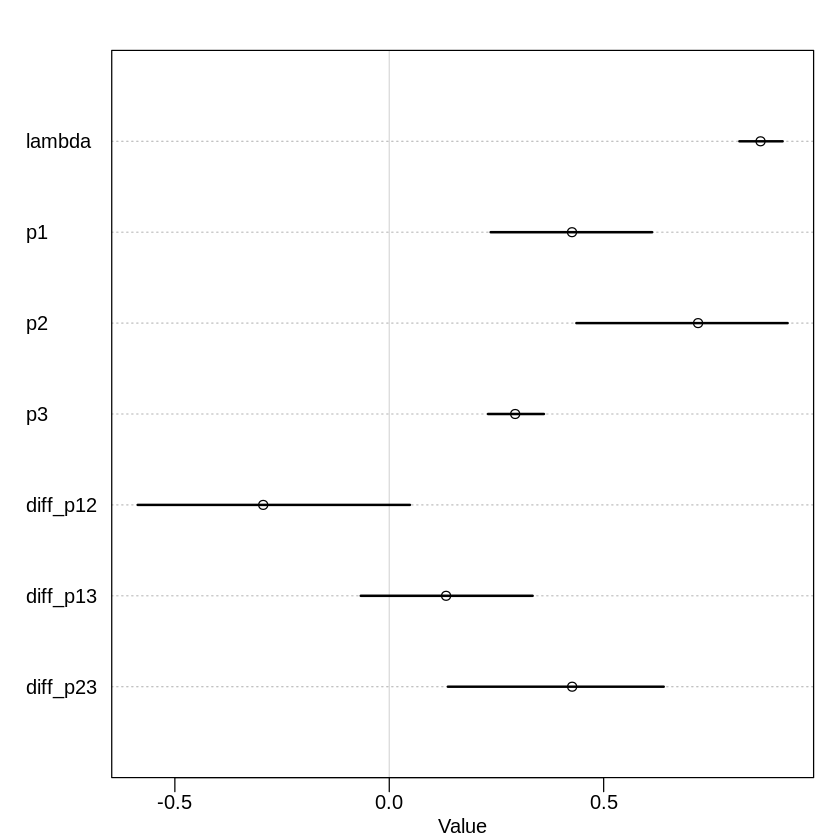

In [44]:
plot(precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) ))

The results appear quite similar to m11H6b, so the presence of persons>1 appears to drive the difference in b.  This should not be that surprising, seeing as the children were not a good predictor in the first model, m11H6.

Now let's treat those on their own and those with one partner as the same, i.e. a group of 3 or more is different.  The idea being that we know people on their own don't seem to fish (estimated probability around 0.43 to 0.93 in model c.  What about people in couples also not likely to fish, if we think that a lot of them could be either parents on a family holiday, or a couple on a romantic camping trip?

In [47]:
d$id4[(d$livebait==0) & (d$persons>2)] <- 1L               #Group without livebait
d$id4[(d$livebait==0) & (d$persons<=2)] <- 2L              #Lone person or couple without livebait
d$id4[d$livebait==1] <- 3L

In [48]:
dat4 <- list(fish_caught=d$fish_caught, hours=d$hours, id=d$id4 )

In [49]:
m11H6d <- ulam(
            alist(
                fish_caught ~ dzipois( p_zero, lambda ),             
                log(lambda) <- log(hours) + a,
                logit(p_zero) <- b[id],
                a ~ dnorm(0, 1),     #Lognormal distribution exp(a) has mean exp(mu + sd^2/2), so dnorm(0,1) means exp(a) has mean exp(0.5) ~ 1.6 and standard deviation ~ 2.2.  So one and a half fish every hour would be caught on average.  Is this a reasonable assumption?  Who knows, without looking at the data.  If anything, perhaps we might want a larger sd, though that would also affect the mean?
                b[id] ~ dnorm(0, 1.5)   #This creates a sort of flat prior, as seen in simulations done by McElreath in 2nd ed. Figure 11.3, page 334.
            ), data=dat4, chains=4, cores=4
        )

recompiling to avoid crashing R session


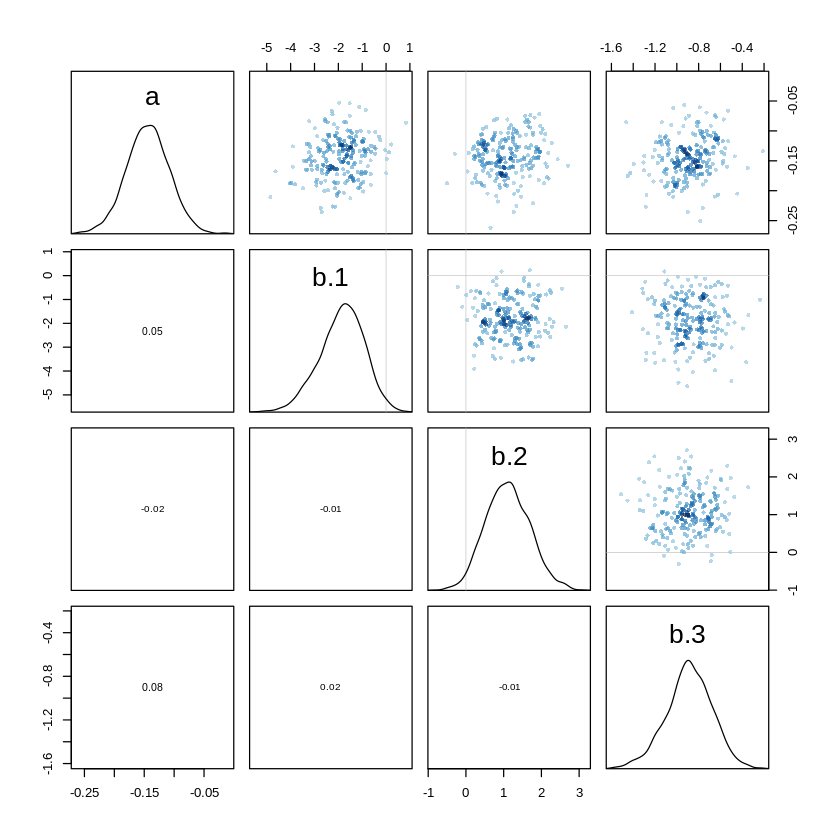

In [53]:
pairs(m11H6d)

In [50]:
post <- extract.samples(m11H6d)

lambda <- exp(post$a)

p1 <- inv_logit(post$b[,1])
p2 <- inv_logit(post$b[,2])
p3 <- inv_logit(post$b[,3])

diff_p12 <- inv_logit(post$b[,1]) - inv_logit(post$b[,2])
diff_p13 <- inv_logit(post$b[,1]) - inv_logit(post$b[,3])
diff_p23 <- inv_logit(post$b[,2]) - inv_logit(post$b[,3])

precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) )

mean       sd         5.5%        94.5%       histogram      
lambda    0.8663791 0.03095412  0.81767737  0.91673848 ▁▁▁▃▇▇▅▂▁▁▁▁   
p1        0.1685925 0.11569203  0.02999825  0.38323320 ▅▇▇▅▃▂▂▁▁▁▁▁▁▁ 
p2        0.7371094 0.10640440  0.55384774  0.88545681 ▁▁▁▁▁▁▂▃▅▇▇▇▃▁▁
p3        0.2935097 0.04303228  0.22601713  0.36168247 ▁▁▁▂▃▇▇▇▅▂▁▁▁▁▁
diff_p12 -0.5685169 0.15870203 -0.79399320 -0.27449143 ▁▁▅▇▇▃▂▁▁▁▁    
diff_p13 -0.1249172 0.12275789 -0.28325658  0.09223792 ▁▁▅▇▃▂▁▁▁▁     
diff_p23  0.4435997 0.11496486  0.24598137  0.60909003 ▁▁▁▂▅▇▇▂▁

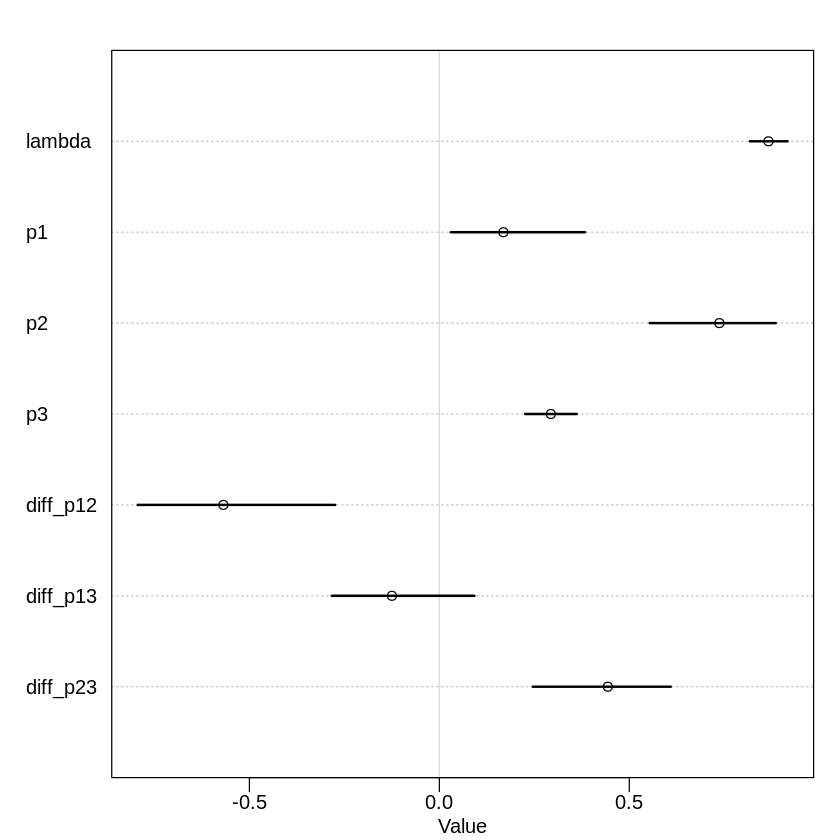

In [51]:
plot(precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) ))

Now there is a much clearer difference between the ids.  In fact, although uncertain, there probability of those in id=1 (people in groups more than 2 adults without livebait) tend to have a greater estimated probability of fishing that those with livebait!  And those in couples or on their own without livebait have a distinctly higher probability of not fishing.

Finally, let's see whether the presence of a camper does anything, just out of interest....

In [55]:
d$id5[(d$livebait==0) & (d$camper==0)] <- 1L               #No camper, no livebait
d$id5[(d$livebait==0) & (d$camper==1)] <- 2L              #Camper without livebait
d$id5[d$livebait==1] <- 3L

In [56]:
dat5 <- list(fish_caught=d$fish_caught, hours=d$hours, id=d$id5 )

In [58]:
m11H6e <- ulam(
            alist(
                fish_caught ~ dzipois( p_zero, lambda ),             
                log(lambda) <- log(hours) + a,
                logit(p_zero) <- b[id],
                a ~ dnorm(0, 1),     #Lognormal distribution exp(a) has mean exp(mu + sd^2/2), so dnorm(0,1) means exp(a) has mean exp(0.5) ~ 1.6 and standard deviation ~ 2.2.  So one and a half fish every hour would be caught on average.  Is this a reasonable assumption?  Who knows, without looking at the data.  If anything, perhaps we might want a larger sd, though that would also affect the mean?
                b[id] ~ dnorm(0, 1.5)   #This creates a sort of flat prior, as seen in simulations done by McElreath in 2nd ed. Figure 11.3, page 334.
            ), data=dat5, chains=4, cores=4
        )

recompiling to avoid crashing R session


In [59]:
post <- extract.samples(m11H6e)

lambda <- exp(post$a)

p1 <- inv_logit(post$b[,1])
p2 <- inv_logit(post$b[,2])
p3 <- inv_logit(post$b[,3])

diff_p12 <- inv_logit(post$b[,1]) - inv_logit(post$b[,2])
diff_p13 <- inv_logit(post$b[,1]) - inv_logit(post$b[,3])
diff_p23 <- inv_logit(post$b[,2]) - inv_logit(post$b[,3])

precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) )

mean       sd         5.5%        94.5%     histogram      
lambda    0.8648982 0.03089408  0.81685582 0.9146010 ▁▁▂▃▇▇▅▂▁▁▁    
p1        0.4198985 0.14415771  0.19453632 0.6543069 ▁▂▅▇▇▅▂▁▁      
p2        0.6047342 0.13117480  0.38667909 0.8075725 ▁▂▃▇▇▅▂▁       
p3        0.2924086 0.04192654  0.22739077 0.3605181 ▁▁▁▁▂▅▇▇▇▅▃▁▁▁▁
diff_p12 -0.1848357 0.19354932 -0.49791239 0.1352529 ▁▁▁▂▃▅▇▇▇▃▂▁▁▁ 
diff_p13  0.1274899 0.15031872 -0.10840759 0.3685374 ▁▁▂▅▇▇▅▂▁▁     
diff_p23  0.3123256 0.13650833  0.08381663 0.5229063 ▁▁▁▃▇▇▅▂▁

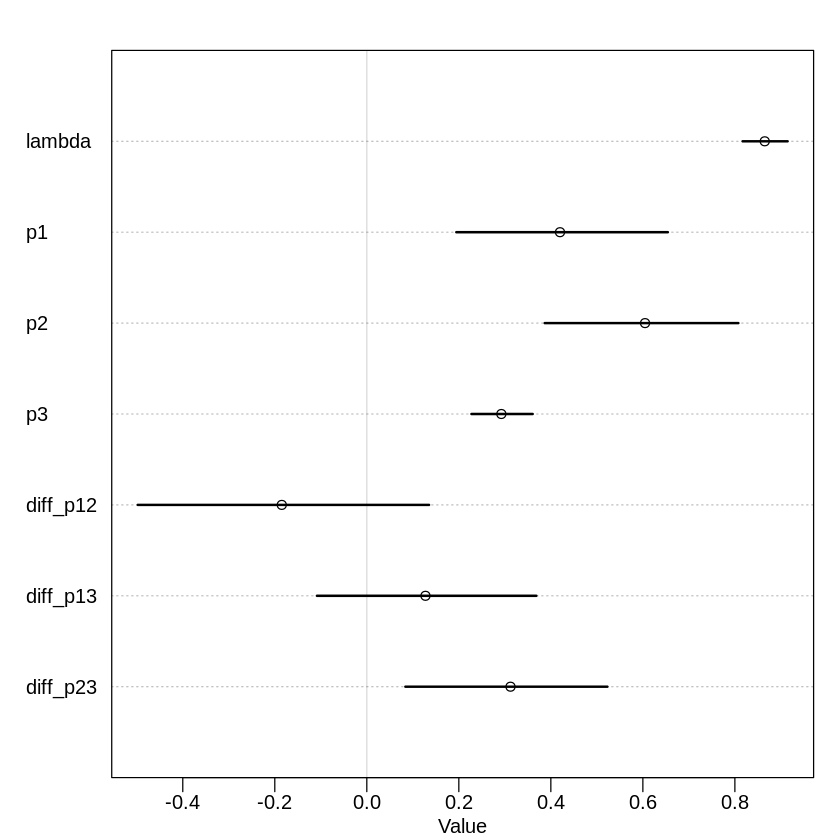

In [60]:
plot(precis( list(  lambda=lambda, p1=p1, p2=p2, p3=p3, diff_p12=diff_p12 , diff_p13=diff_p13, diff_p23=diff_p23 ) ))

Those with a camper and no livebait are estimated as having a much higher probability of not fishing, compared to those with livebait.  But there is not much difference between those with or without a camper, conditioned on not having livebait.  The distribution diff_p12 covers 0.  So perhaps my earlier idea that camper was not a good indicator for fishing has been supported by this.